# 라벨 백테스팅
### 과연 라벨 수익률은 얼마인가? 수익률 기반으로 정확히 잘만들어졌는가?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class SimpleBacktester:
    def __init__(self, data_path, start_date='2004-01-01', end_date='2014-12-31'):
        """
        3단계 라벨용 개별 종목 백테스터
        
        Parameters:
        -----------
        data_path : str
            CSV 파일들이 저장된 경로
        start_date : str
            백테스팅 시작 날짜
        end_date : str
            백테스팅 종료 날짜
        """
        self.data_path = data_path
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.stocks_data = {}
        self.results = {}
        
    def load_data(self):
        """CSV 파일들 로딩 (유연하게)"""
        # 다양한 패턴 시도 (최적화 라벨 파일 우선)
        patterns = ["*_optimized.csv", "*_enhanced.csv", "*_cleaned.csv", "*.csv"]
        csv_files = []
        
        for pattern in patterns:
            files = glob.glob(os.path.join(self.data_path, pattern))
            if files:
                csv_files = files
                print(f"파일 패턴 발견: {pattern} ({len(files)}개)")
                break
        
        if not csv_files:
            raise FileNotFoundError(f"CSV 파일을 찾을 수 없습니다: {self.data_path}")
        
        print(f"CSV 파일 로딩 중... ({len(csv_files)}개)")
        
        for file_path in tqdm(csv_files):
            try:
                # 파일명에서 종목명 추출
                filename = os.path.basename(file_path)
                symbol = filename.replace('.csv', '')
                for suffix in ['_enhanced', '_cleaned', '_processed']:
                    symbol = symbol.replace(suffix, '')
                
                # CSV 읽기
                df = pd.read_csv(file_path)
                
                # 날짜 컬럼 처리
                if 'Date' in df.columns:
                    df['Date'] = pd.to_datetime(df['Date'])
                    df.set_index('Date', inplace=True)
                elif 'Unnamed: 0' in df.columns:
                    df['Date'] = pd.to_datetime(df['Unnamed: 0'])
                    df.set_index('Date', inplace=True)
                    df.drop('Unnamed: 0', axis=1, inplace=True)
                else:
                    df.index = pd.to_datetime(df.index)
                
                # 사용할 라벨 컬럼 결정 (우선순위: Optimized_Label > Label)
                if 'Optimized_Label' in df.columns:
                    label_col = 'Optimized_Label'
                    label_name_col = 'Optimized_Label_Name'
                elif 'Label' in df.columns:
                    label_col = 'Label'
                    label_name_col = 'Label_Name'
                else:
                    continue
                
                # 필수 컬럼 확인
                if not all(col in df.columns for col in ['Close', label_col]):
                    continue
                
                # Label_Name이 없으면 3단계 라벨맵으로 생성
                if label_name_col not in df.columns:
                    label_map = {0: 'Strong_Sell', 1: 'Hold', 2: 'Strong_Buy'}
                    df[label_name_col] = df[label_col].map(label_map)
                
                # 백테스트에서 사용할 표준 컬럼명으로 복사
                df['Label'] = df[label_col]
                df['Label_Name'] = df[label_name_col]
                
                # 날짜 범위 필터링
                df = df.loc[self.start_date:self.end_date]
                
                if len(df) > 100:
                    self.stocks_data[symbol] = df
                    
            except Exception as e:
                print(f"파일 로딩 실패: {filename} - {e}")
        
        print(f"로딩 완료: {len(self.stocks_data)}개 종목")
        return self.stocks_data
    
    def simulate_trading(self, symbol, initial_capital=10000, transaction_cost=0.001):
        """3단계 라벨 기반 매매 시뮬레이션"""
        
        df = self.stocks_data[symbol].copy()
        
        # 시뮬레이션 변수
        cash = initial_capital
        shares = 0
        portfolio_values = []
        trades = []
        position = 'CASH'  # CASH, LONG
        
        for date, row in df.iterrows():
            current_price = row['Close']
            label = row['Label']
            label_name = row['Label_Name']
            
            # 포트폴리오 가치 계산
            portfolio_value = cash + (shares * current_price)
            portfolio_values.append(portfolio_value)
            
            # 3단계 라벨에 따른 매매 신호 처리
            if label == 2 and position == 'CASH':  # Strong_Buy (라벨=2) 신호
                shares_to_buy = cash / (current_price * (1 + transaction_cost))
                if shares_to_buy > 0:
                    shares += shares_to_buy
                    cash -= shares_to_buy * current_price * (1 + transaction_cost)
                    position = 'LONG'
                    
                    trades.append({
                        'date': date,
                        'action': 'BUY',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'value': shares_to_buy * current_price,
                        'label': label_name
                    })
            
            elif label == 0 and position == 'LONG':  # Strong_Sell (라벨=0) 신호
                if shares > 0:
                    sale_value = shares * current_price * (1 - transaction_cost)
                    cash += sale_value
                    
                    trades.append({
                        'date': date,
                        'action': 'SELL',
                        'price': current_price,
                        'shares': shares,
                        'value': sale_value,
                        'label': label_name
                    })
                    
                    shares = 0
                    position = 'CASH'
            
            # Hold (라벨=1)일 때는 기존 포지션 유지
        
        # 최종 정산 (보유주식 강제 매도)
        if shares > 0:
            final_price = df.iloc[-1]['Close']
            final_value = shares * final_price * (1 - transaction_cost)
            cash += final_value
            
            trades.append({
                'date': df.index[-1],
                'action': 'FINAL_SELL',
                'price': final_price,
                'shares': shares,
                'value': final_value,
                'label': 'FINAL'
            })
        
        # 결과 계산
        df['Portfolio_Value'] = portfolio_values
        final_value = cash
        total_return = (final_value - initial_capital) / initial_capital
        
        # Buy & Hold: 첫날 매수해서 마지막날 매도
        buy_hold_return = (df.iloc[-1]['Close'] - df.iloc[0]['Close']) / df.iloc[0]['Close']
        
        # 샤프 비율: (평균 일일수익률 / 수익률 변동성) × √252
        daily_returns = df['Portfolio_Value'].pct_change().dropna()
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
        
        # 최대 손실폭 (Maximum Drawdown)
        peak = df['Portfolio_Value'].expanding().max()
        drawdown = (df['Portfolio_Value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        # 승률 계산 (매매당 수익률)
        trade_returns = []
        for i in range(0, len(trades)-1, 2):  # 매수-매도 쌍으로 계산
            if i+1 < len(trades):
                buy_trade = trades[i]
                sell_trade = trades[i+1]
                trade_return = (sell_trade['price'] - buy_trade['price']) / buy_trade['price']
                trade_returns.append(trade_return)
        
        win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns) if trade_returns else 0
        avg_trade_return = np.mean(trade_returns) if trade_returns else 0
        
        return {
            'symbol': symbol,
            'initial_capital': initial_capital,
            'final_value': final_value,
            'total_return': total_return,
            'buy_hold_return': buy_hold_return,
            'excess_return': total_return - buy_hold_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'avg_trade_return': avg_trade_return,
            'trades': trades,
            'portfolio_values': df['Portfolio_Value'].values,
            'dates': df.index.values
        }
    
    def plot_individual_stock(self, symbol, figsize=(15, 10)):
        """개별 종목 백테스팅 결과 시각화 (3단계 라벨용)"""
        
        if symbol not in self.results:
            print(f"{symbol} 결과가 없습니다.")
            return
        
        result = self.results[symbol]
        df = self.stocks_data[symbol]
        
        fig, axes = plt.subplots(3, 1, figsize=figsize)
        
        # 1. 가격 차트 + 매매 신호
        ax1 = axes[0]
        ax1.plot(df.index, df['Close'], label='Close Price', alpha=0.7, color='black')
        
        # 매매 포인트 표시
        trades = result['trades']
        buy_trades = [t for t in trades if t['action'] == 'BUY']
        sell_trades = [t for t in trades if t['action'] in ['SELL', 'FINAL_SELL']]
        
        if buy_trades:
            buy_dates = [t['date'] for t in buy_trades]
            buy_prices = [t['price'] for t in buy_trades]
            ax1.scatter(buy_dates, buy_prices, color='green', marker='^', 
                       s=100, label=f'Buy Signals ({len(buy_trades)})', zorder=5)
        
        if sell_trades:
            sell_dates = [t['date'] for t in sell_trades]
            sell_prices = [t['price'] for t in sell_trades]
            ax1.scatter(sell_dates, sell_prices, color='red', marker='v', 
                       s=100, label=f'Sell Signals ({len(sell_trades)})', zorder=5)
        
        ax1.set_title(f'{symbol} - Price & Trading Signals')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # X축 월 단위로 설정 (1개월 간격)
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 3 → 1로 변경
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. 포트폴리오 가치 vs Buy & Hold 비교
        ax2 = axes[1]
        ax2.plot(df.index, result['portfolio_values'], label='Strategy Portfolio', color='blue', linewidth=2)
        
        # Buy & Hold 비교 (첫날 매수 → 마지막날 매도)
        buy_hold_values = (df['Close'] / df.iloc[0]['Close']) * result['initial_capital']
        ax2.plot(df.index, buy_hold_values, label='Buy & Hold', color='orange', alpha=0.7)
        
        ax2.set_title(f'Portfolio Value Comparison')
        ax2.set_ylabel('Portfolio Value ($)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # X축 월 단위로 설정 (1개월 간격)
        ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 3 → 1로 변경
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax2.tick_params(axis='x', rotation=45)
        
        # 3. 라벨 분포 (3단계)
        ax3 = axes[2]
        label_counts = df['Label'].value_counts().sort_index()
        
        # 3단계 라벨명과 색상
        label_names = {0: 'Strong_Sell', 1: 'Hold', 2: 'Strong_Buy'}
        colors = {0: 'red', 1: 'gray', 2: 'green'}
        
        # 막대 그래프
        labels_present = label_counts.index
        bar_colors = [colors[i] for i in labels_present]
        bar_labels = [label_names[i] for i in labels_present]
        
        bars = ax3.bar(range(len(label_counts)), label_counts.values, color=bar_colors)
        ax3.set_title('Label Distribution (3-Class)')
        ax3.set_xlabel('Signal Types')
        ax3.set_ylabel('Count')
        ax3.set_xticks(range(len(label_counts)))
        ax3.set_xticklabels(bar_labels)
        
        # 막대 위에 숫자 표시
        for i, count in enumerate(label_counts.values):
            ax3.text(i, count + 0.01*max(label_counts), str(count), 
                    ha='center', va='bottom')
        
        plt.tight_layout()
        
        # 결과 요약 출력
        print(f"\n{symbol} 백테스팅 결과:")
        print(f"전략 수익률: {result['total_return']:.2%}")
        print(f"Buy & Hold 수익률: {result['buy_hold_return']:.2%}")
        print(f"초과 수익률: {result['excess_return']:.2%}")
        print(f"샤프 비율: {result['sharpe_ratio']:.2f}")
        print(f"최대 손실폭: {result['max_drawdown']:.2%}")
        print(f"총 거래 횟수: {result['num_trades']}회")
        print(f"승률: {result['win_rate']:.2%}")
        print(f"평균 거래수익률: {result['avg_trade_return']:.2%}")
        print(f"최종 자산: ${result['final_value']:,.0f}")
        
        plt.show()
    
    def get_summary_stats(self):
        """전체 백테스팅 결과 요약"""
        if not self.results:
            return
        
        summary_data = []
        for symbol, result in self.results.items():
            summary_data.append({
                'Symbol': symbol,
                'Total_Return': result['total_return'],
                'Excess_Return': result['excess_return'],
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Win_Rate': result['win_rate'],
                'Num_Trades': result['num_trades']
            })
        
        summary_df = pd.DataFrame(summary_data)
        print("\n전체 백테스팅 결과 요약:")
        print("="*60)
        print(summary_df.to_string(index=False, float_format='%.3f'))
        
        # 평균 통계
        print(f"\n평균 통계:")
        print(f"평균 수익률: {summary_df['Total_Return'].mean():.2%}")
        print(f"평균 초과수익률: {summary_df['Excess_Return'].mean():.2%}")
        print(f"평균 샤프비율: {summary_df['Sharpe_Ratio'].mean():.2f}")
        print(f"평균 승률: {summary_df['Win_Rate'].mean():.2%}")
        
        return summary_df

def run_individual_backtest(data_path, start_date='2004-01-01', end_date='2014-12-31', 
                           symbols=None, max_stocks=5, initial_capital=10000):
    """
    3단계 라벨 기반 개별 종목 백테스팅 실행
    
    Parameters:
    -----------
    data_path : str
        CSV 파일 경로
    start_date : str
        백테스팅 시작 날짜
    end_date : str
        백테스팅 종료 날짜
    symbols : list, optional
        특정 종목만 테스트 (None이면 전체 또는 처음 몇 개)
    max_stocks : int
        최대 테스트 종목 수
    initial_capital : float
        초기 투자 금액
    """
    
    # 백테스터 생성 (기간 설정 포함)
    backtester = SimpleBacktester(data_path, start_date, end_date)
    
    # 데이터 로딩
    backtester.load_data()
    
    # 테스트할 종목 선택
    if symbols:
        stocks_to_test = [s for s in symbols if s in backtester.stocks_data]
    else:
        stocks_to_test = list(backtester.stocks_data.keys())[:max_stocks]
    
    print(f"\nBacktesting Period: {start_date} to {end_date}")
    print(f"Initial Capital: ${initial_capital:,}")
    print(f"3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)")
    print(f"Running backtest for {len(stocks_to_test)} stocks...")
    
    # 각 종목별 백테스팅 및 시각화
    for symbol in stocks_to_test:
        result = backtester.simulate_trading(symbol, initial_capital)
        if result:
            backtester.results[symbol] = result
            backtester.plot_individual_stock(symbol)
    
    # 전체 결과 요약
    summary_df = backtester.get_summary_stats()
    
    return backtester, summary_df

# 종목별 기간 백테스팅

파일 패턴 발견: *_optimized.csv (20개)
CSV 파일 로딩 중... (20개)


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


로딩 완료: 20개 종목

Backtesting Period: 2023-10-01 to 2025-09-21
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 20 stocks...

ADA_optimized 백테스팅 결과:
전략 수익률: 8744098455048188.00%
Buy & Hold 수익률: 250.84%
초과 수익률: 8744098455047936.00%
샤프 비율: 4.10
최대 손실폭: -7.75%
총 거래 횟수: 2470회
승률: 99.76%
평균 거래수익률: 2.93%
최종 자산: $874,409,845,504,828,672


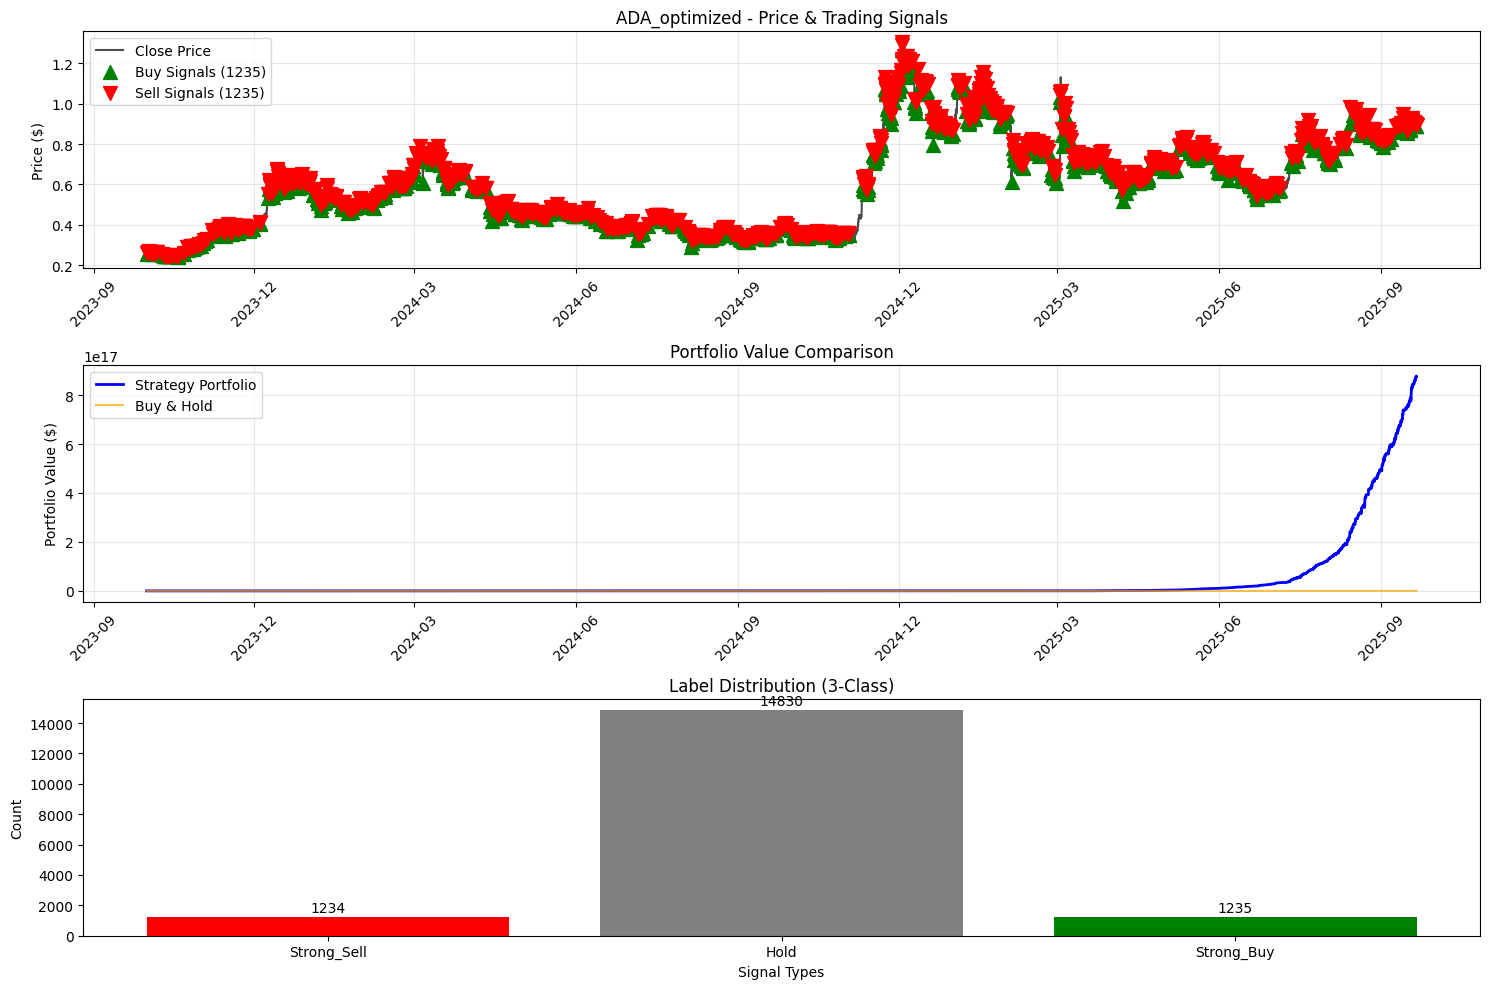


AVAX_optimized 백테스팅 결과:
전략 수익률: 537987445100332672.00%
Buy & Hold 수익률: 257.51%
초과 수익률: 537987445100332416.00%
샤프 비율: 4.68
최대 손실폭: -6.91%
총 거래 횟수: 2454회
승률: 99.84%
평균 거래수익률: 3.27%
최종 자산: $53,798,744,510,033,281,024


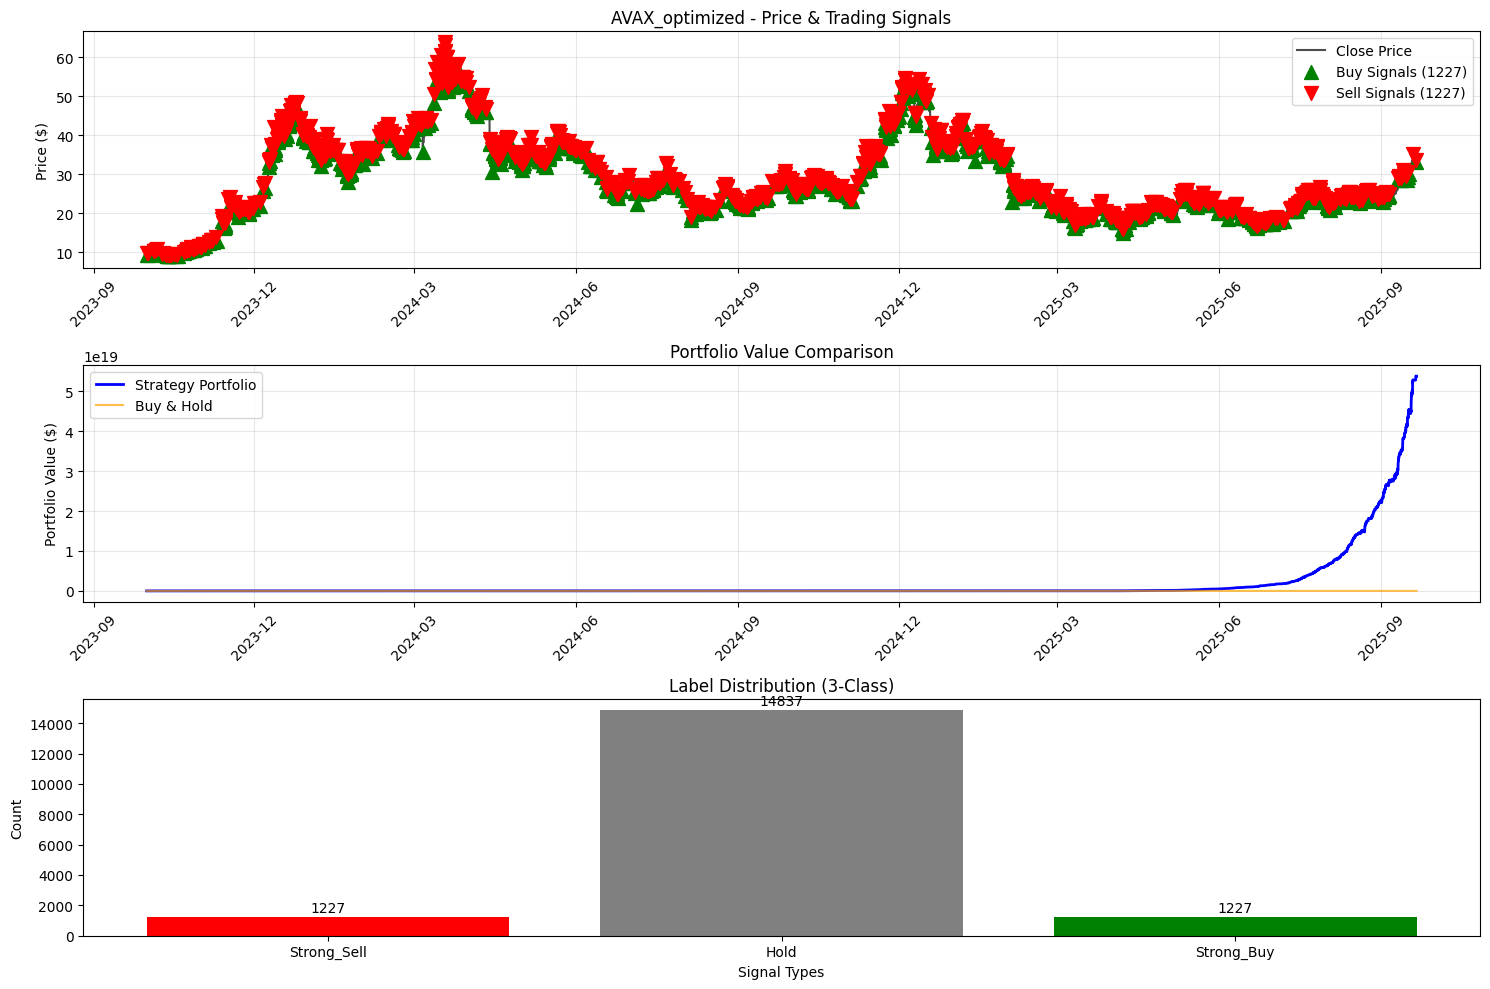


BCH_optimized 백테스팅 결과:
전략 수익률: 149548222997251.50%
Buy & Hold 수익률: 150.95%
초과 수익률: 149548222997100.53%
샤프 비율: 4.11
최대 손실폭: -7.43%
총 거래 횟수: 2614회
승률: 99.62%
평균 거래수익률: 2.42%
최종 자산: $14,954,822,299,735,148


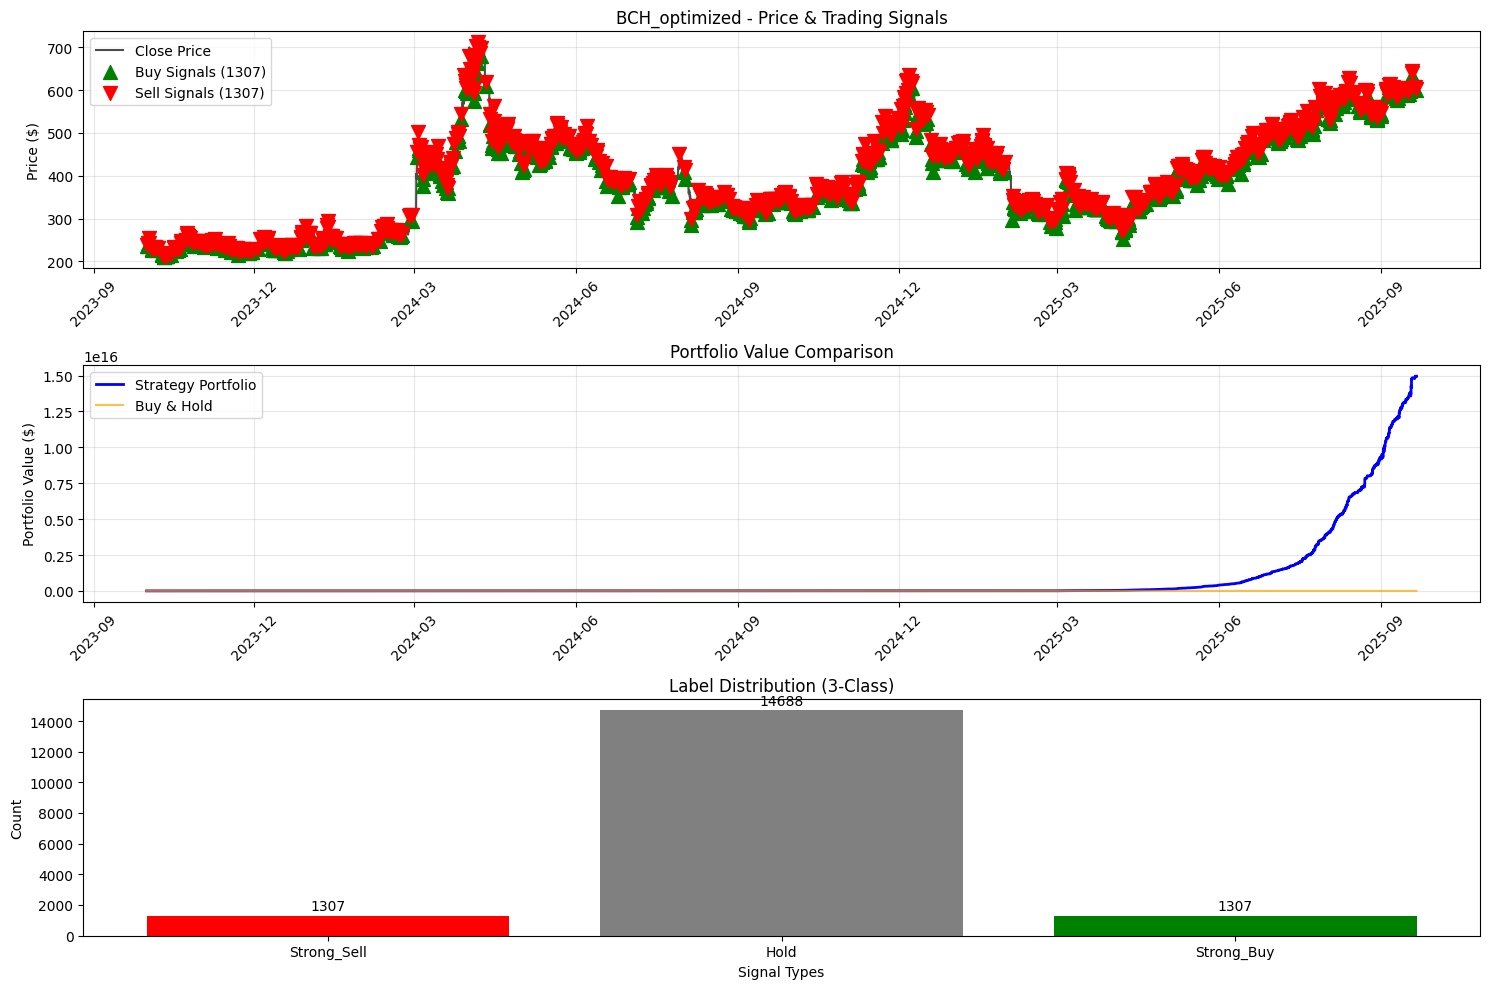


BNB_optimized 백테스팅 결과:
전략 수익률: 18527938894.58%
Buy & Hold 수익률: 384.94%
초과 수익률: 18527938509.65%
샤프 비율: 4.38
최대 손실폭: -7.05%
총 거래 횟수: 2544회
승률: 99.84%
평균 거래수익률: 1.73%
최종 자산: $1,852,793,899,458


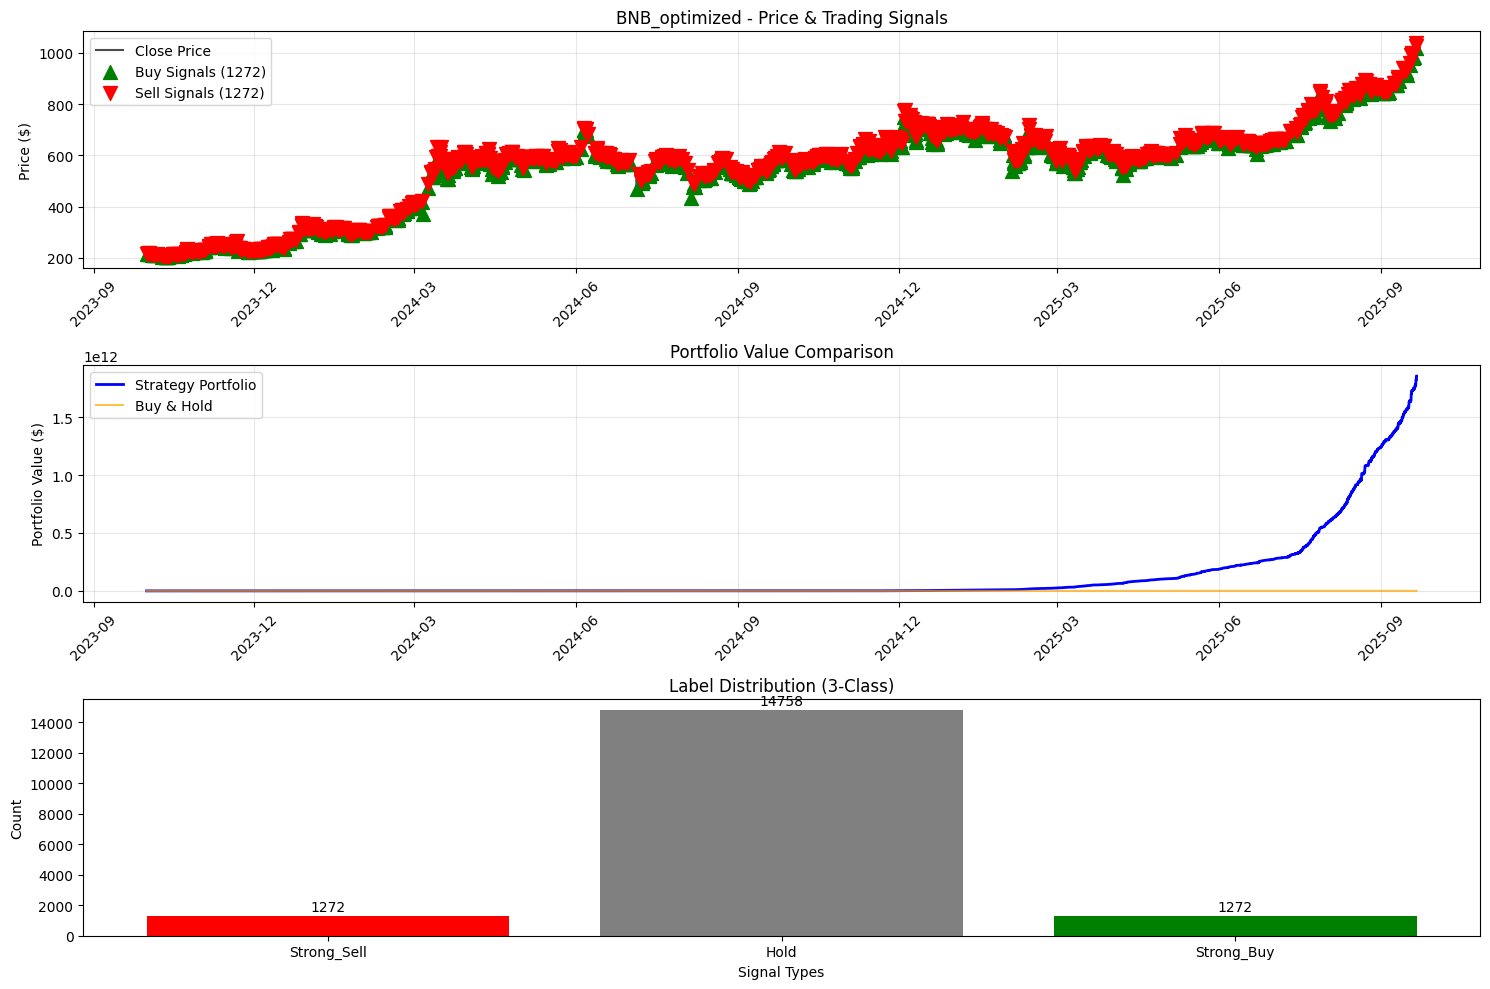


BTC_optimized 백테스팅 결과:
전략 수익률: 729897297.88%
Buy & Hold 수익률: 328.68%
초과 수익률: 729896969.19%
샤프 비율: 4.15
최대 손실폭: -5.53%
총 거래 횟수: 2514회
승률: 99.92%
평균 거래수익률: 1.48%
최종 자산: $72,989,739,788


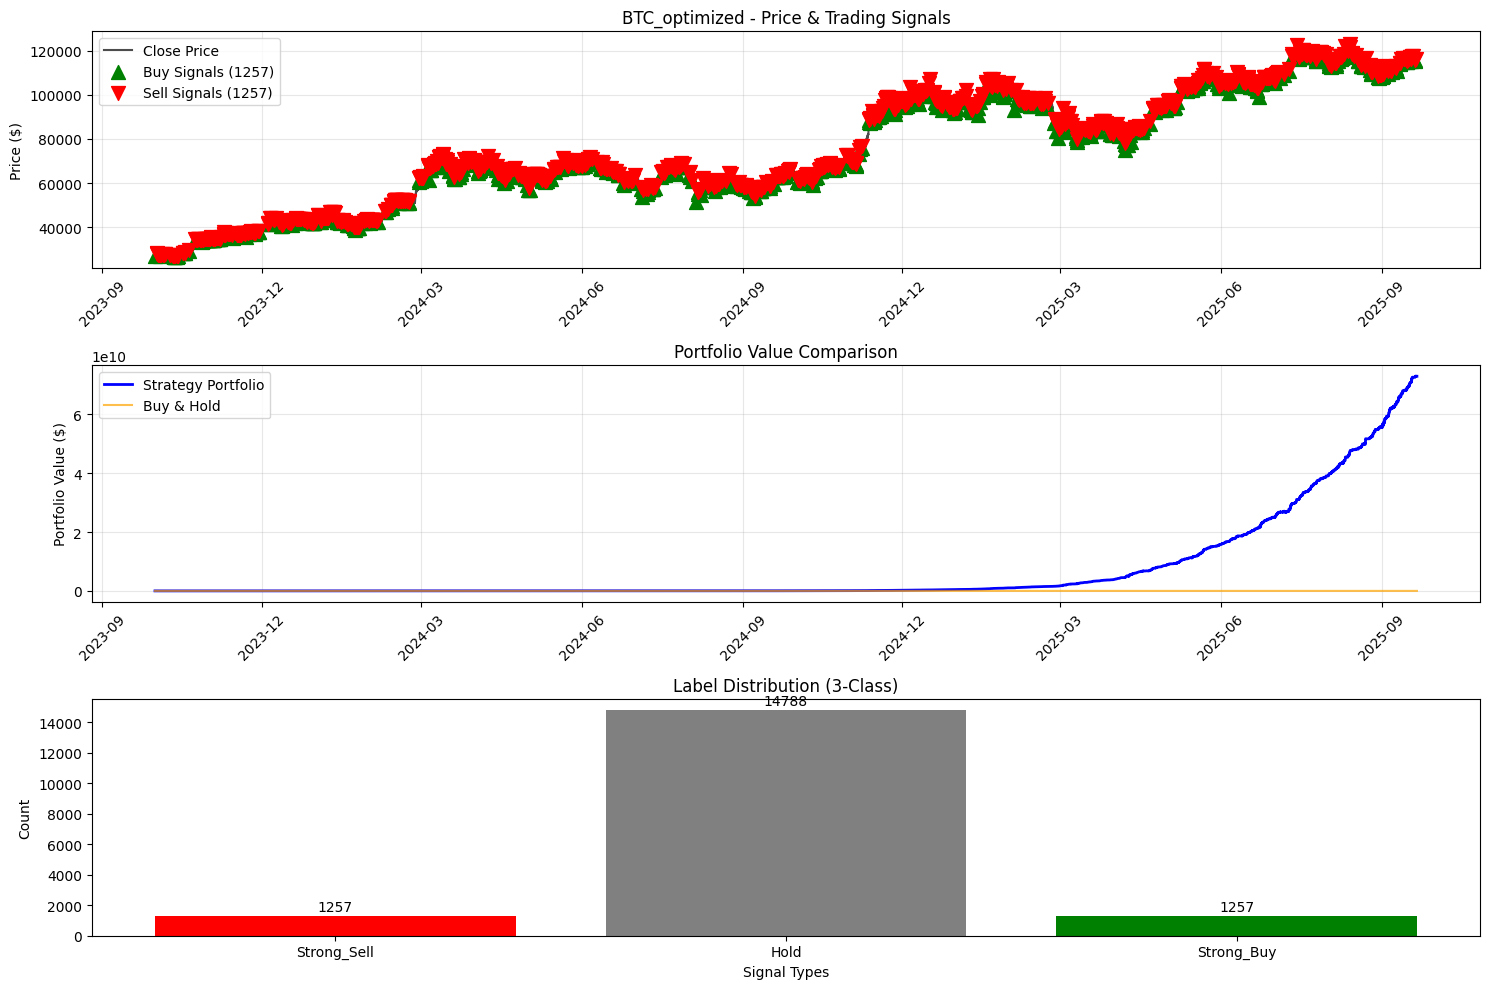


CRO_optimized 백테스팅 결과:
전략 수익률: 8113515260574430.00%
Buy & Hold 수익률: 351.00%
초과 수익률: 8113515260574078.00%
샤프 비율: 3.72
최대 손실폭: -8.03%
총 거래 횟수: 2560회
승률: 99.69%
평균 거래수익률: 2.85%
최종 자산: $811,351,526,057,452,928


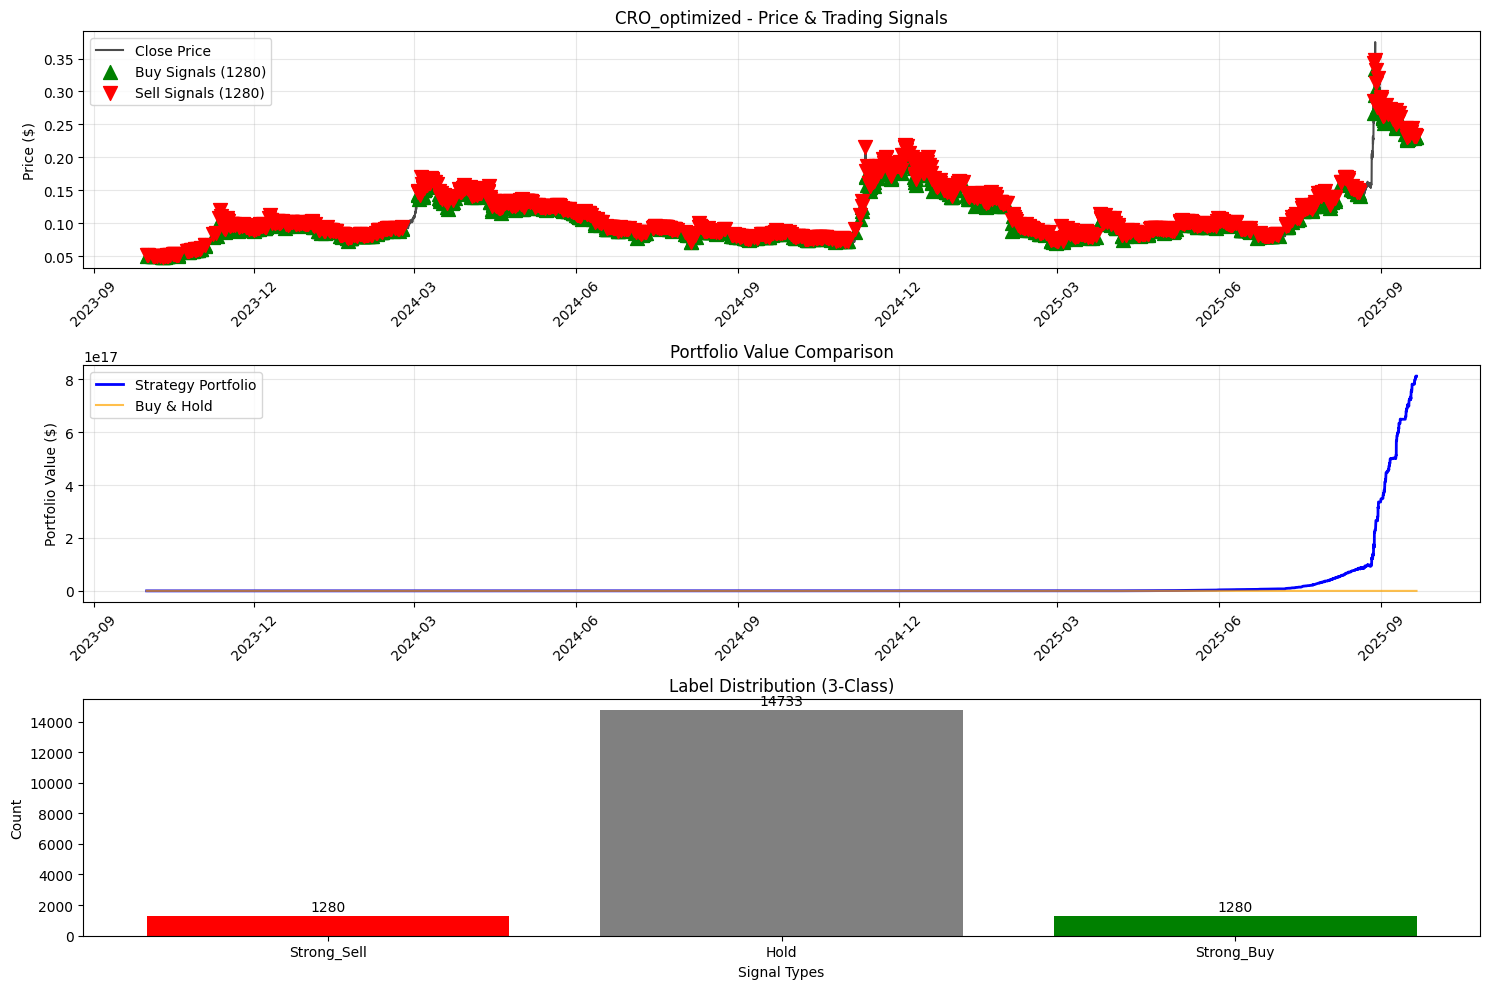


DOGE_optimized 백테스팅 결과:
전략 수익률: 53868669395823832.00%
Buy & Hold 수익률: 331.19%
초과 수익률: 53868669395823504.00%
샤프 비율: 4.24
최대 손실폭: -6.88%
총 거래 횟수: 2318회
승률: 99.83%
평균 거래수익률: 3.27%
최종 자산: $5,386,866,939,582,393,344


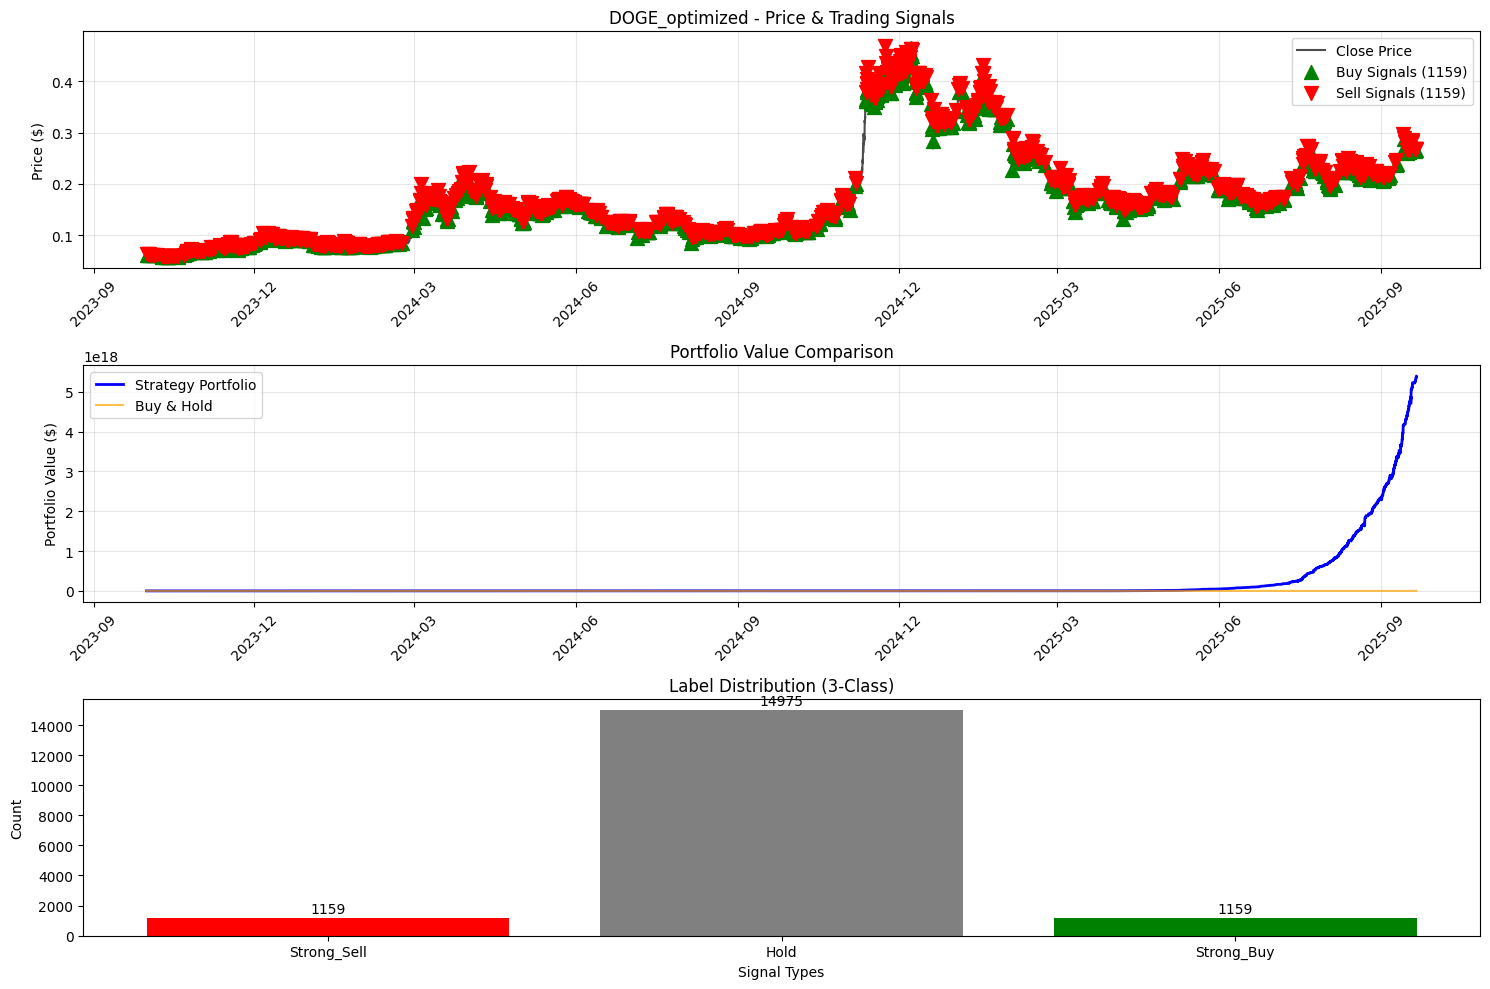


ETH_optimized 백테스팅 결과:
전략 수익률: 416654975206.05%
Buy & Hold 수익률: 167.71%
초과 수익률: 416654975038.34%
샤프 비율: 4.35
최대 손실폭: -5.69%
총 거래 횟수: 2478회
승률: 99.84%
평균 거래수익률: 2.04%
최종 자산: $41,665,497,530,605


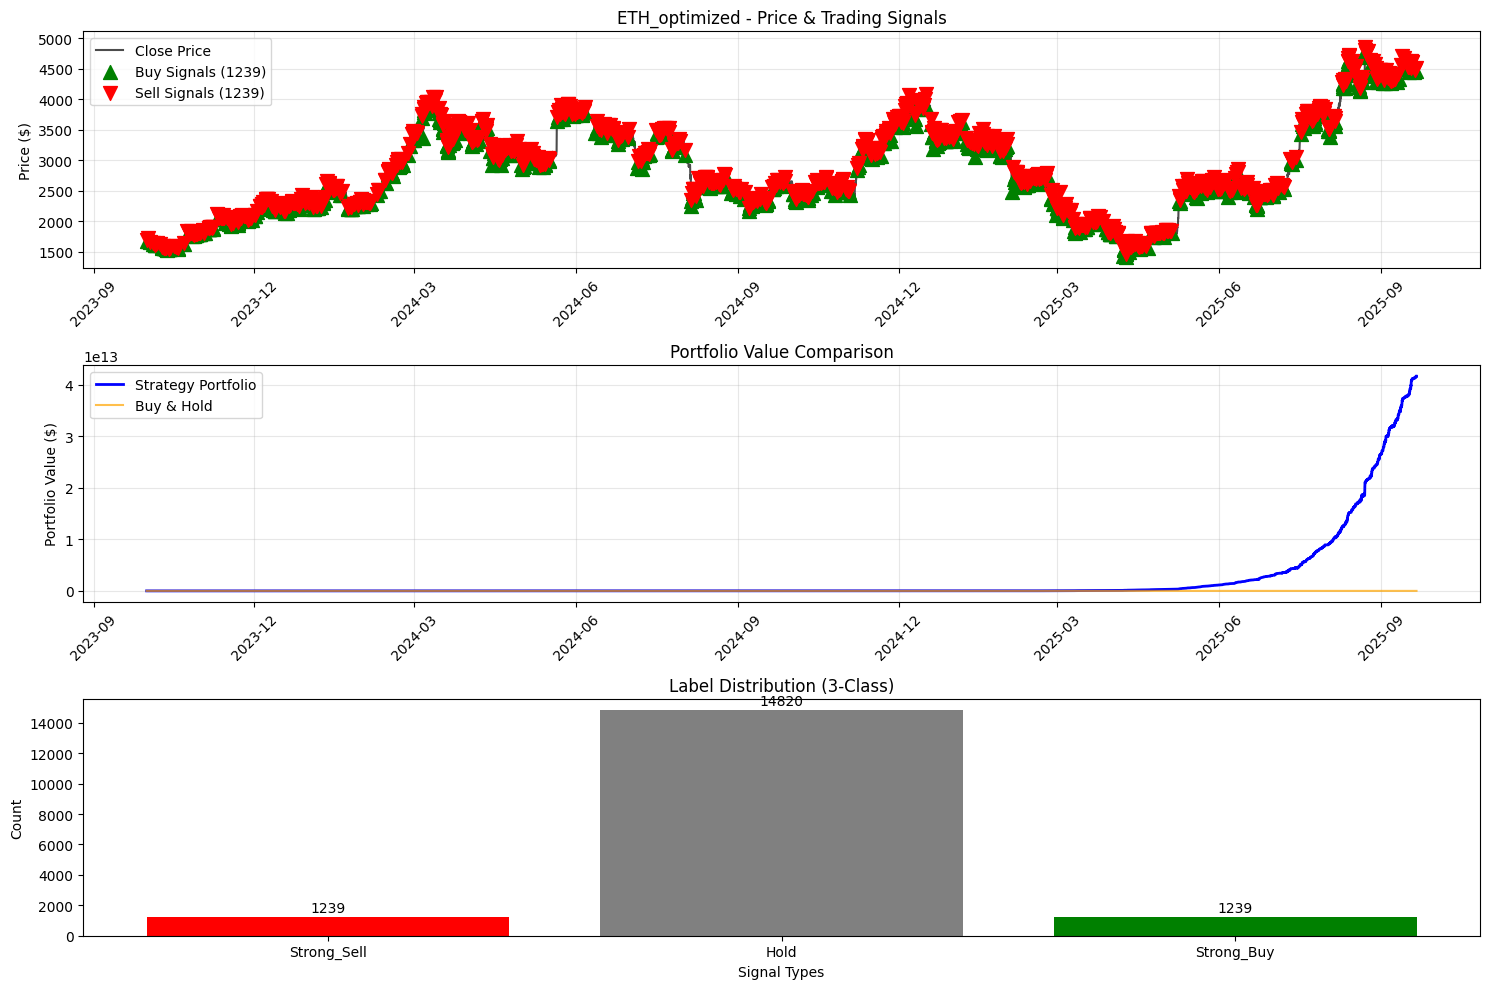


HBAR_optimized 백테스팅 결과:
전략 수익률: 1127909365606973952.00%
Buy & Hold 수익률: 386.82%
초과 수익률: 1127909365606973568.00%
샤프 비율: 4.06
최대 손실폭: -8.35%
총 거래 횟수: 2540회
승률: 99.92%
평균 거래수익률: 3.29%
최종 자산: $112,790,936,560,697,425,920


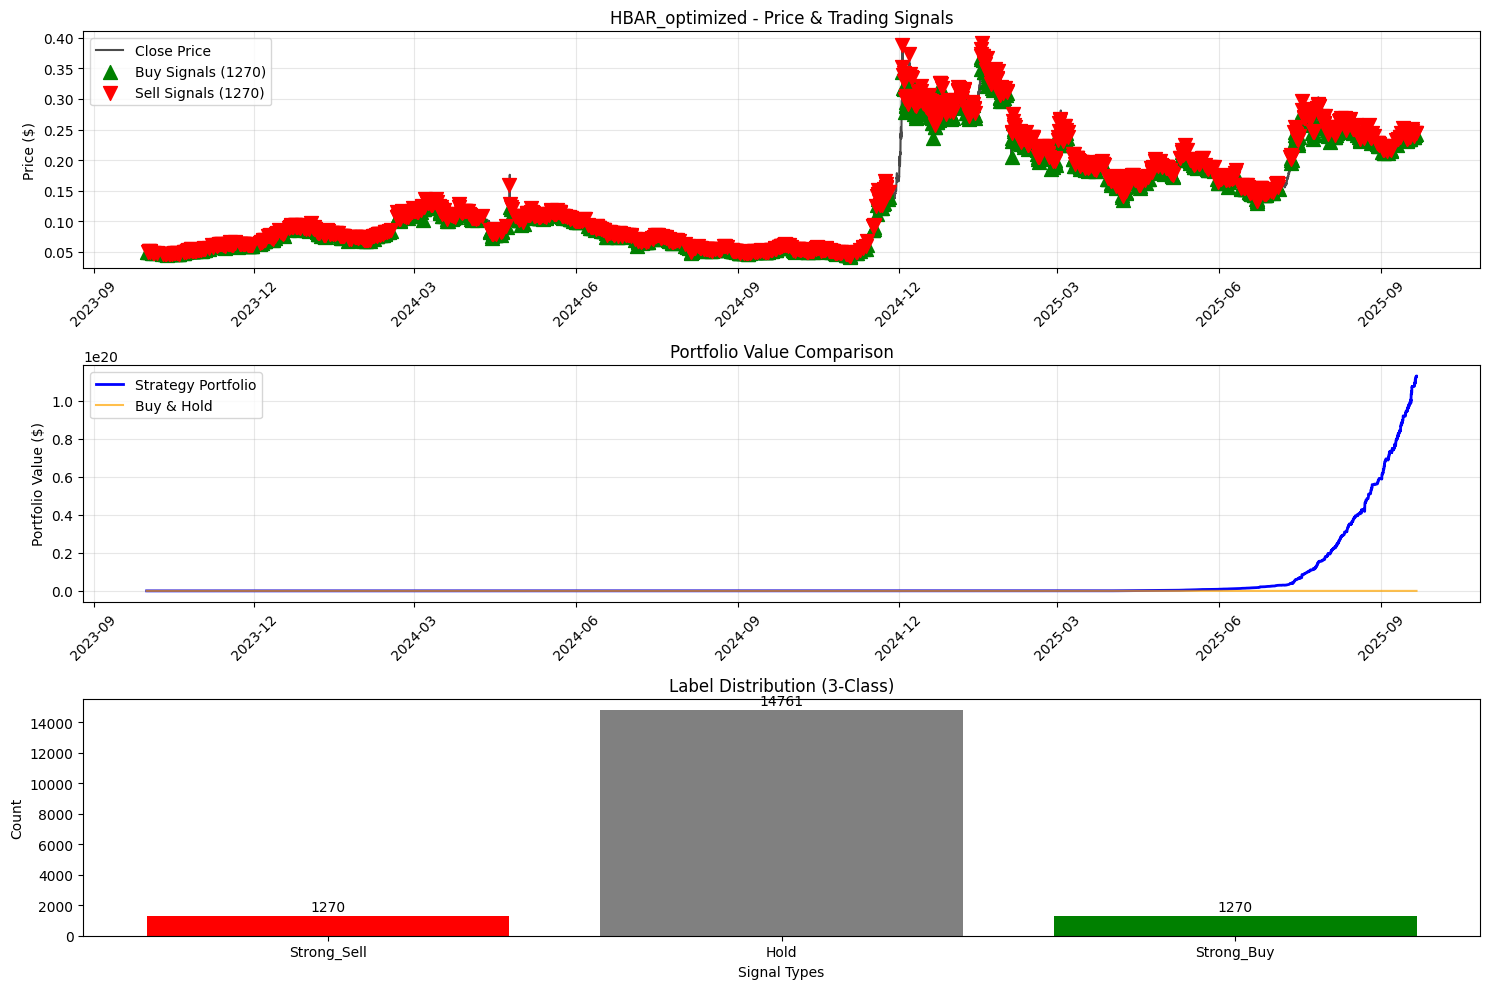


LEO_optimized 백테스팅 결과:
전략 수익률: 5507385990.75%
Buy & Hold 수익률: 160.21%
초과 수익률: 5507385830.54%
샤프 비율: 2.73
최대 손실폭: -11.25%
총 거래 횟수: 3724회
승률: 99.79%
평균 거래수익률: 1.18%
최종 자산: $550,738,609,075


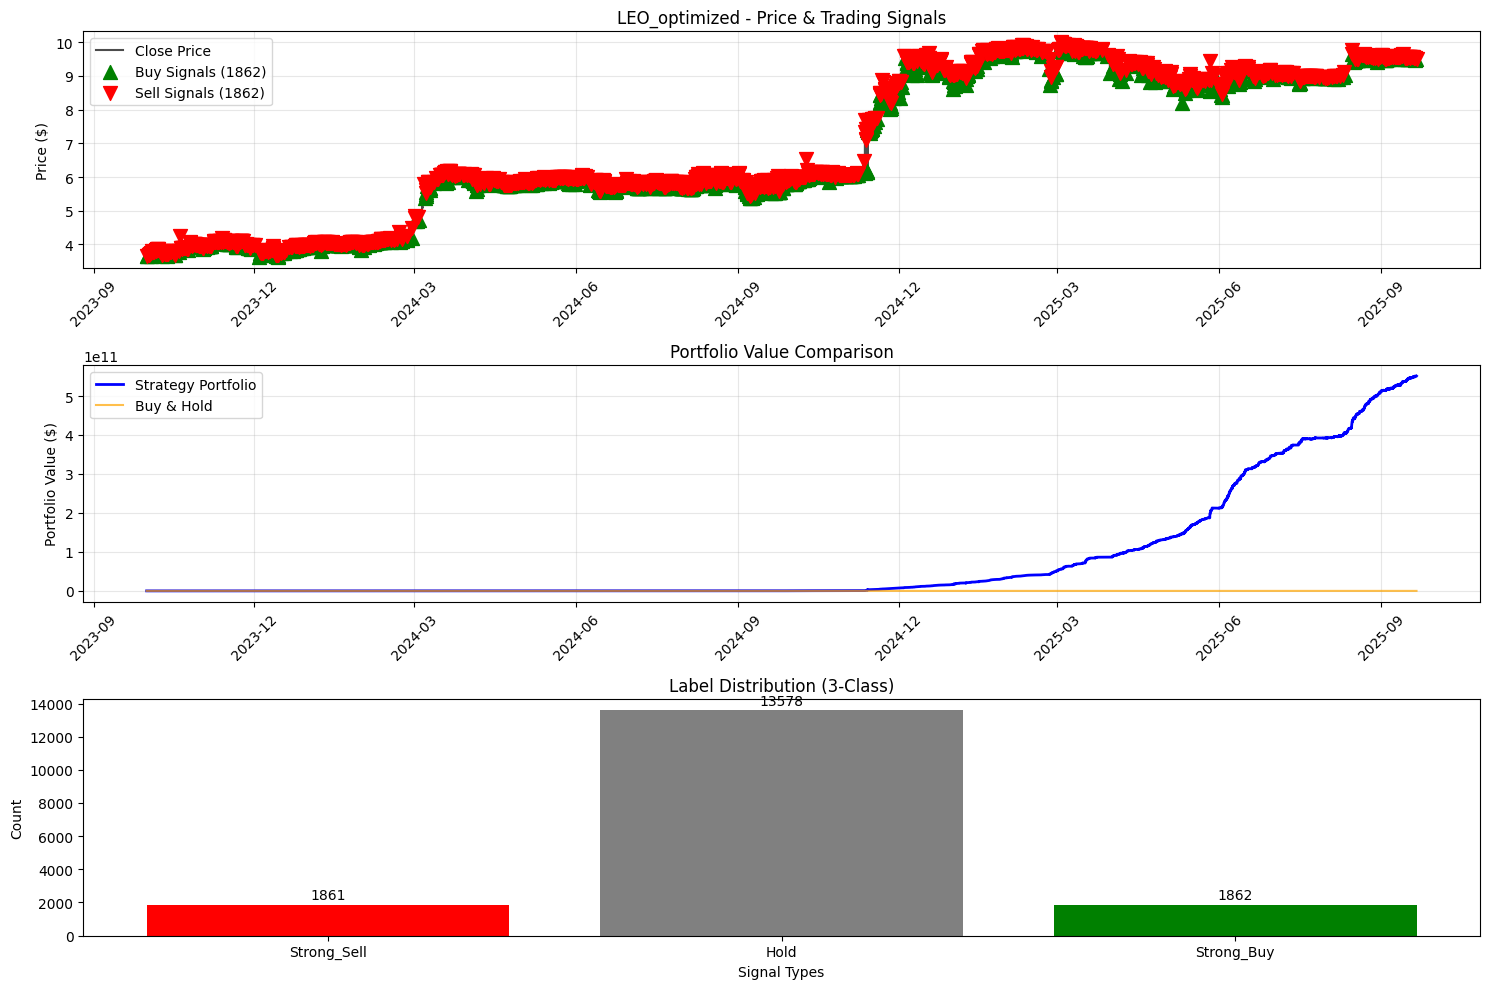


LTC_optimized 백테스팅 결과:
전략 수익률: 24895874396882.37%
Buy & Hold 수익률: 72.35%
초과 수익률: 24895874396810.02%
샤프 비율: 4.37
최대 손실폭: -5.77%
총 거래 횟수: 2696회
승률: 100.00%
평균 거래수익률: 2.21%
최종 자산: $2,489,587,439,698,237


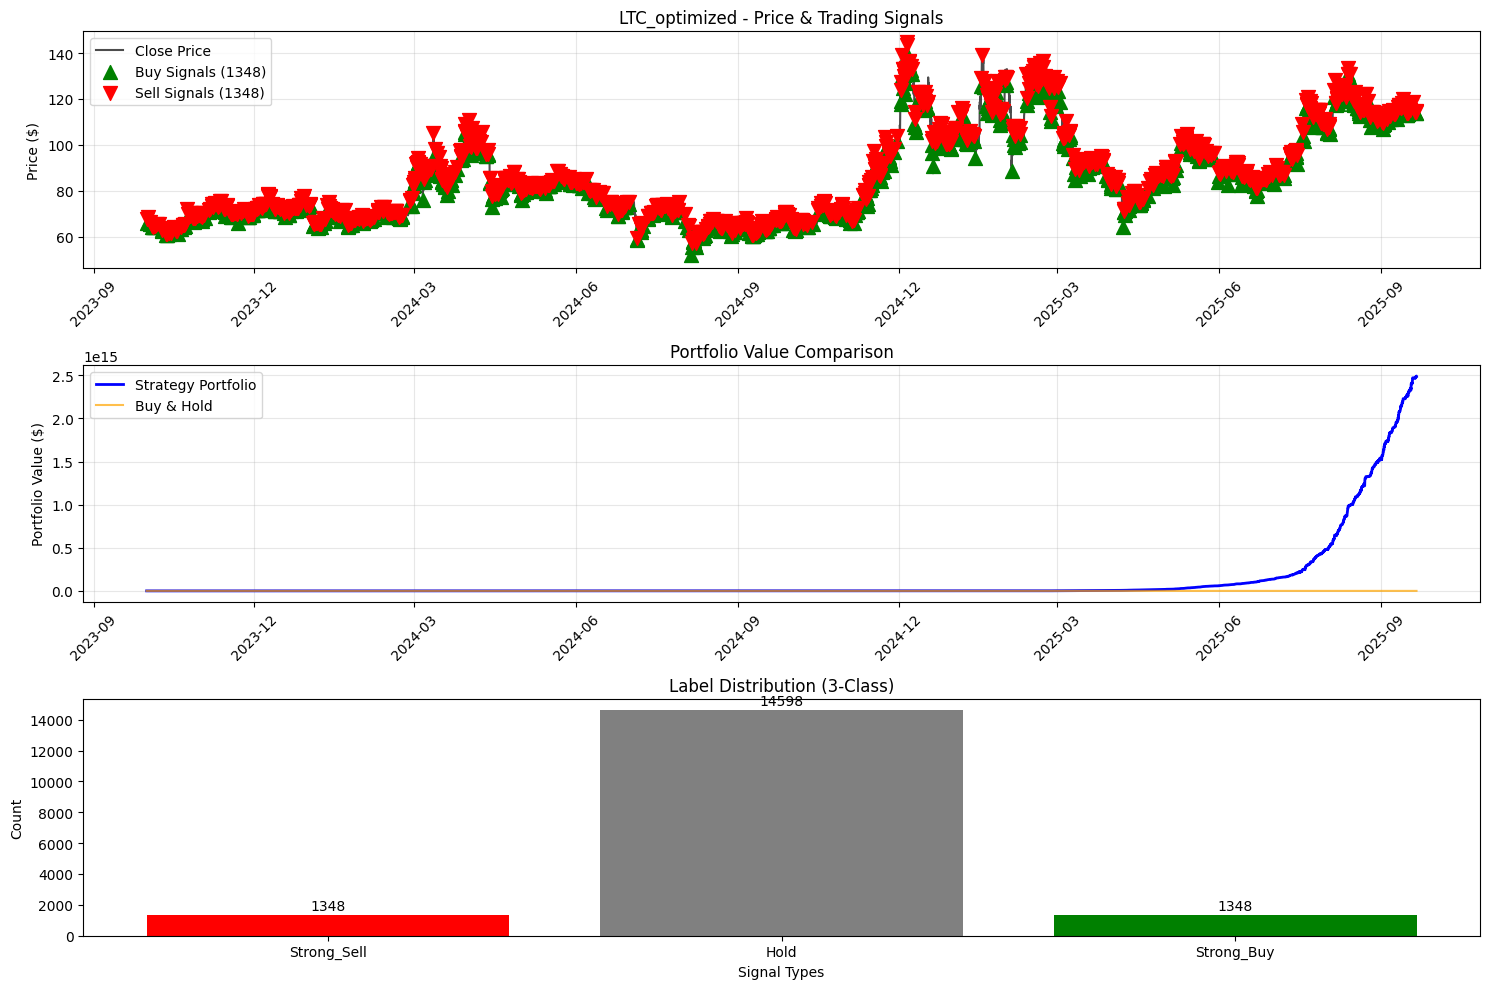


SHIB_optimized 백테스팅 결과:
전략 수익률: 9847566925073380.00%
Buy & Hold 수익률: 75.49%
초과 수익률: 9847566925073304.00%
샤프 비율: 3.93
최대 손실폭: -10.15%
총 거래 횟수: 2402회
승률: 99.92%
평균 거래수익률: 3.01%
최종 자산: $984,756,692,507,347,968


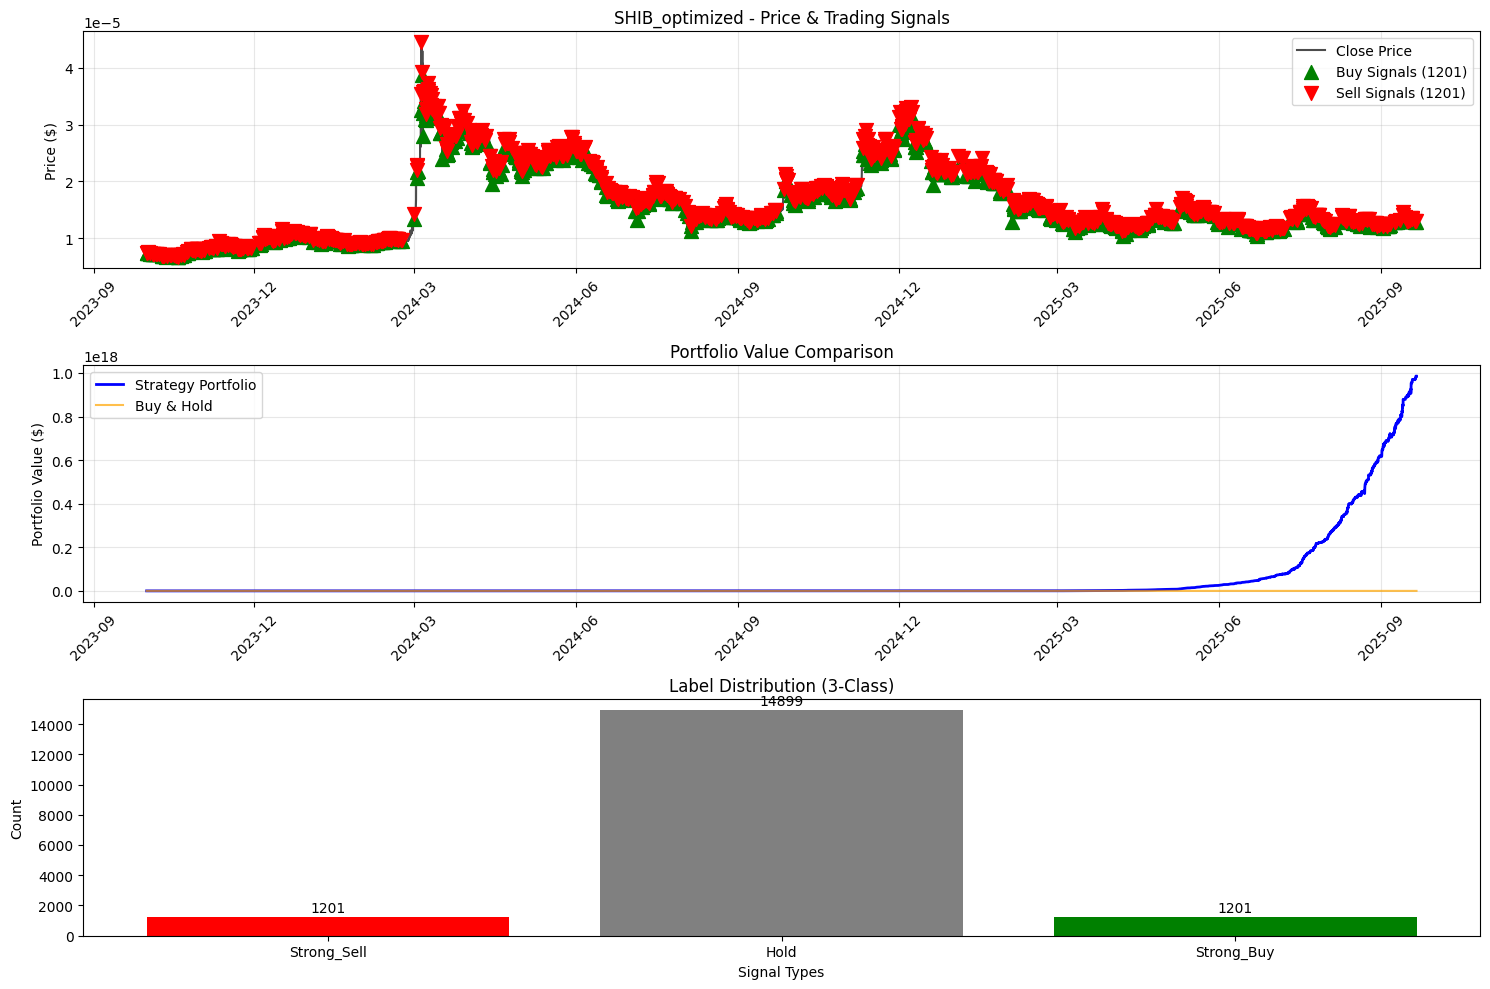


SOL_optimized 백테스팅 결과:
전략 수익률: 91948883482840416.00%
Buy & Hold 수익률: 1023.47%
초과 수익률: 91948883482839392.00%
샤프 비율: 4.59
최대 손실폭: -8.74%
총 거래 횟수: 2490회
승률: 99.76%
평균 거래수익률: 3.07%
최종 자산: $9,194,888,348,284,051,456


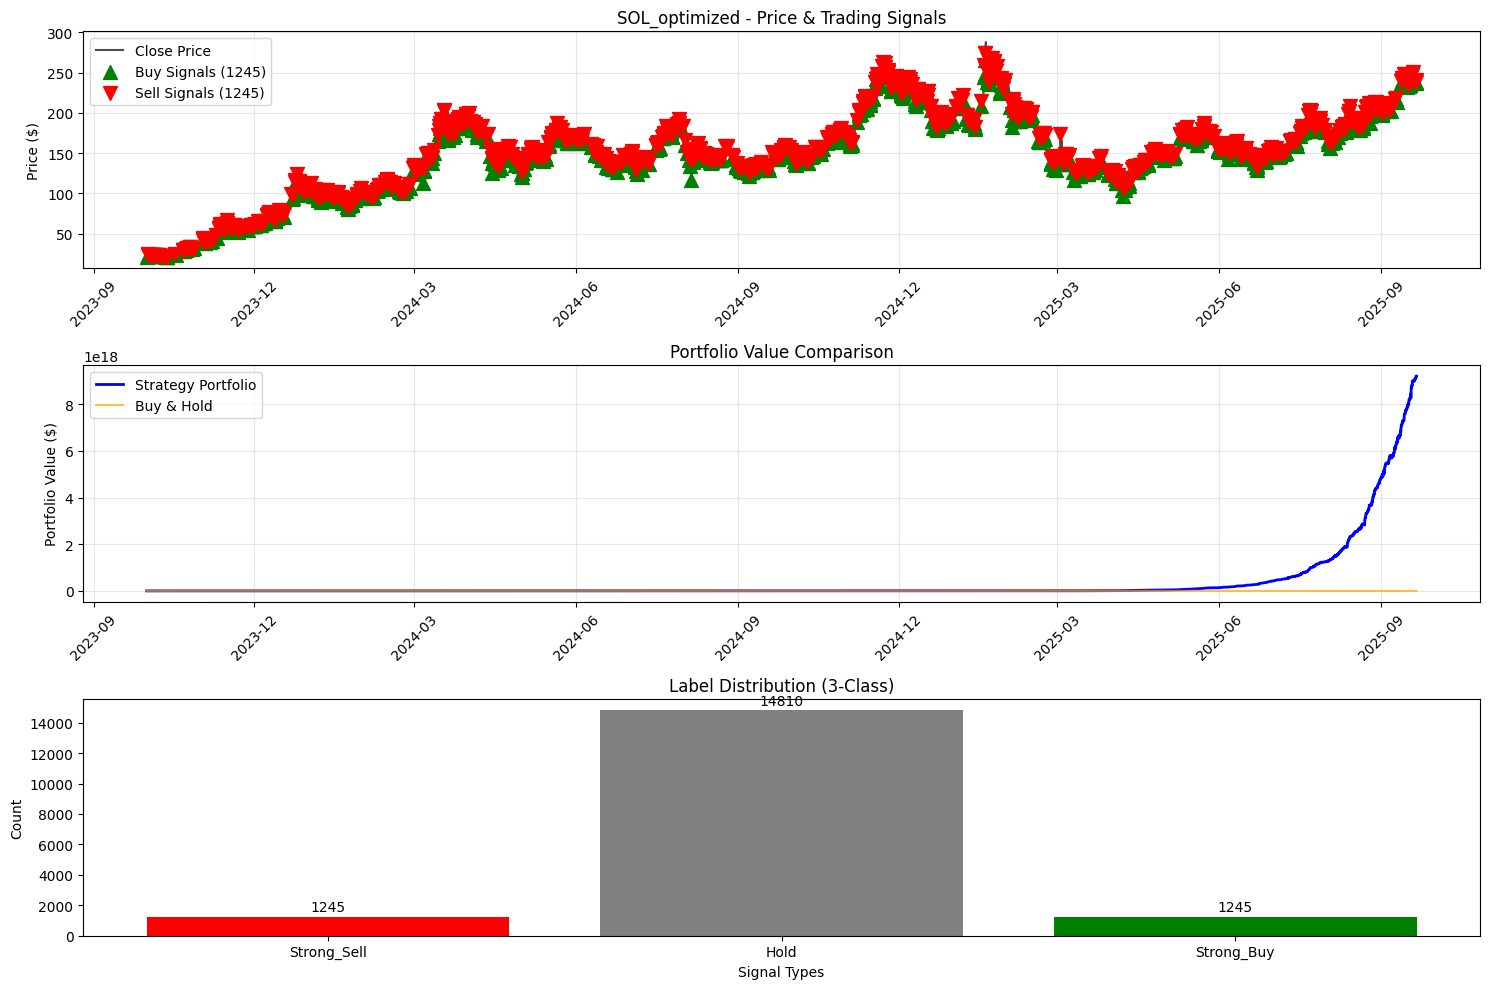


SUI20947_optimized 백테스팅 결과:
전략 수익률: 722964774155899109376.00%
Buy & Hold 수익률: 683.44%
초과 수익률: 722964774155899109376.00%
샤프 비율: 4.69
최대 손실폭: -11.80%
총 거래 횟수: 2508회
승률: 99.68%
평균 거래수익률: 3.83%
최종 자산: $72,296,477,415,589,910,937,600


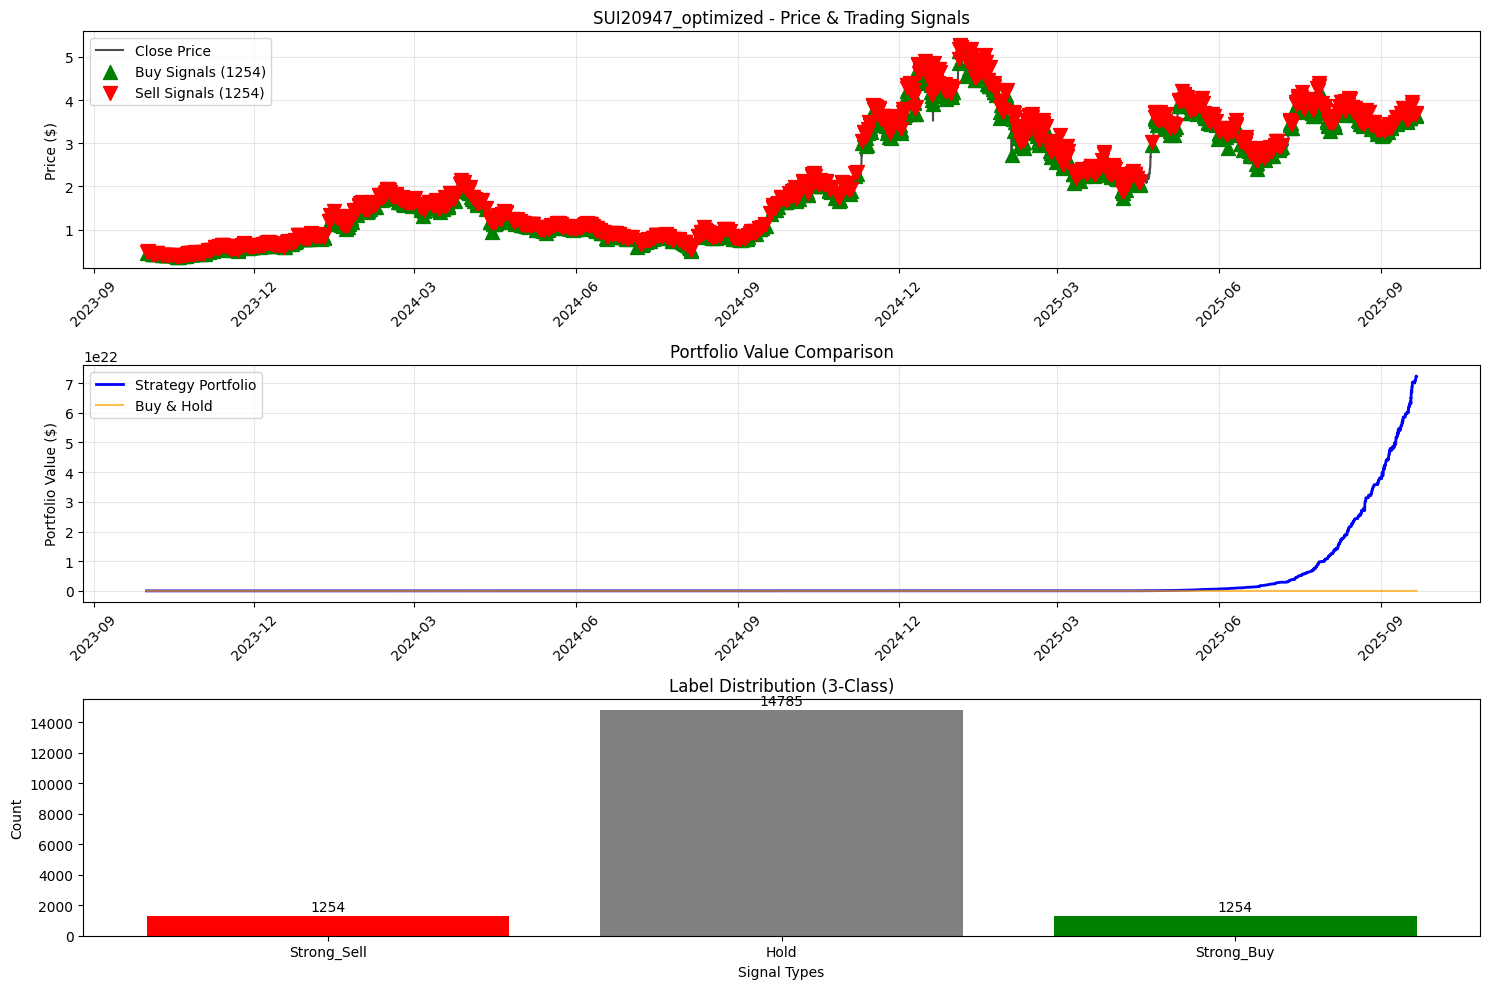


TON11419_optimized 백테스팅 결과:
전략 수익률: 3554751281402373.50%
Buy & Hold 수익률: 46.46%
초과 수익률: 3554751281402327.50%
샤프 비율: 0.34
최대 손실폭: -5.91%
총 거래 횟수: 2650회
승률: 99.92%
평균 거래수익률: 3.58%
최종 자산: $355,475,128,140,247,296


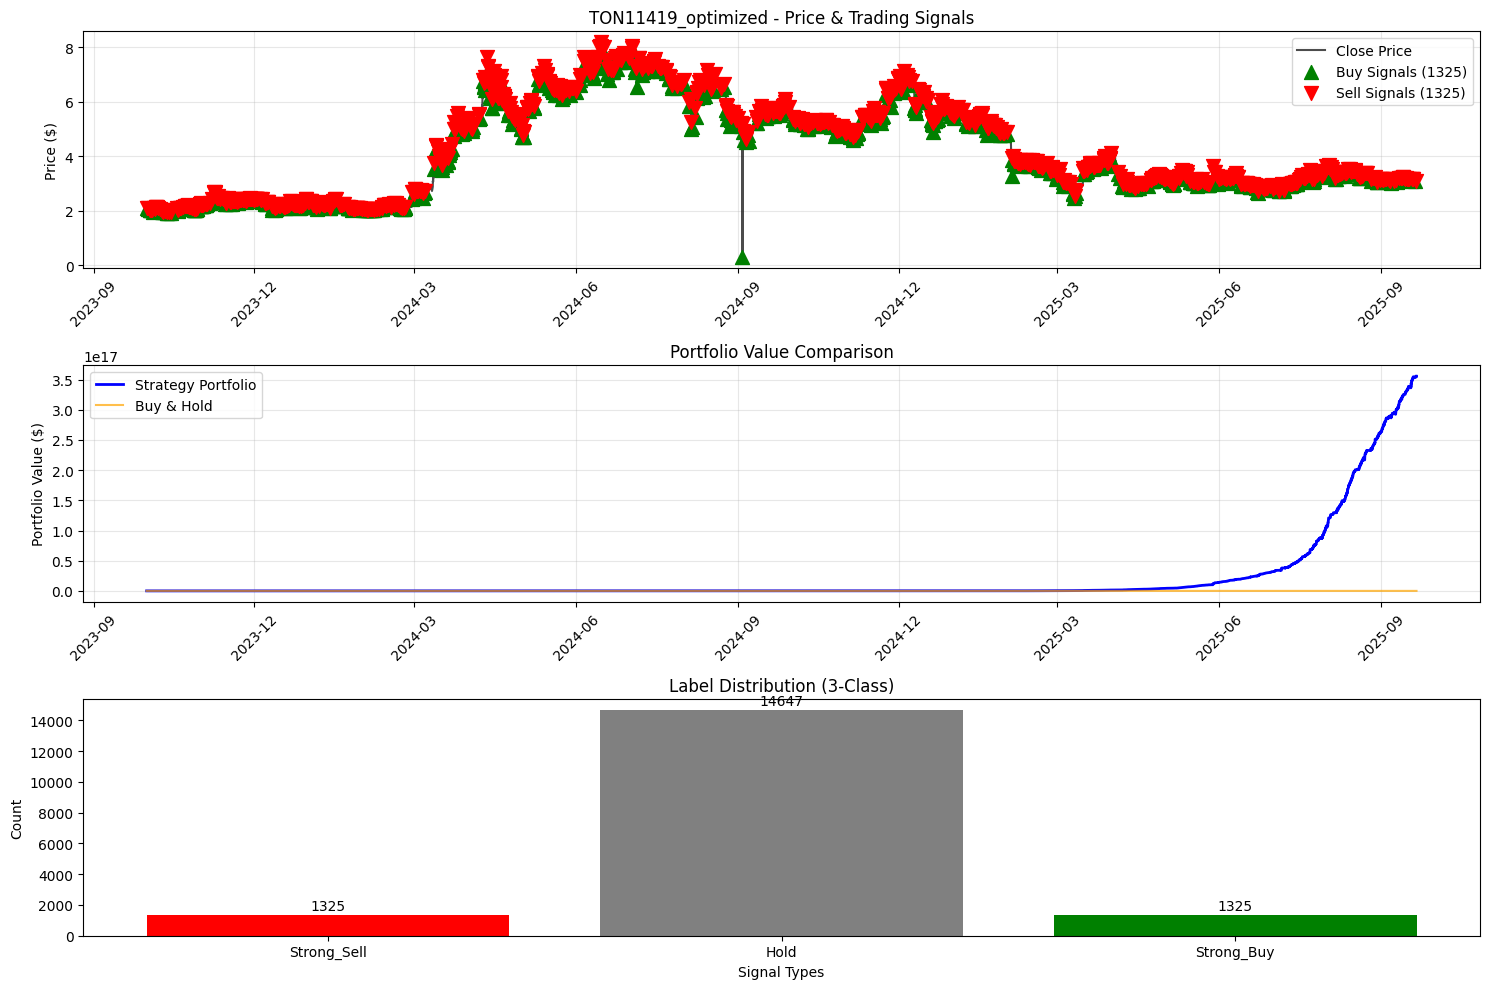


TRX_optimized 백테스팅 결과:
전략 수익률: 59912501.13%
Buy & Hold 수익률: 291.06%
초과 수익률: 59912210.07%
샤프 비율: 3.31
최대 손실폭: -3.82%
총 거래 횟수: 2042회
승률: 99.80%
평균 거래수익률: 1.57%
최종 자산: $5,991,260,113


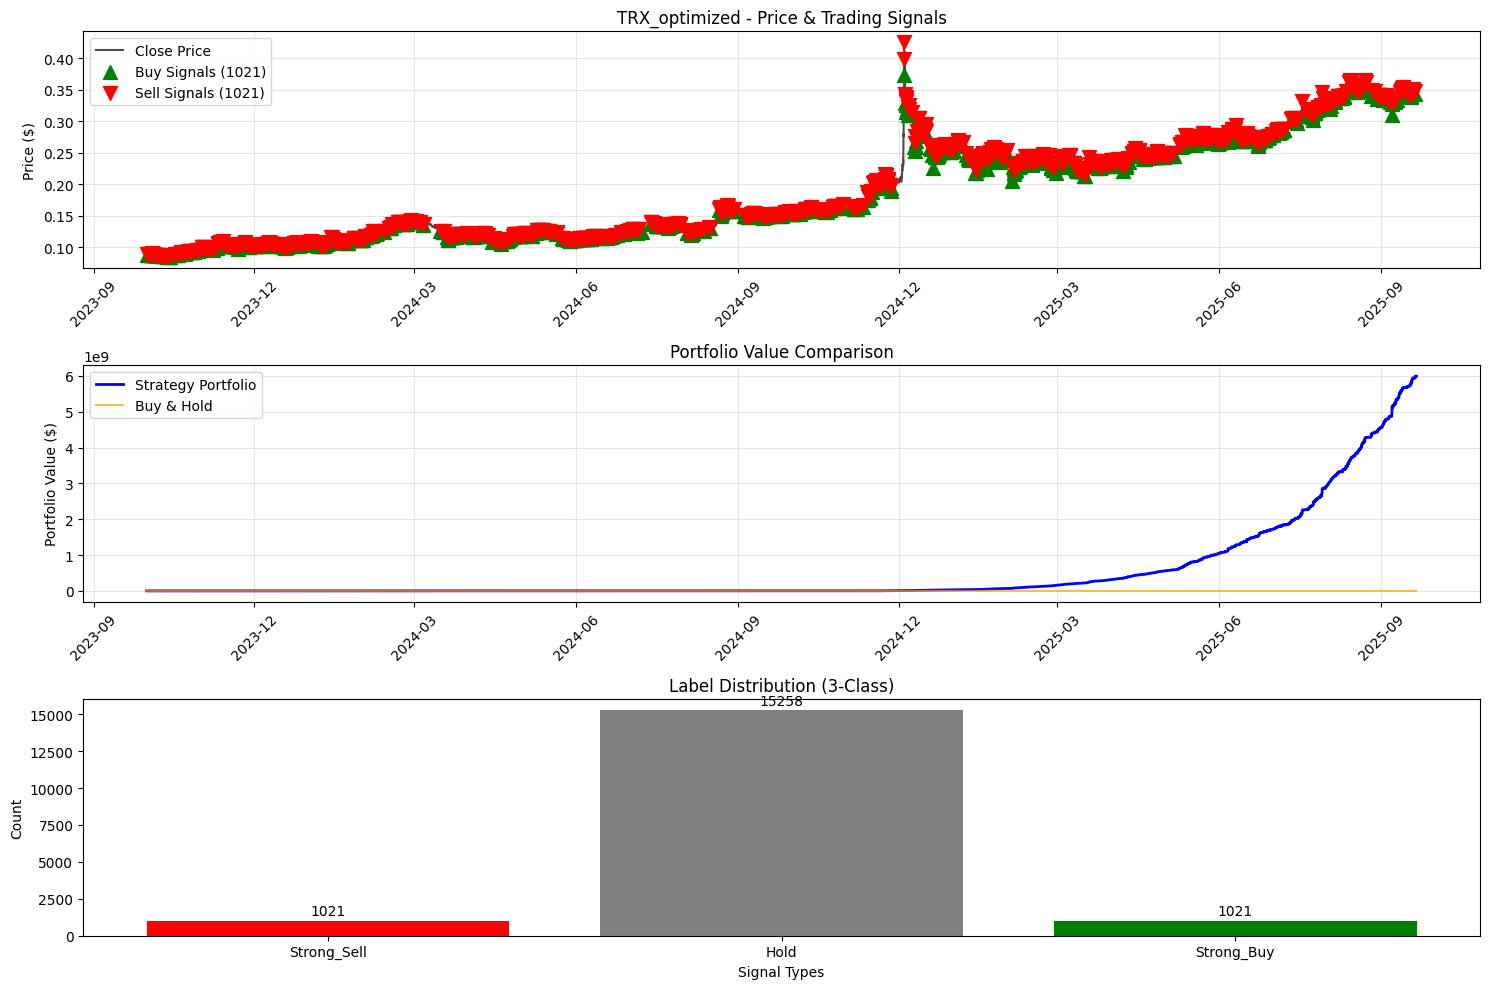


USDC_optimized 백테스팅 결과:
전략 수익률: -99.95%
Buy & Hold 수익률: -0.03%
초과 수익률: -99.92%
샤프 비율: -14.09
최대 손실폭: -99.95%
총 거래 횟수: 8438회
승률: 99.91%
평균 거래수익률: 0.02%
최종 자산: $5


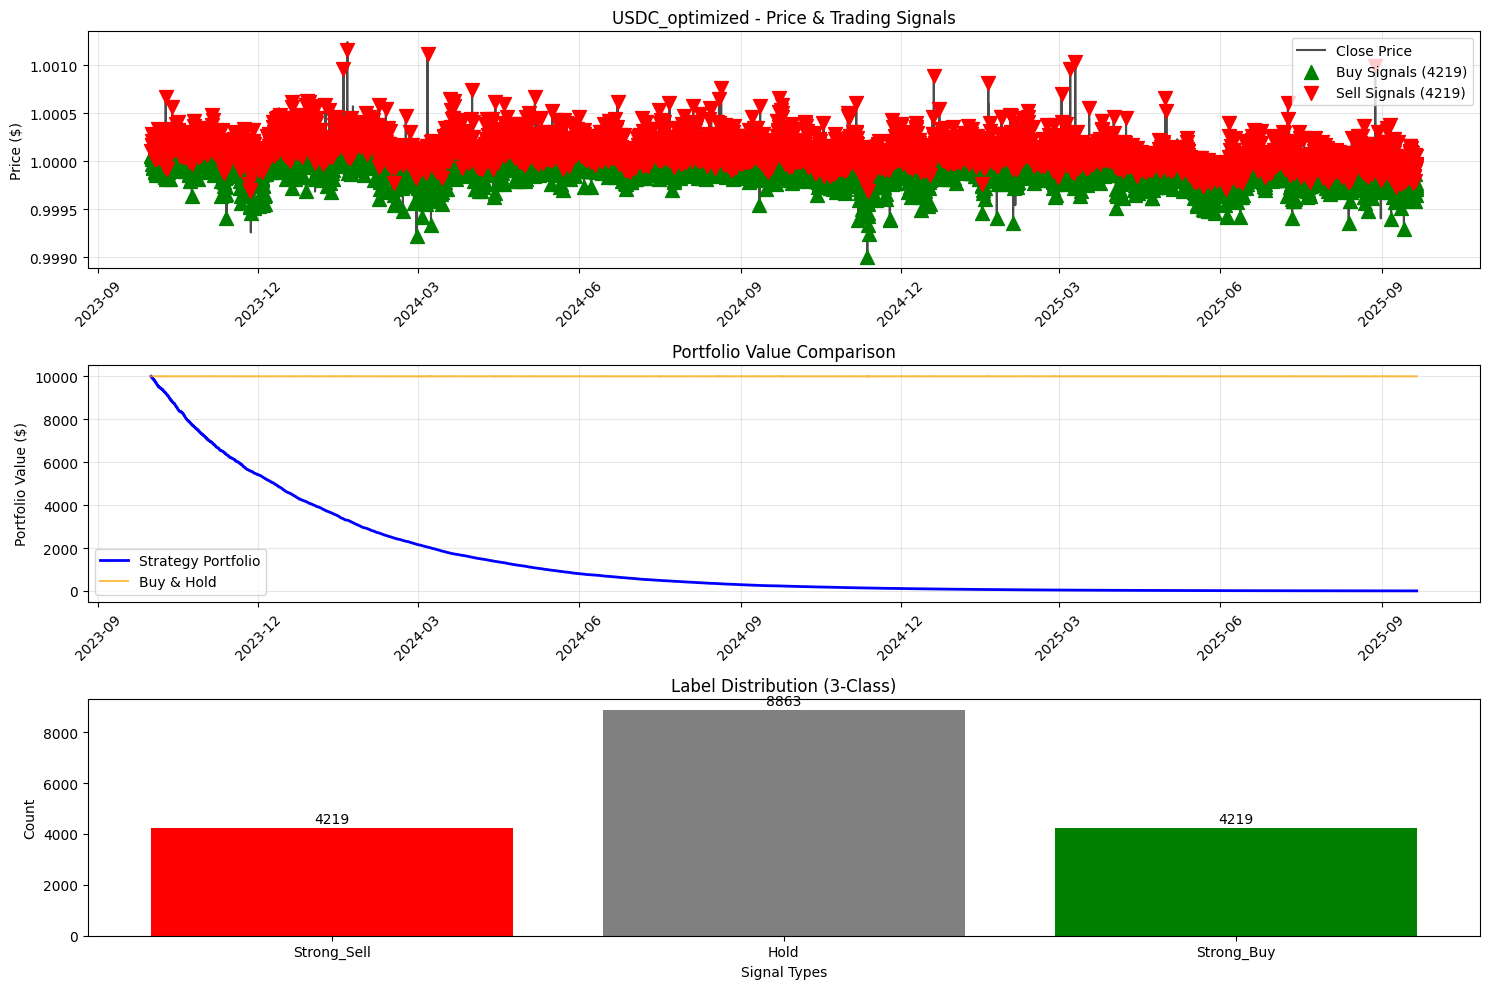


USDT_optimized 백테스팅 결과:
전략 수익률: -99.53%
Buy & Hold 수익률: 0.03%
초과 수익률: -99.56%
샤프 비율: -10.23
최대 손실폭: -99.53%
총 거래 횟수: 6218회
승률: 99.94%
평균 거래수익률: 0.03%
최종 자산: $47


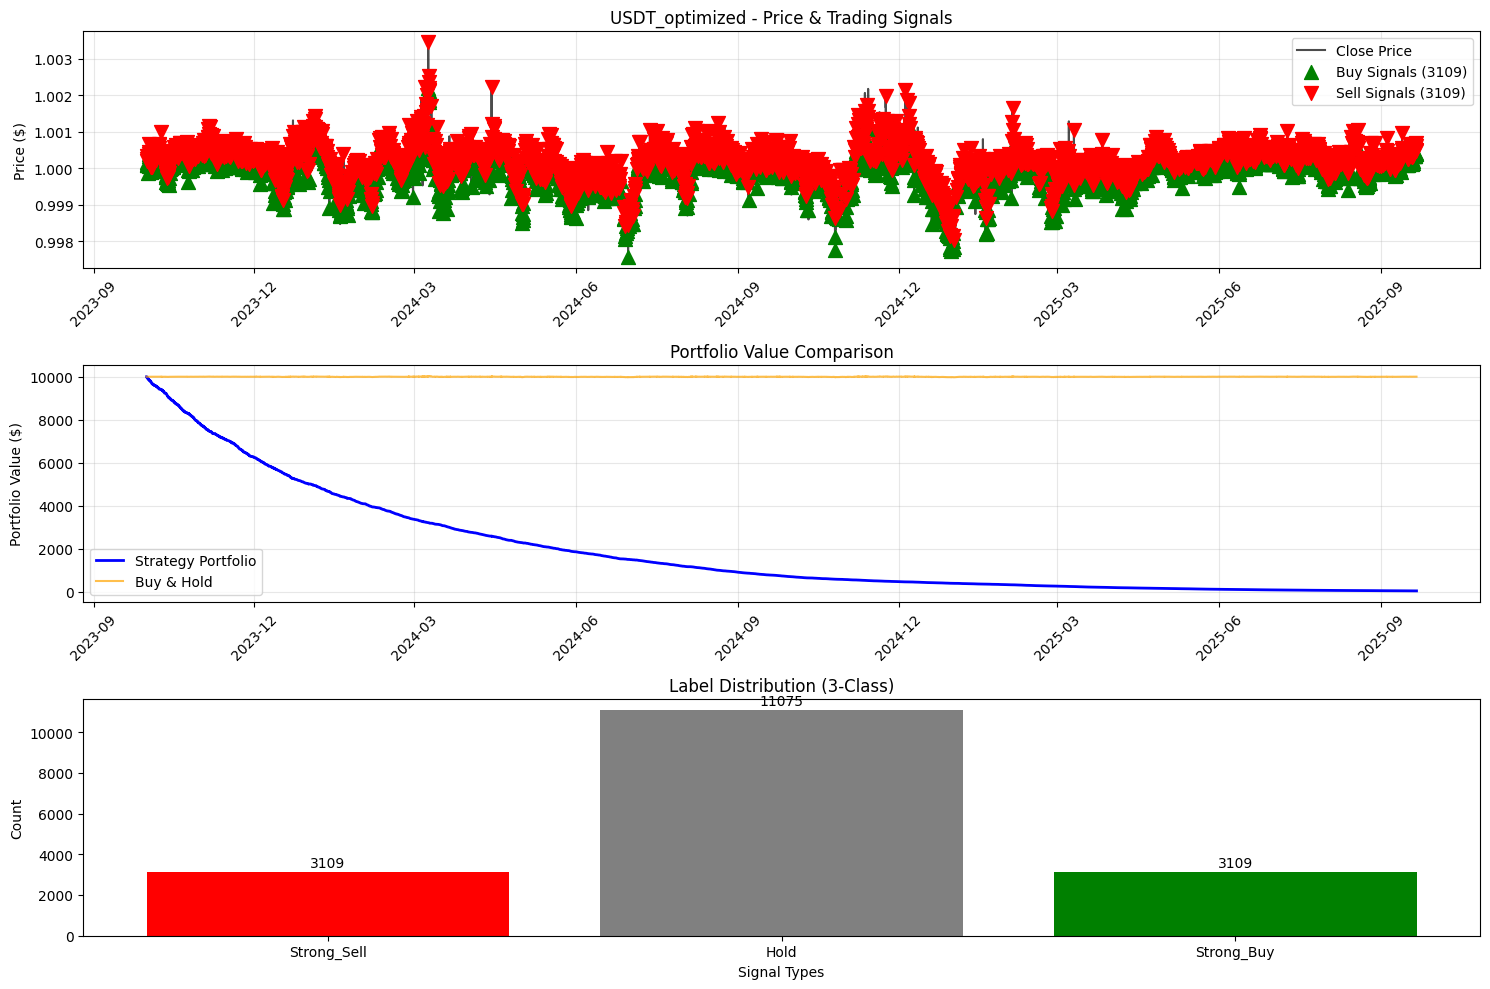


XLM_optimized 백테스팅 결과:
전략 수익률: 185931860185253.56%
Buy & Hold 수익률: 243.10%
초과 수익률: 185931860185010.44%
샤프 비율: 3.72
최대 손실폭: -9.99%
총 거래 횟수: 2666회
승률: 99.62%
평균 거래수익률: 2.45%
최종 자산: $18,593,186,018,535,356


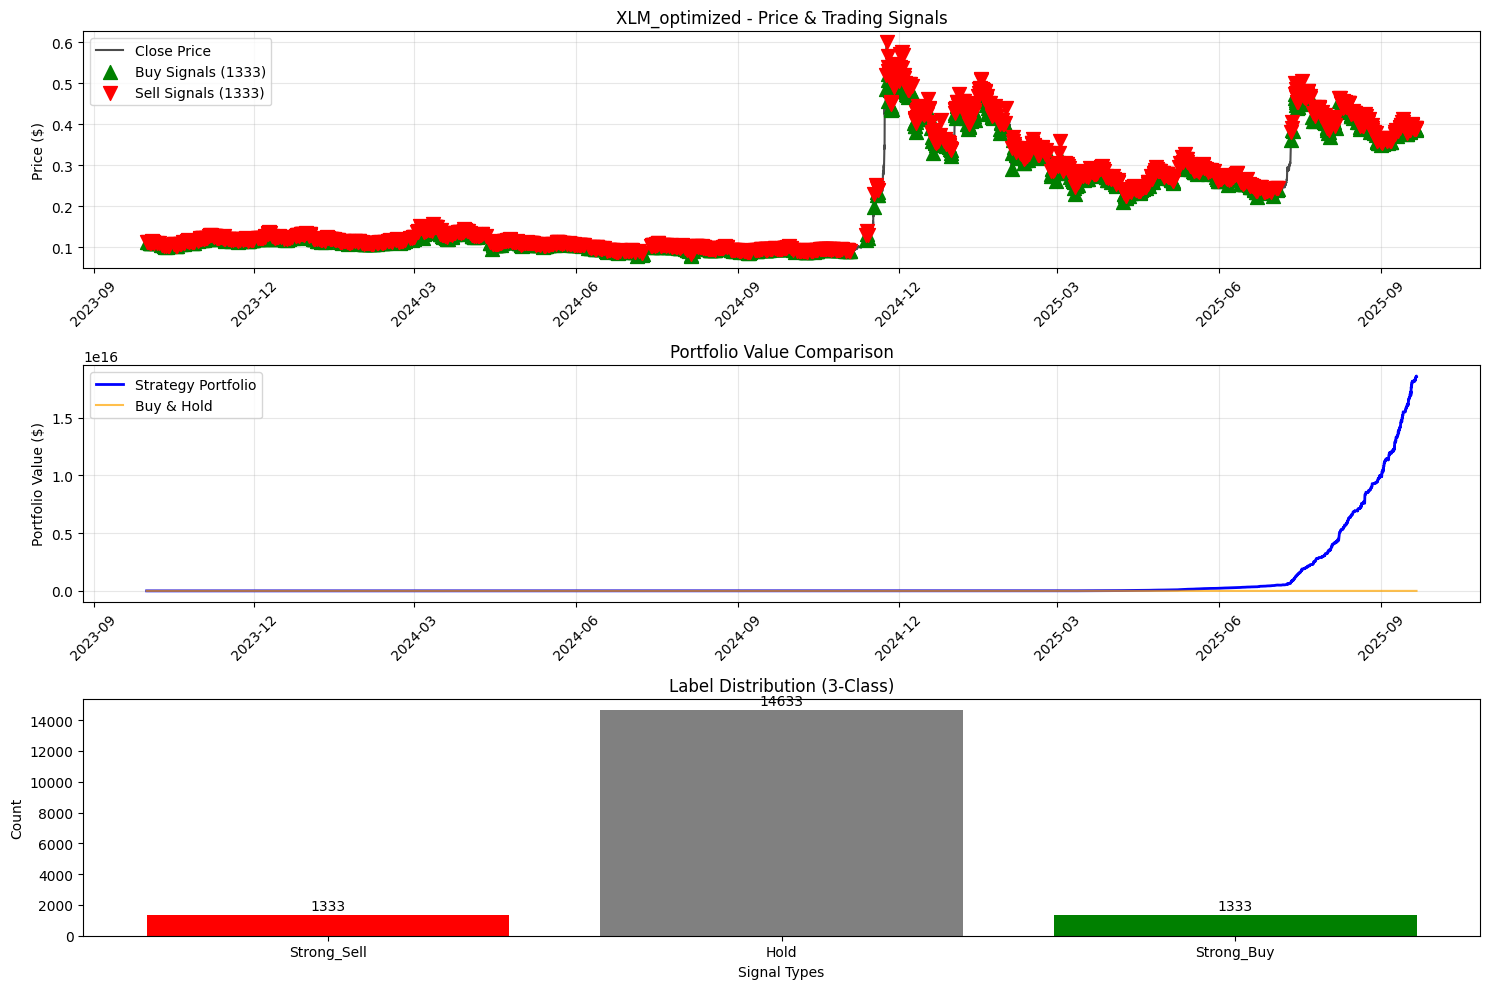


XRP_optimized 백테스팅 결과:
전략 수익률: 70428064300616.59%
Buy & Hold 수익률: 477.23%
초과 수익률: 70428064300139.38%
샤프 비율: 3.86
최대 손실폭: -7.44%
총 거래 횟수: 2632회
승률: 99.77%
평균 거래수익률: 2.36%
최종 자산: $7,042,806,430,071,659


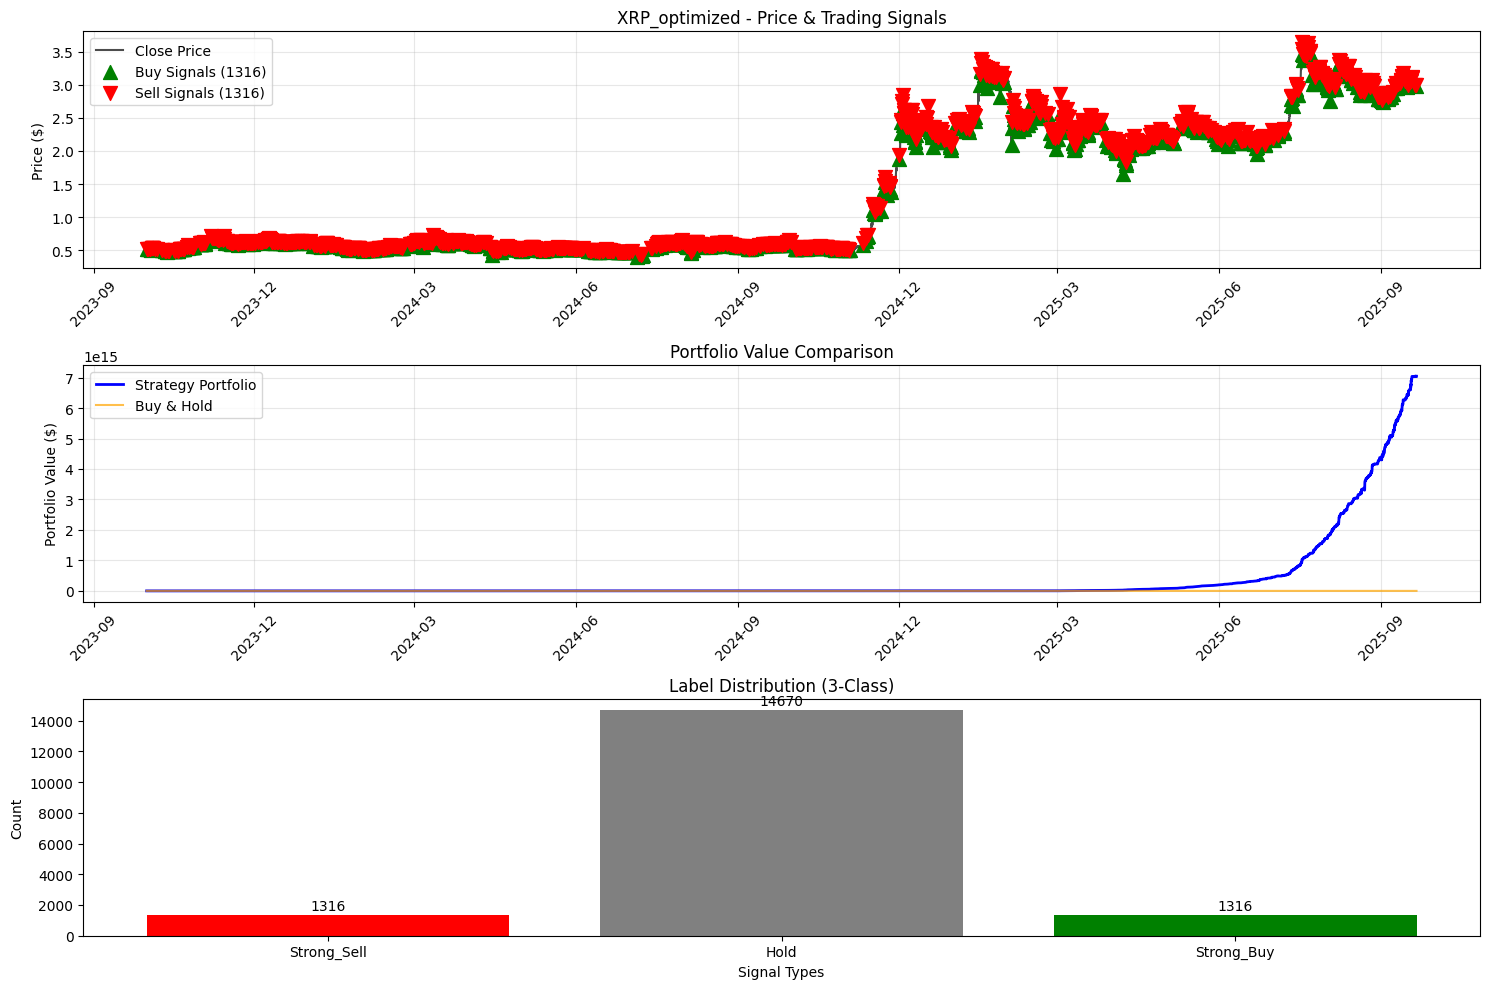


전체 백테스팅 결과 요약:
            Symbol            Total_Return           Excess_Return  Sharpe_Ratio  Win_Rate  Num_Trades
     ADA_optimized      87440984550481.875      87440984550479.359         4.101     0.998        2470
    AVAX_optimized    5379874451003327.000    5379874451003324.000         4.677     0.998        2454
     BCH_optimized       1495482229972.515       1495482229971.005         4.107     0.996        2614
     BNB_optimized           185279388.946           185279385.096         4.380     0.998        2544
     BTC_optimized             7298972.979             7298969.692         4.147     0.999        2514
     CRO_optimized      81135152605744.297      81135152605740.781         3.717     0.997        2560
    DOGE_optimized     538686693958238.312     538686693958235.000         4.237     0.998        2318
     ETH_optimized          4166549752.061          4166549750.383         4.352     0.998        2478
    HBAR_optimized   11279093656069740.000   112790936560

In [2]:

save_path_1 = "/workspace/AI모델/projects/coin/data/1h/labeling/01" 

# 실행 코드
if __name__ == "__main__":
    # 개별 종목 백테스팅 실행 (기간 설정 포함)
    backtester = run_individual_backtest(
        data_path=save_path_1,
        start_date='2023-10-01',    # 백테스팅 시작 날짜
        end_date='2025-09-21',      # 백테스팅 종료 날짜
        max_stocks=20,               # 처음 3개 종목만 테스트
        initial_capital=10000       # 초기 투자 금액
    )
    
    # 특정 종목만 테스트하려면:
    # backtester = run_individual_backtest(
    #     data_path=data_path,
    #     start_date='2005-01-01',
    #     end_date='2010-12-31',
    #     symbols=['AAPL', 'MSFT'],  # 원하는 종목 코드
    #     initial_capital=50000
    # )

# 월별 백테스팅 실행

월별 백테스팅 시작

2025년 8월 백테스팅 실행 중...
파일 패턴 발견: *_optimized.csv (20개)
CSV 파일 로딩 중... (20개)


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


로딩 완료: 20개 종목

Backtesting Period: 2025-08-01 to 2025-08-31
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 10 stocks...

ADA_optimized 백테스팅 결과:
전략 수익률: 307.36%
Buy & Hold 수익률: 14.28%
초과 수익률: 293.07%
샤프 비율: 4.56
최대 손실폭: -3.22%
총 거래 횟수: 104회
승률: 100.00%
평균 거래수익률: 3.01%
최종 자산: $40,736


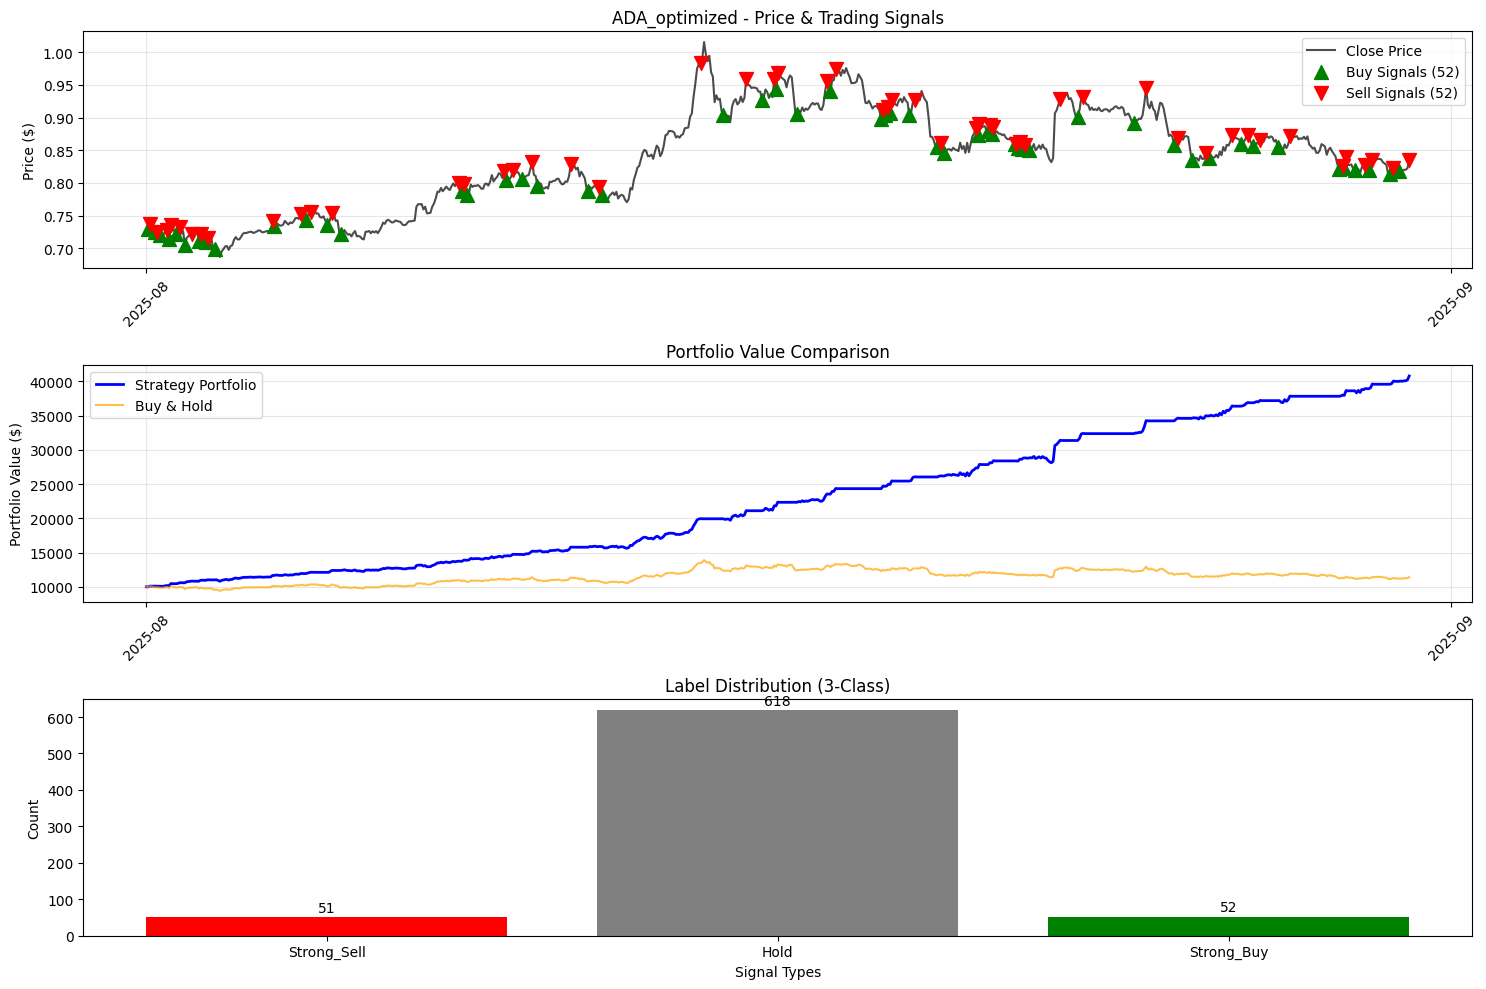


AVAX_optimized 백테스팅 결과:
전략 수익률: 258.02%
Buy & Hold 수익률: 8.34%
초과 수익률: 249.67%
샤프 비율: 4.95
최대 손실폭: -2.94%
총 거래 횟수: 110회
승률: 100.00%
평균 거래수익률: 2.57%
최종 자산: $35,802


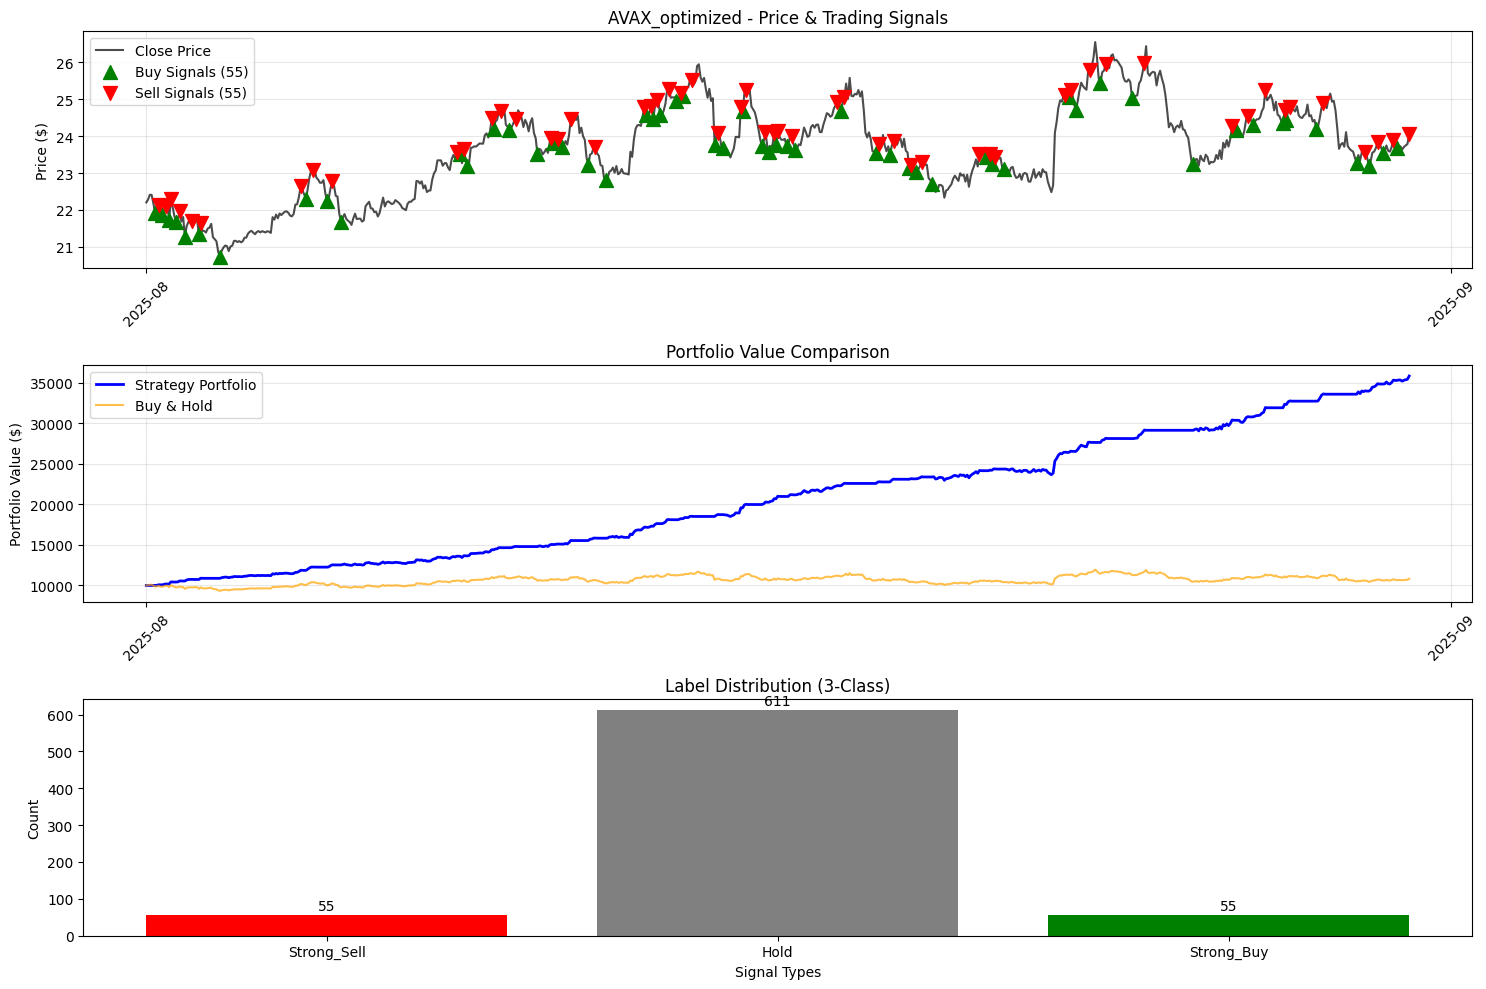


BCH_optimized 백테스팅 결과:
전략 수익률: 135.32%
Buy & Hold 수익률: -1.25%
초과 수익률: 136.57%
샤프 비율: 4.08
최대 손실폭: -1.42%
총 거래 횟수: 102회
승률: 100.00%
평균 거래수익률: 1.91%
최종 자산: $23,532


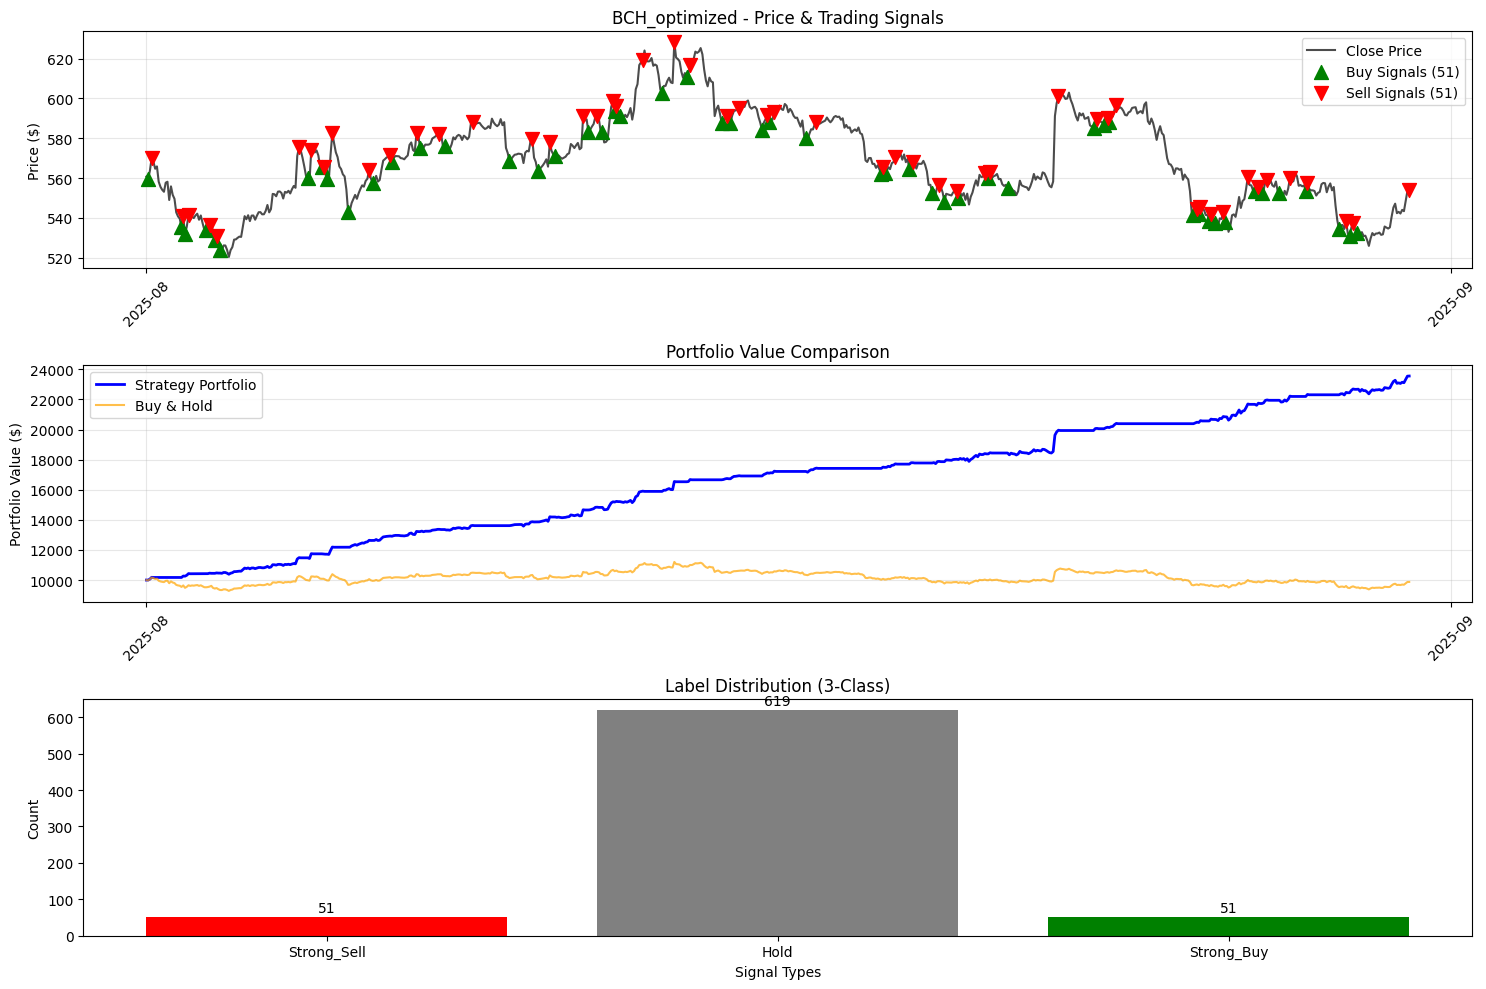


BNB_optimized 백테스팅 결과:
전략 수익률: 111.45%
Buy & Hold 수익률: 9.78%
초과 수익률: 101.67%
샤프 비율: 4.96
최대 손실폭: -1.37%
총 거래 횟수: 108회
승률: 100.00%
평균 거래수익률: 1.61%
최종 자산: $21,145


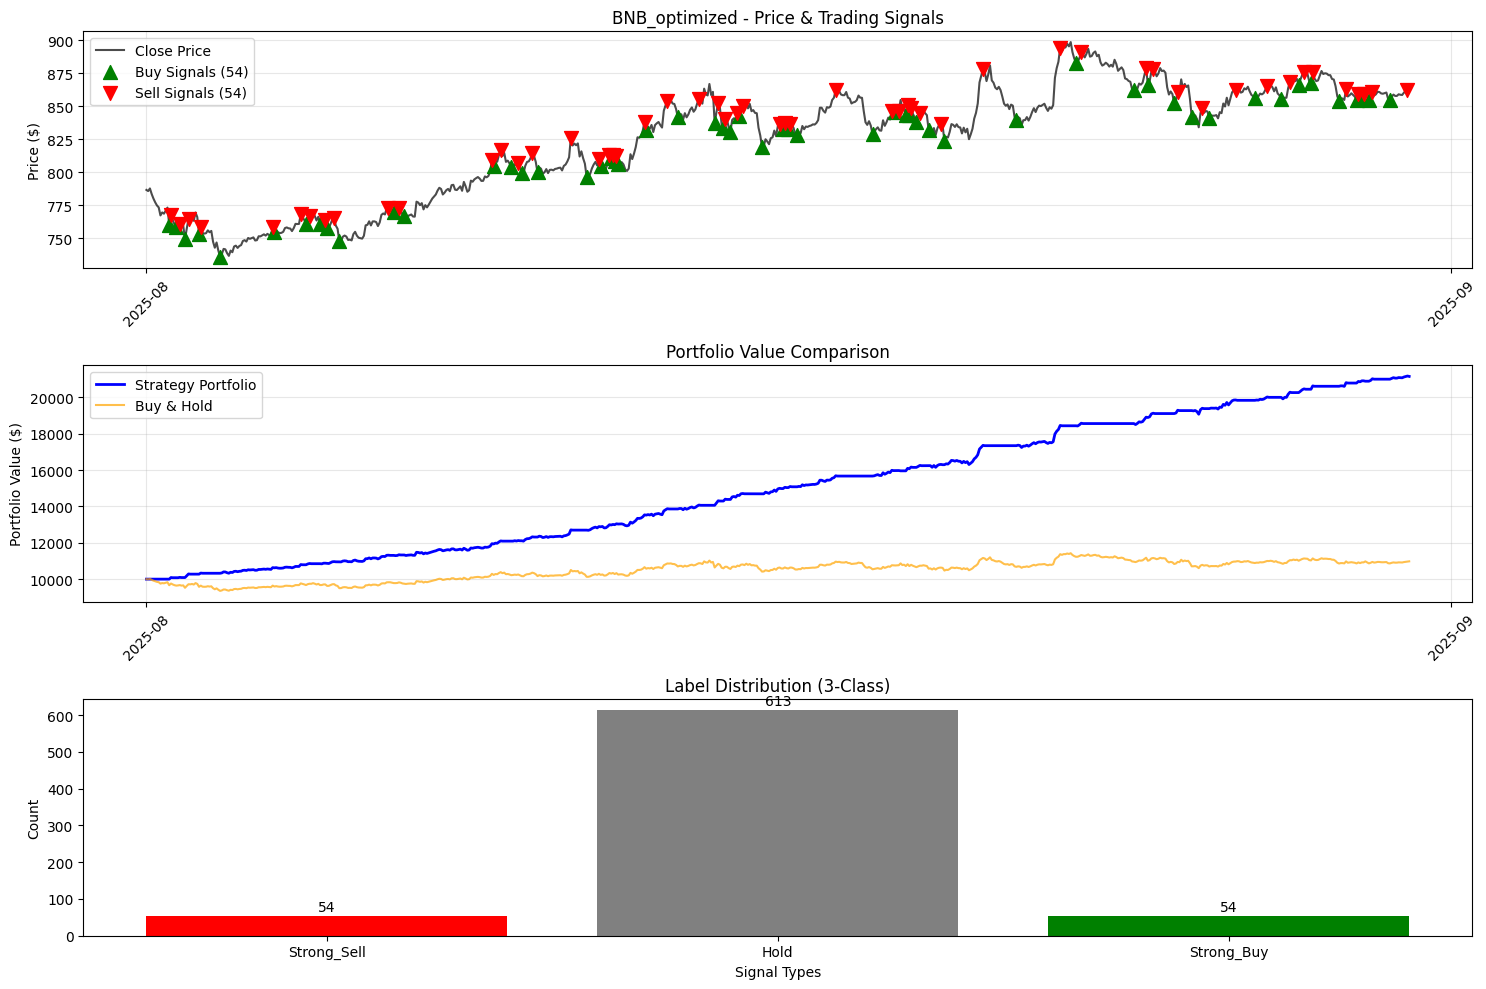


BTC_optimized 백테스팅 결과:
전략 수익률: 42.86%
Buy & Hold 수익률: -5.26%
초과 수익률: 48.12%
샤프 비율: 3.53
최대 손실폭: -0.81%
총 거래 횟수: 100회
승률: 100.00%
평균 거래수익률: 0.92%
최종 자산: $14,286


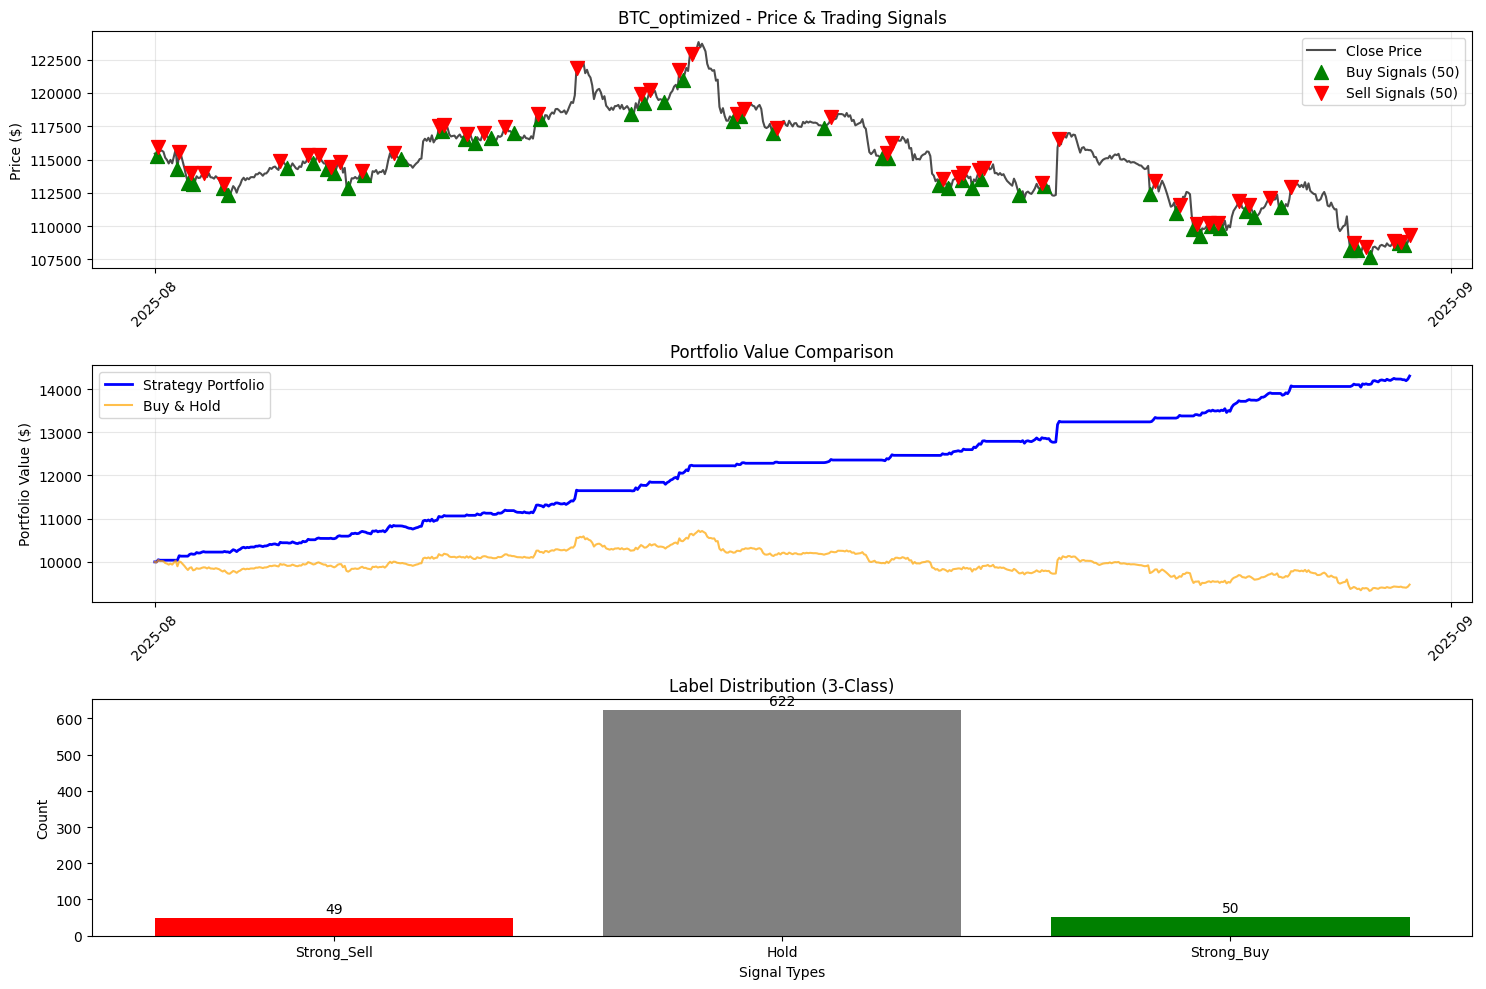


CRO_optimized 백테스팅 결과:
전략 수익률: 802.58%
Buy & Hold 수익률: 120.07%
초과 수익률: 682.51%
샤프 비율: 3.00
최대 손실폭: -8.03%
총 거래 횟수: 80회
승률: 100.00%
평균 거래수익률: 6.72%
최종 자산: $90,258


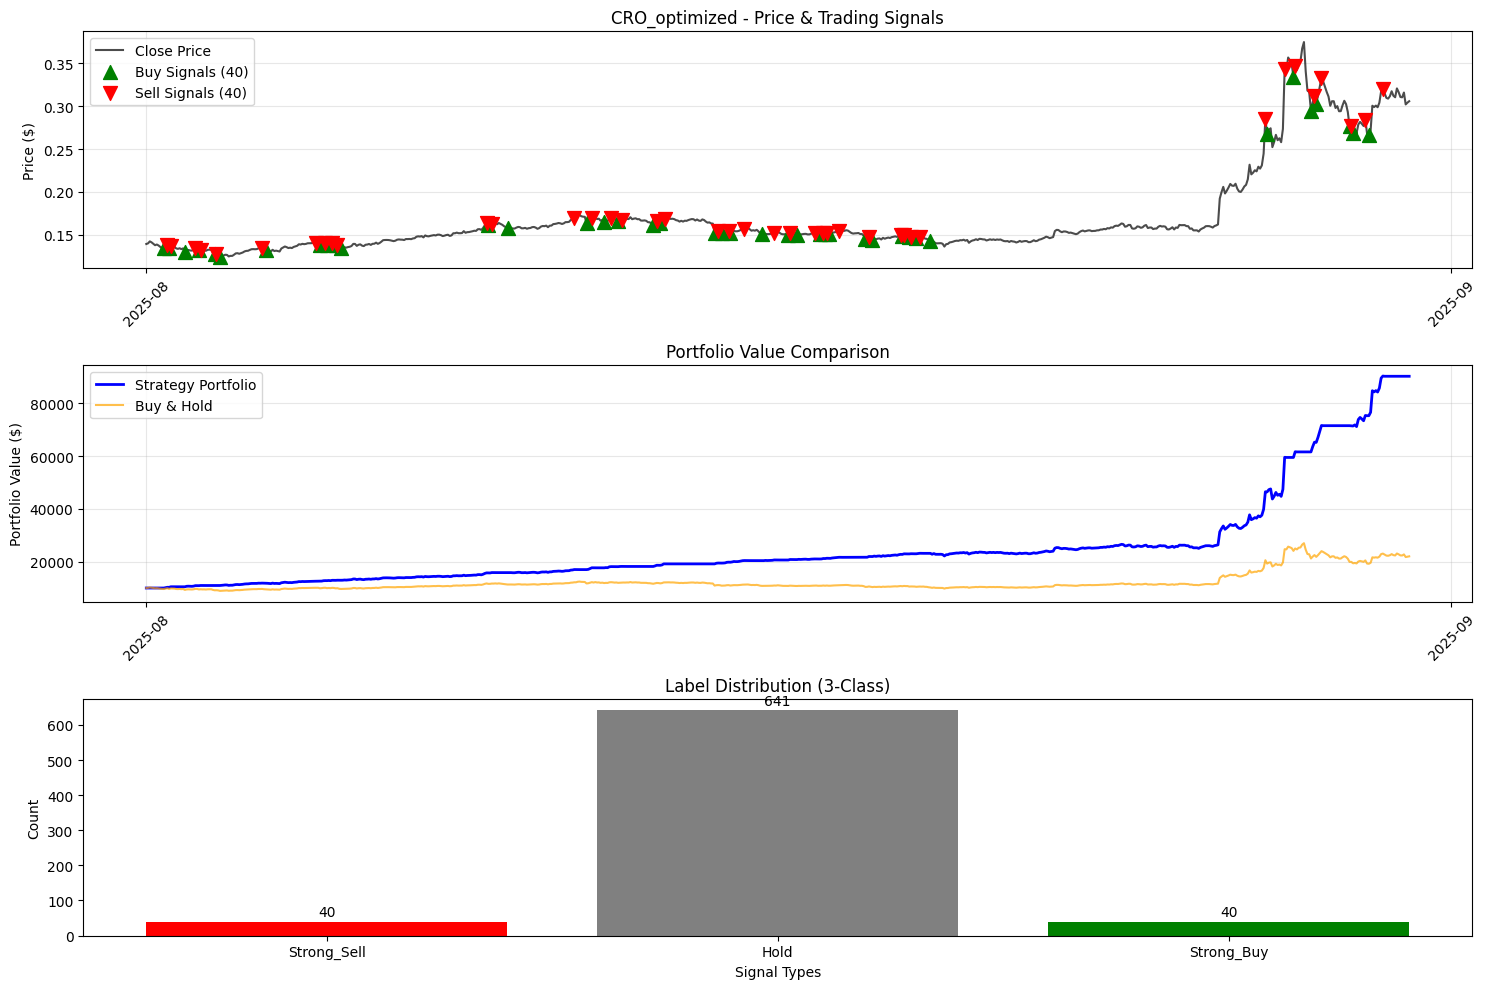


DOGE_optimized 백테스팅 결과:
전략 수익률: 249.65%
Buy & Hold 수익률: 5.31%
초과 수익률: 244.33%
샤프 비율: 4.31
최대 손실폭: -3.40%
총 거래 횟수: 98회
승률: 100.00%
평균 거래수익률: 2.84%
최종 자산: $34,965


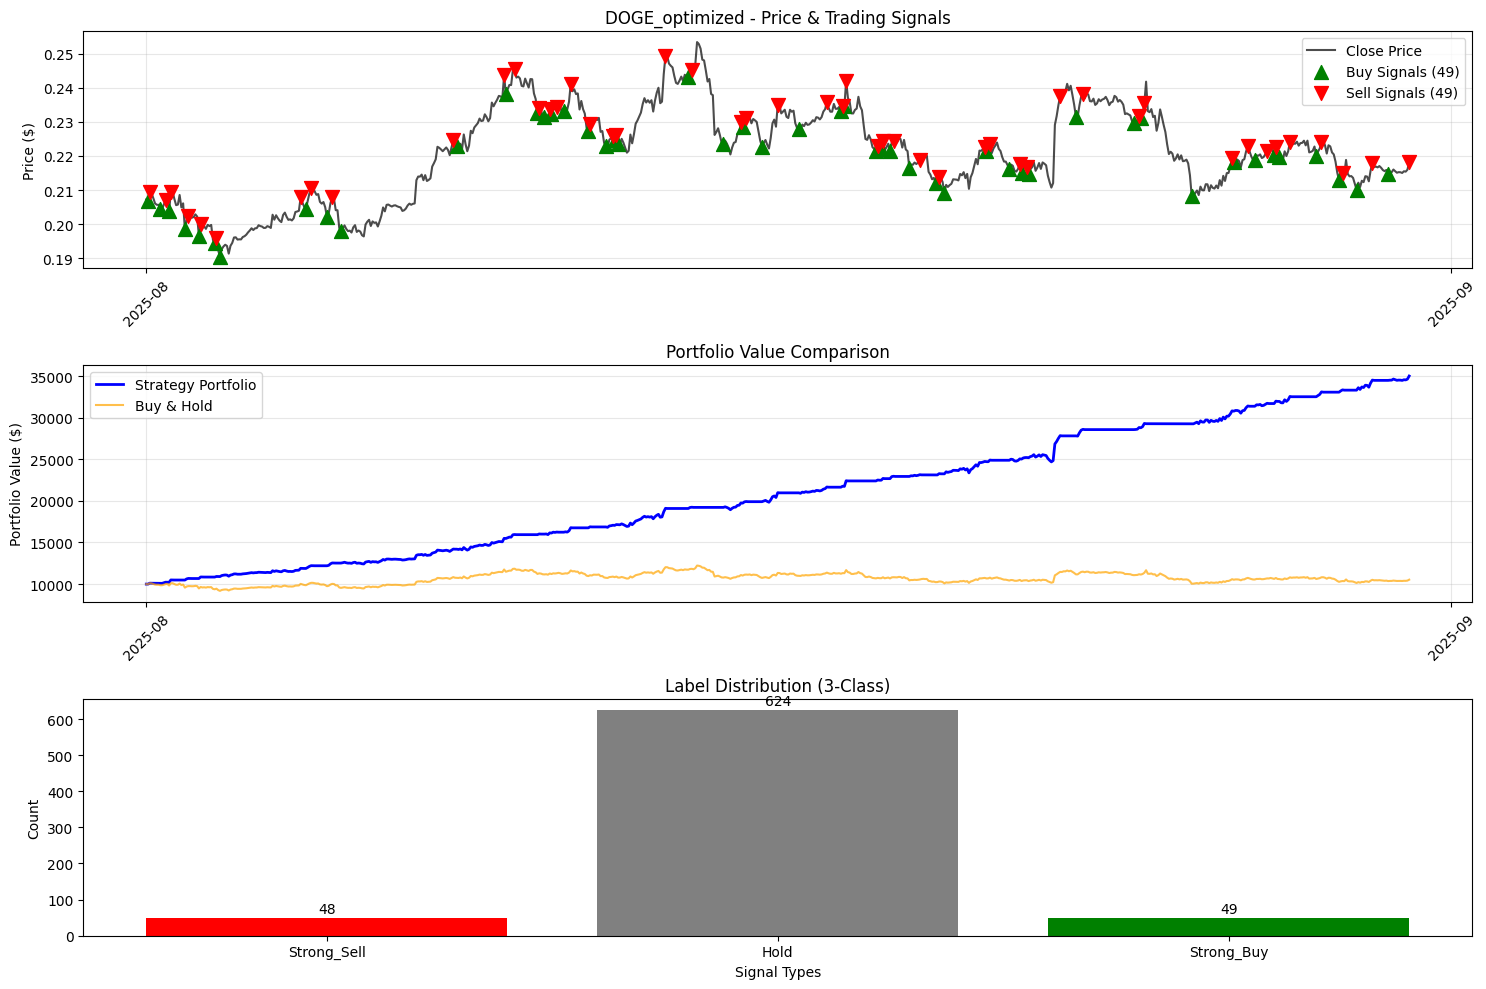


ETH_optimized 백테스팅 결과:
전략 수익률: 193.47%
Buy & Hold 수익률: 20.98%
초과 수익률: 172.49%
샤프 비율: 4.30
최대 손실폭: -2.23%
총 거래 횟수: 104회
승률: 100.00%
평균 거래수익률: 2.35%
최종 자산: $29,347


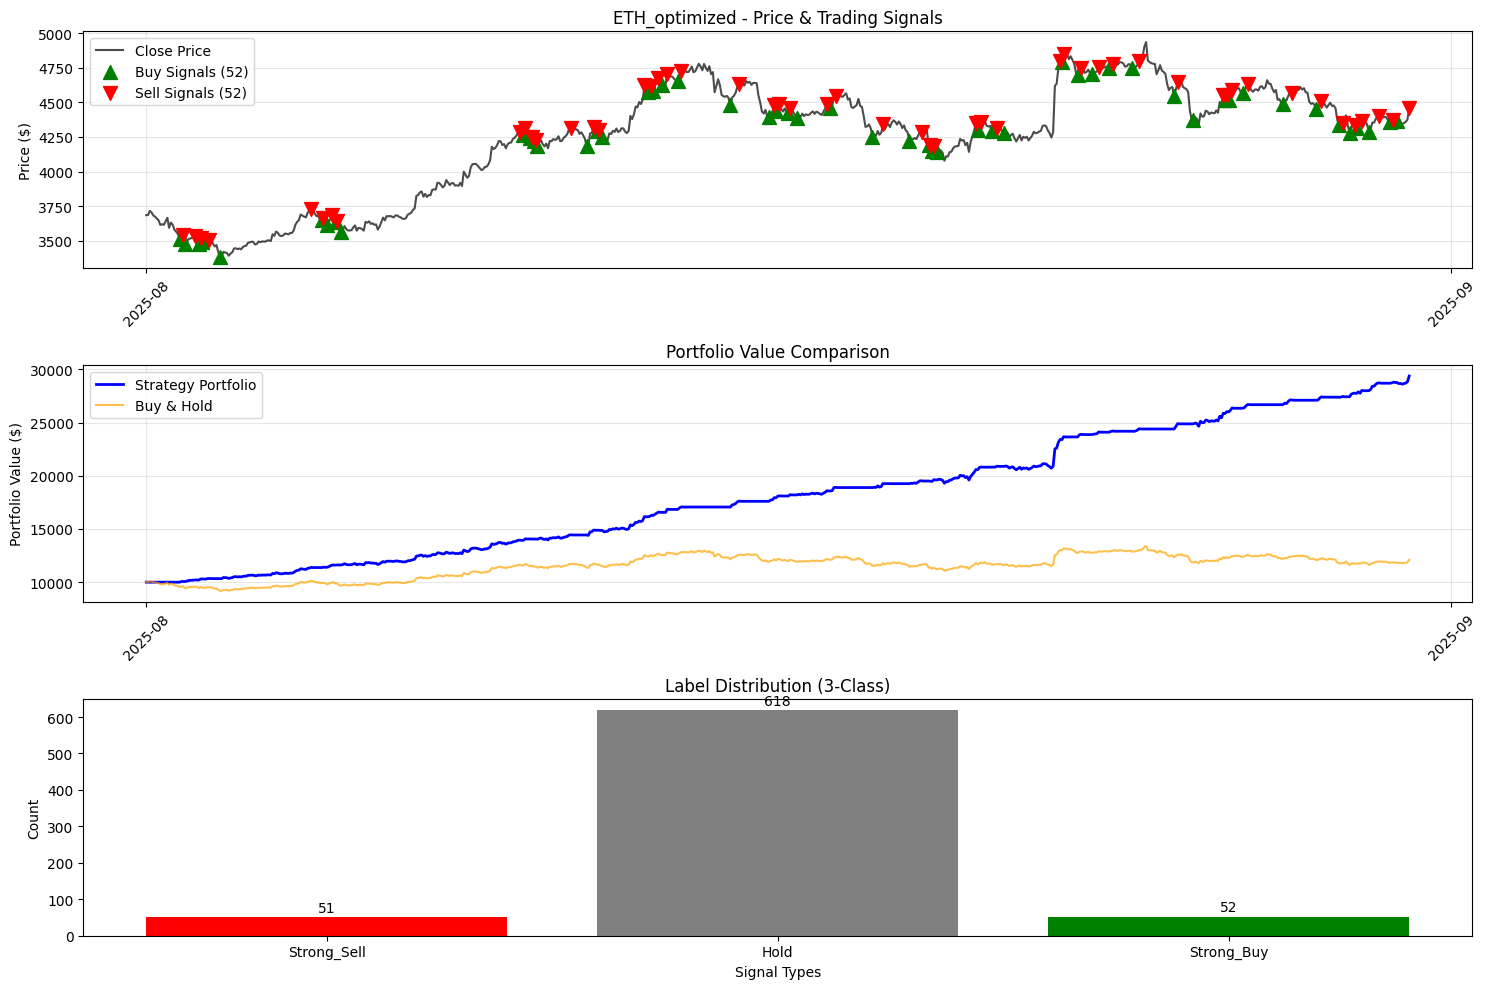


HBAR_optimized 백테스팅 결과:
전략 수익률: 228.23%
Buy & Hold 수익률: -8.67%
초과 수익률: 236.91%
샤프 비율: 4.60
최대 손실폭: -2.99%
총 거래 횟수: 126회
승률: 100.00%
평균 거래수익률: 2.13%
최종 자산: $32,823


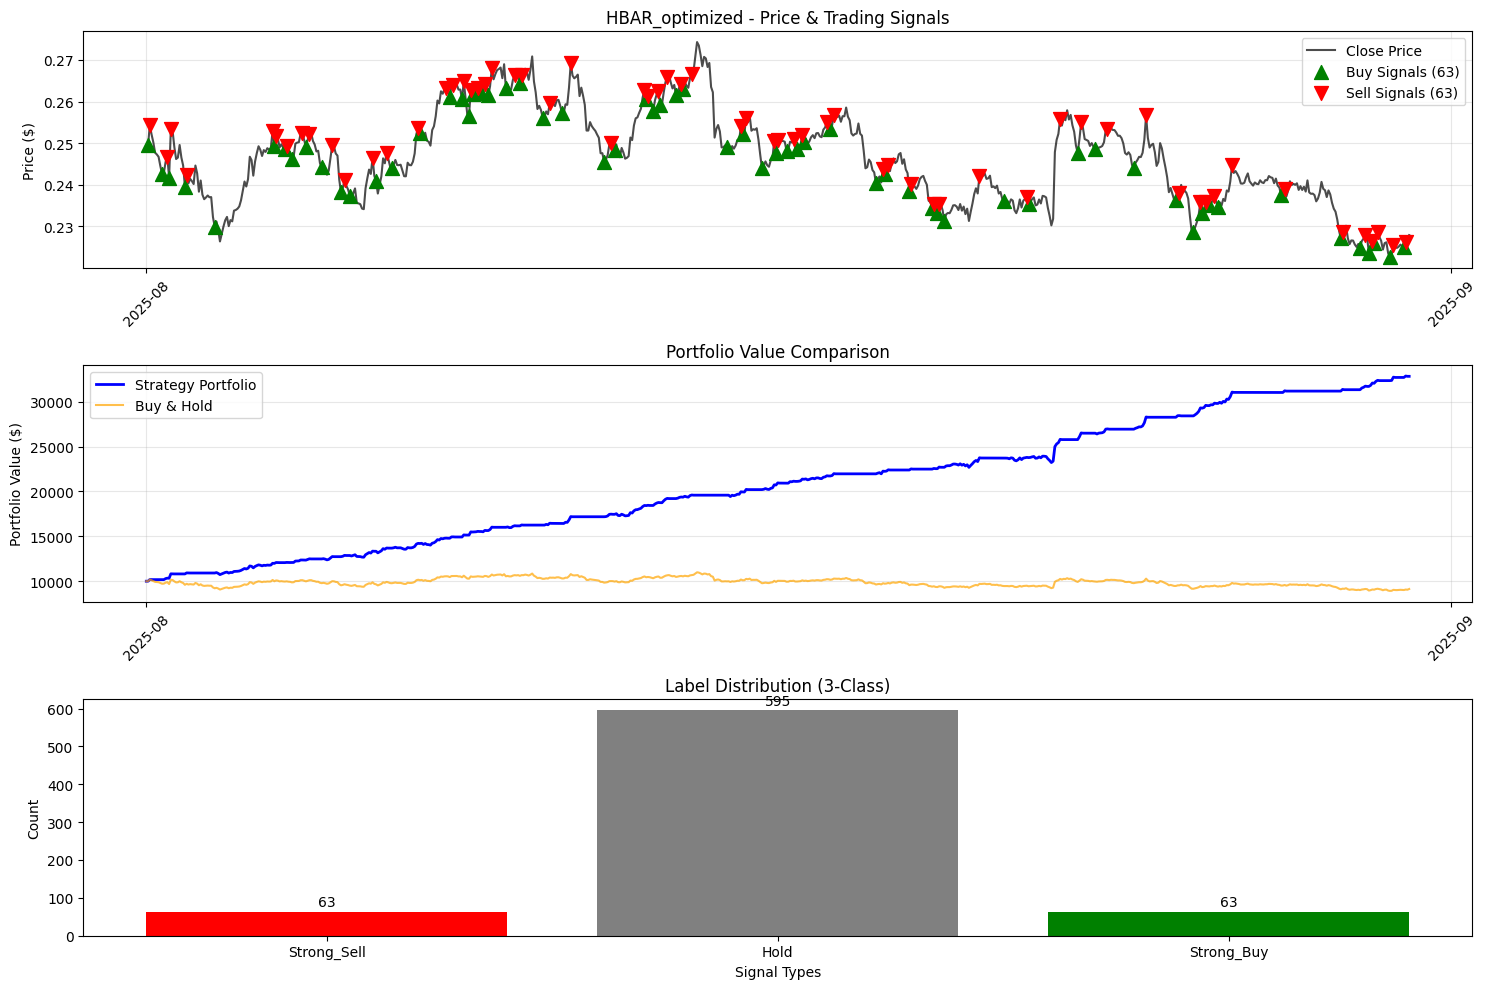


LEO_optimized 백테스팅 결과:
전략 수익률: 29.08%
Buy & Hold 수익률: 6.57%
초과 수익률: 22.51%
샤프 비율: 3.68
최대 손실폭: -0.70%
총 거래 횟수: 102회
승률: 100.00%
평균 거래수익률: 0.71%
최종 자산: $12,908


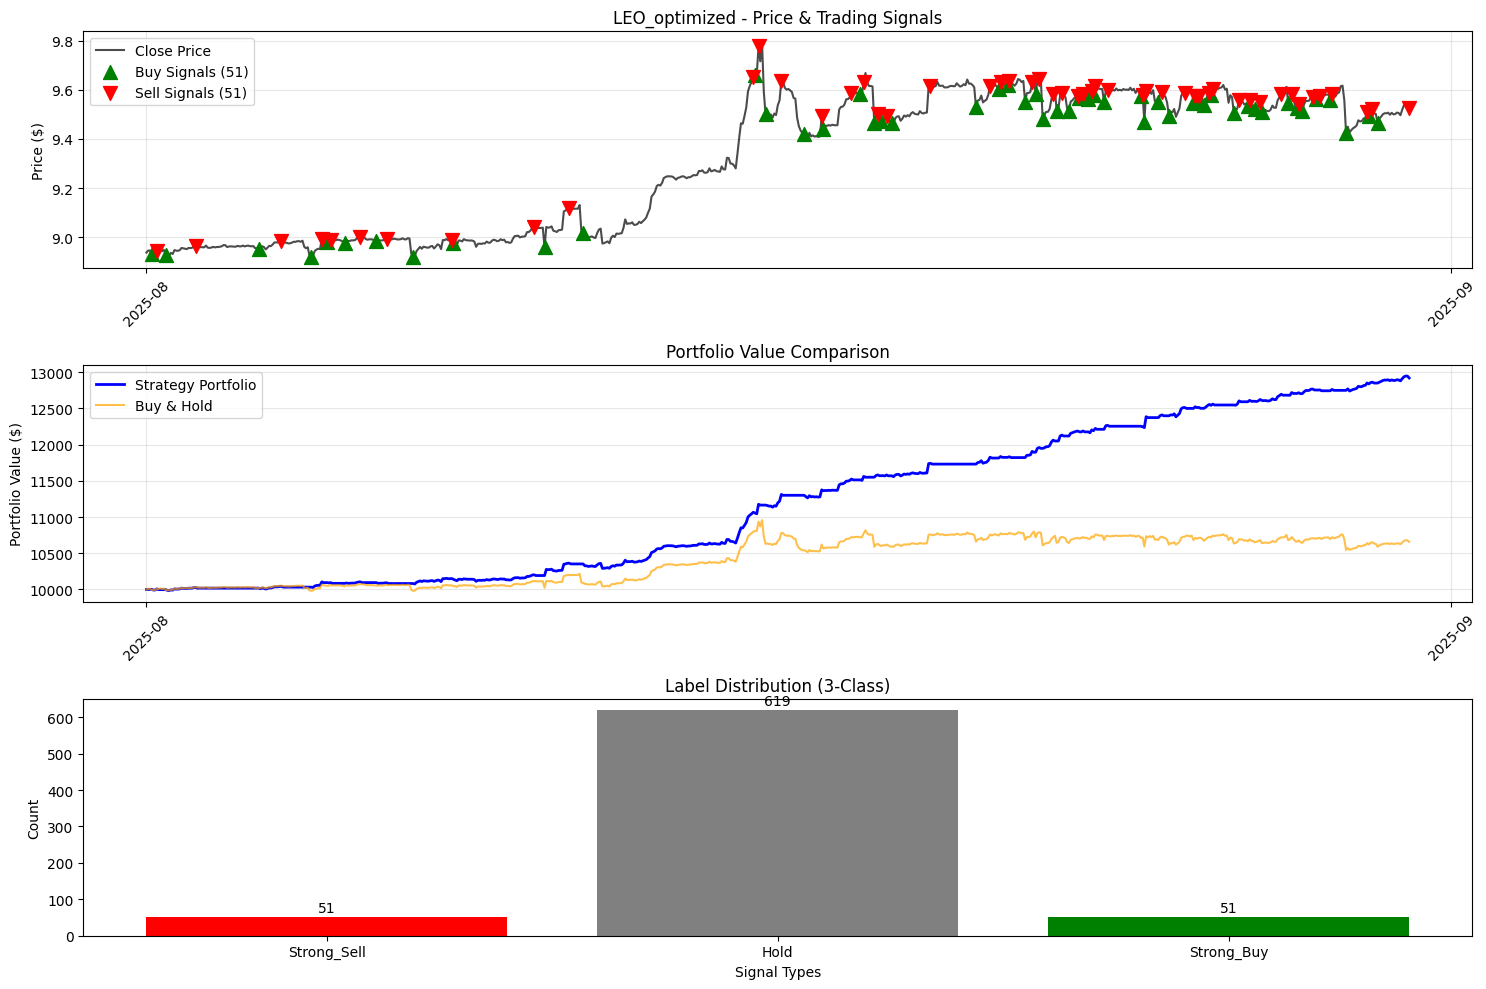


전체 백테스팅 결과 요약:
        Symbol  Total_Return  Excess_Return  Sharpe_Ratio  Win_Rate  Num_Trades
 ADA_optimized         3.074          2.931         4.559     1.000         104
AVAX_optimized         2.580          2.497         4.952     1.000         110
 BCH_optimized         1.353          1.366         4.081     1.000         102
 BNB_optimized         1.115          1.017         4.956     1.000         108
 BTC_optimized         0.429          0.481         3.529     1.000         100
 CRO_optimized         8.026          6.825         2.998     1.000          80
DOGE_optimized         2.496          2.443         4.309     1.000          98
 ETH_optimized         1.935          1.725         4.303     1.000         104
HBAR_optimized         2.282          2.369         4.598     1.000         126
 LEO_optimized         0.291          0.225         3.678     1.000         102

평균 통계:
평균 수익률: 235.80%
평균 초과수익률: 218.78%
평균 샤프비율: 4.20
평균 승률: 100.00%
2025년 8월 백테스팅 완료

2025년 9월 백테스팅 실

100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


로딩 완료: 20개 종목

Backtesting Period: 2025-09-01 to 2025-09-30
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 10 stocks...

ADA_optimized 백테스팅 결과:
전략 수익률: 76.66%
Buy & Hold 수익률: 10.67%
초과 수익률: 65.99%
샤프 비율: 4.22
최대 손실폭: -1.86%
총 거래 횟수: 60회
승률: 100.00%
평균 거래수익률: 2.13%
최종 자산: $17,666


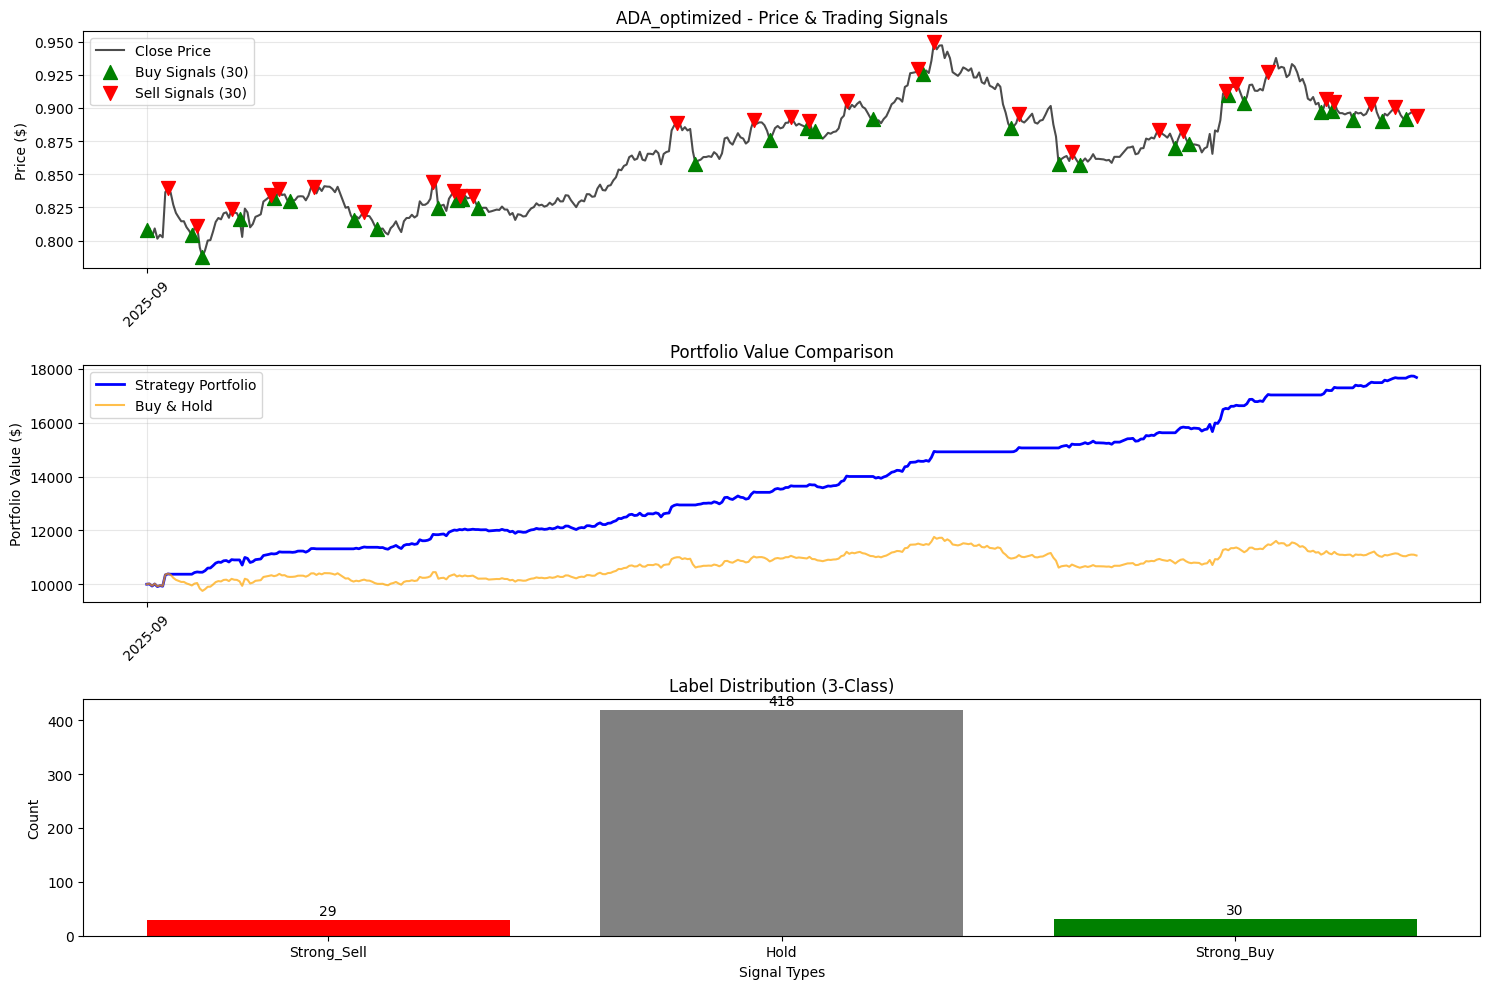


AVAX_optimized 백테스팅 결과:
전략 수익률: 138.61%
Buy & Hold 수익률: 41.70%
초과 수익률: 96.92%
샤프 비율: 4.14
최대 손실폭: -2.79%
총 거래 횟수: 44회
승률: 100.00%
평균 거래수익률: 4.35%
최종 자산: $23,861


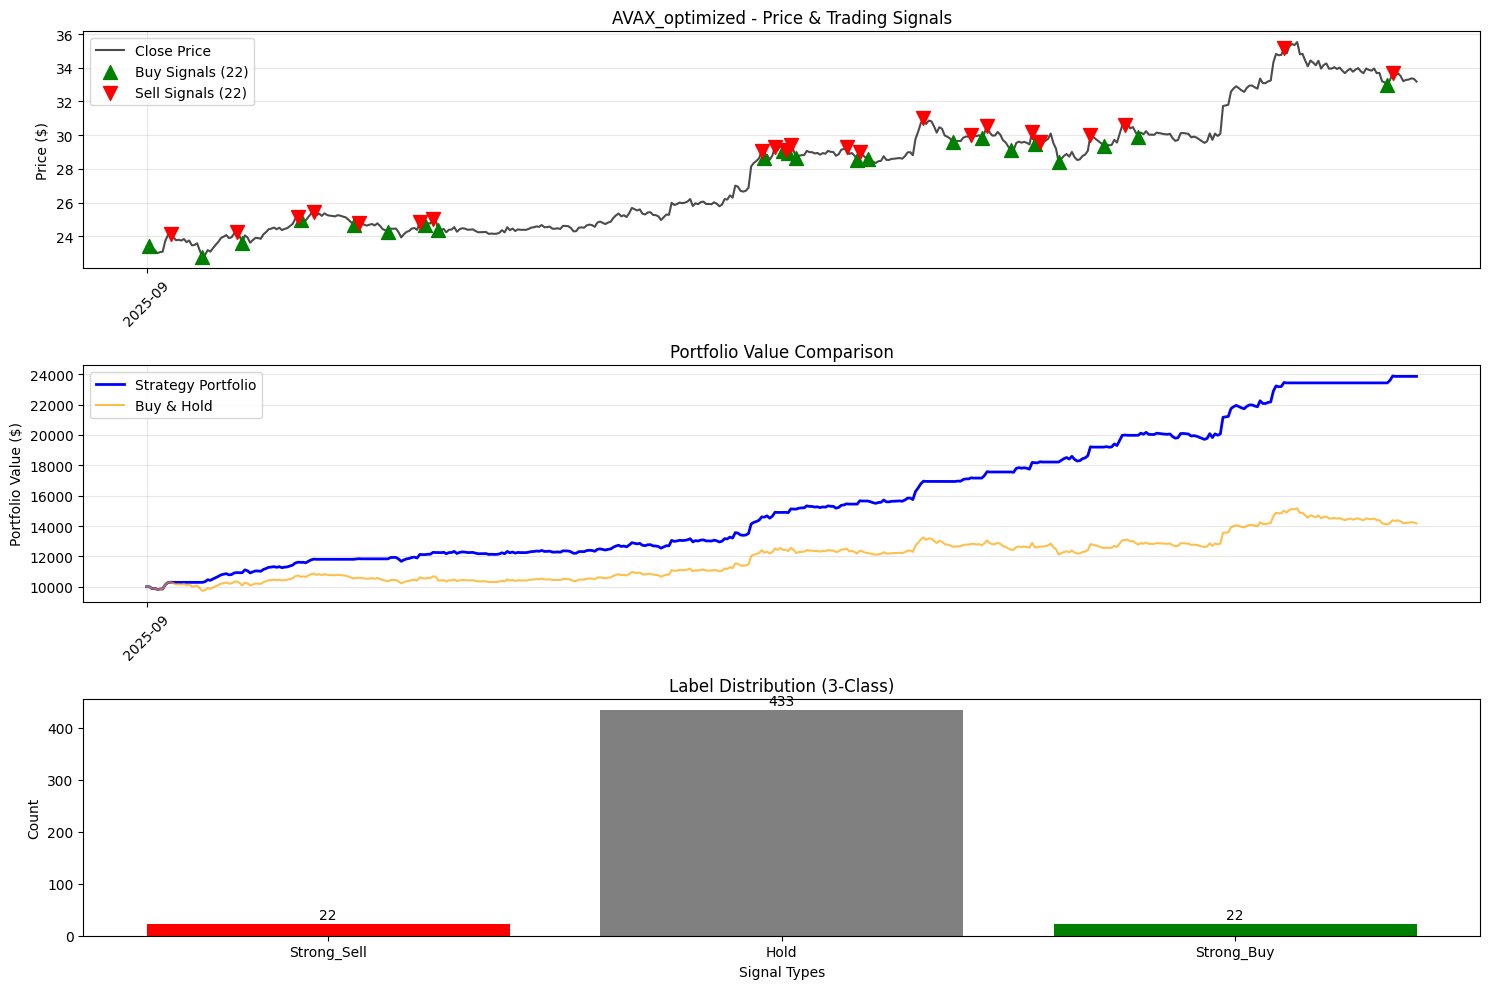


BCH_optimized 백테스팅 결과:
전략 수익률: 60.35%
Buy & Hold 수익률: 9.67%
초과 수익률: 50.67%
샤프 비율: 3.54
최대 손실폭: -2.27%
총 거래 횟수: 58회
승률: 100.00%
평균 거래수익률: 1.87%
최종 자산: $16,035


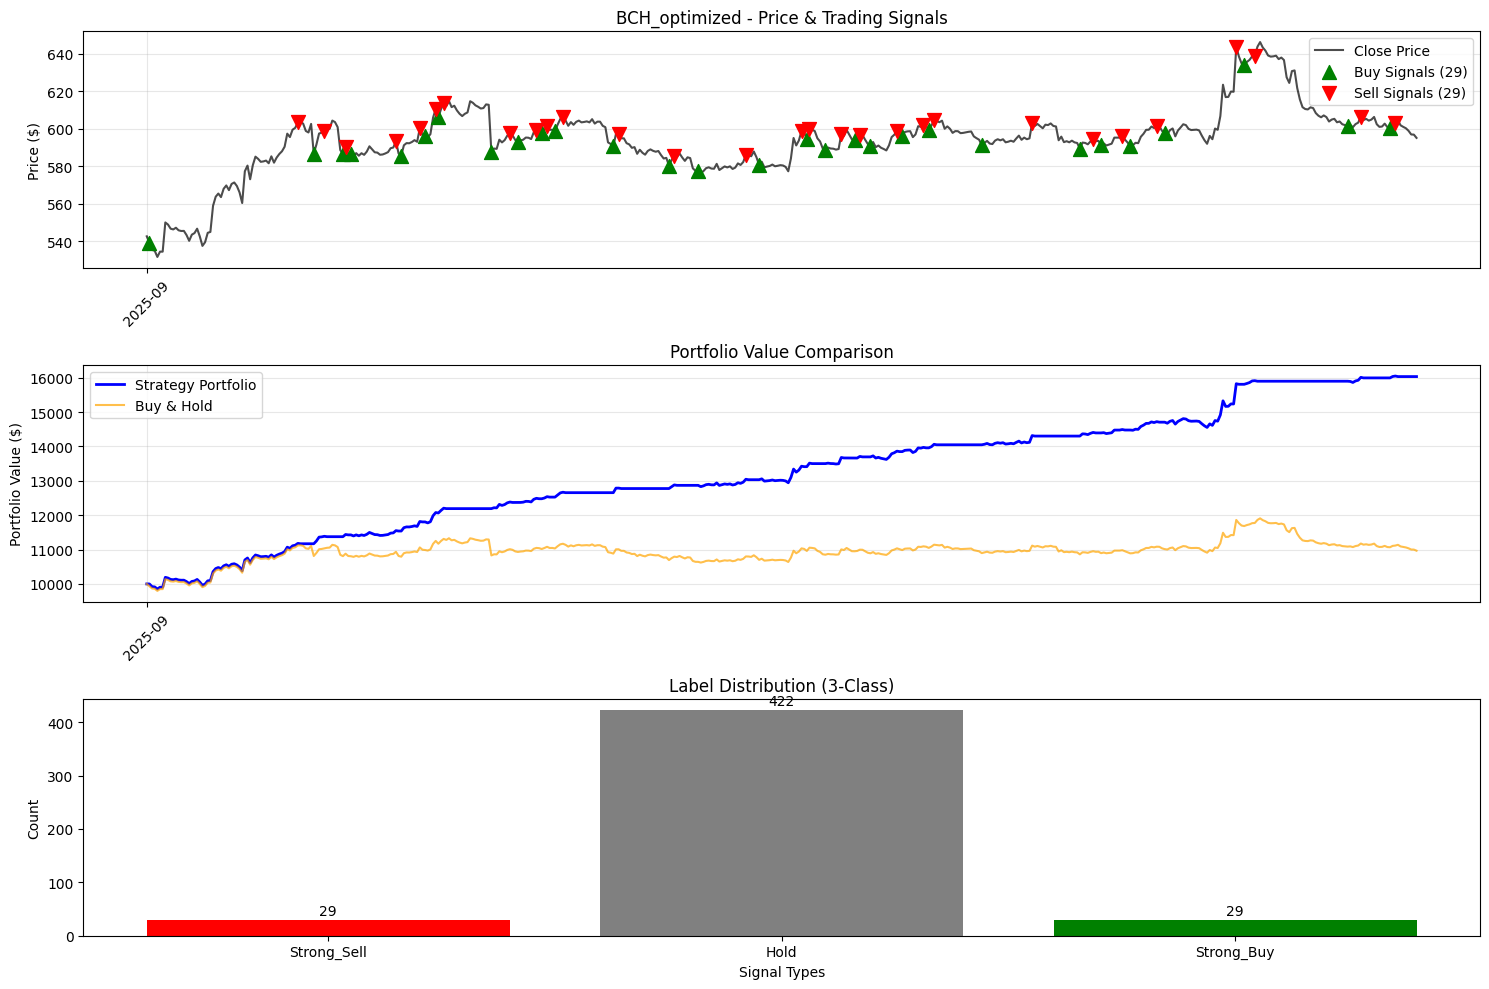


BNB_optimized 백테스팅 결과:
전략 수익률: 49.00%
Buy & Hold 수익률: 20.94%
초과 수익률: 28.06%
샤프 비율: 4.54
최대 손실폭: -0.81%
총 거래 횟수: 54회
승률: 100.00%
평균 거래수익률: 1.70%
최종 자산: $14,900


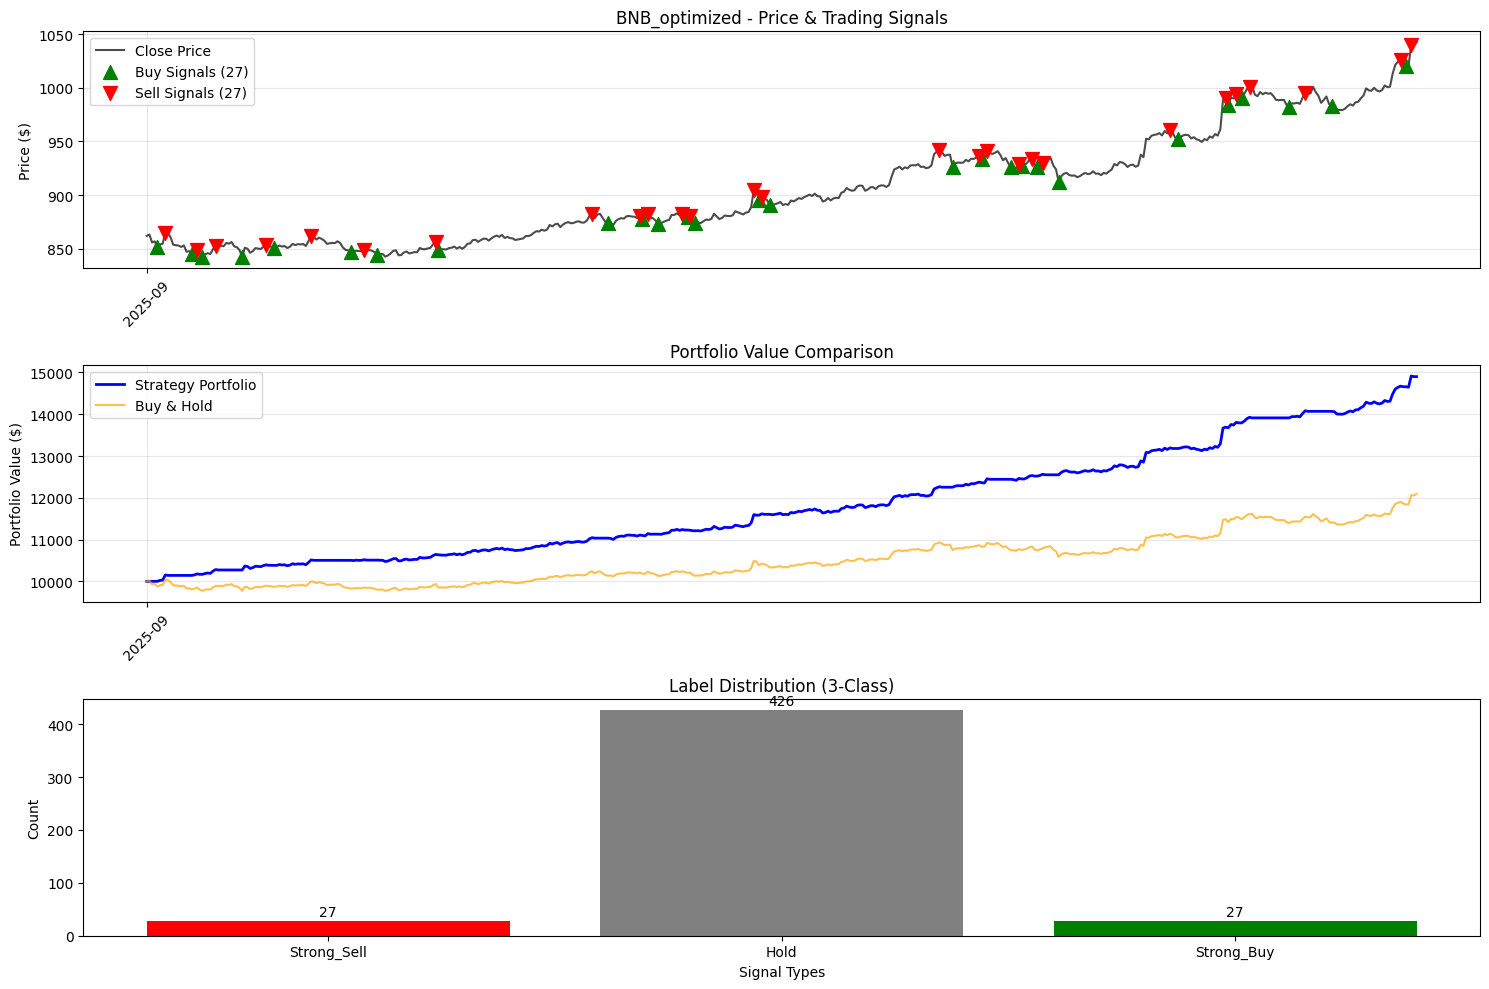


BTC_optimized 백테스팅 결과:
전략 수익률: 30.30%
Buy & Hold 수익률: 6.86%
초과 수익률: 23.44%
샤프 비율: 3.95
최대 손실폭: -1.36%
총 거래 횟수: 70회
승률: 100.00%
평균 거래수익률: 0.96%
최종 자산: $13,030


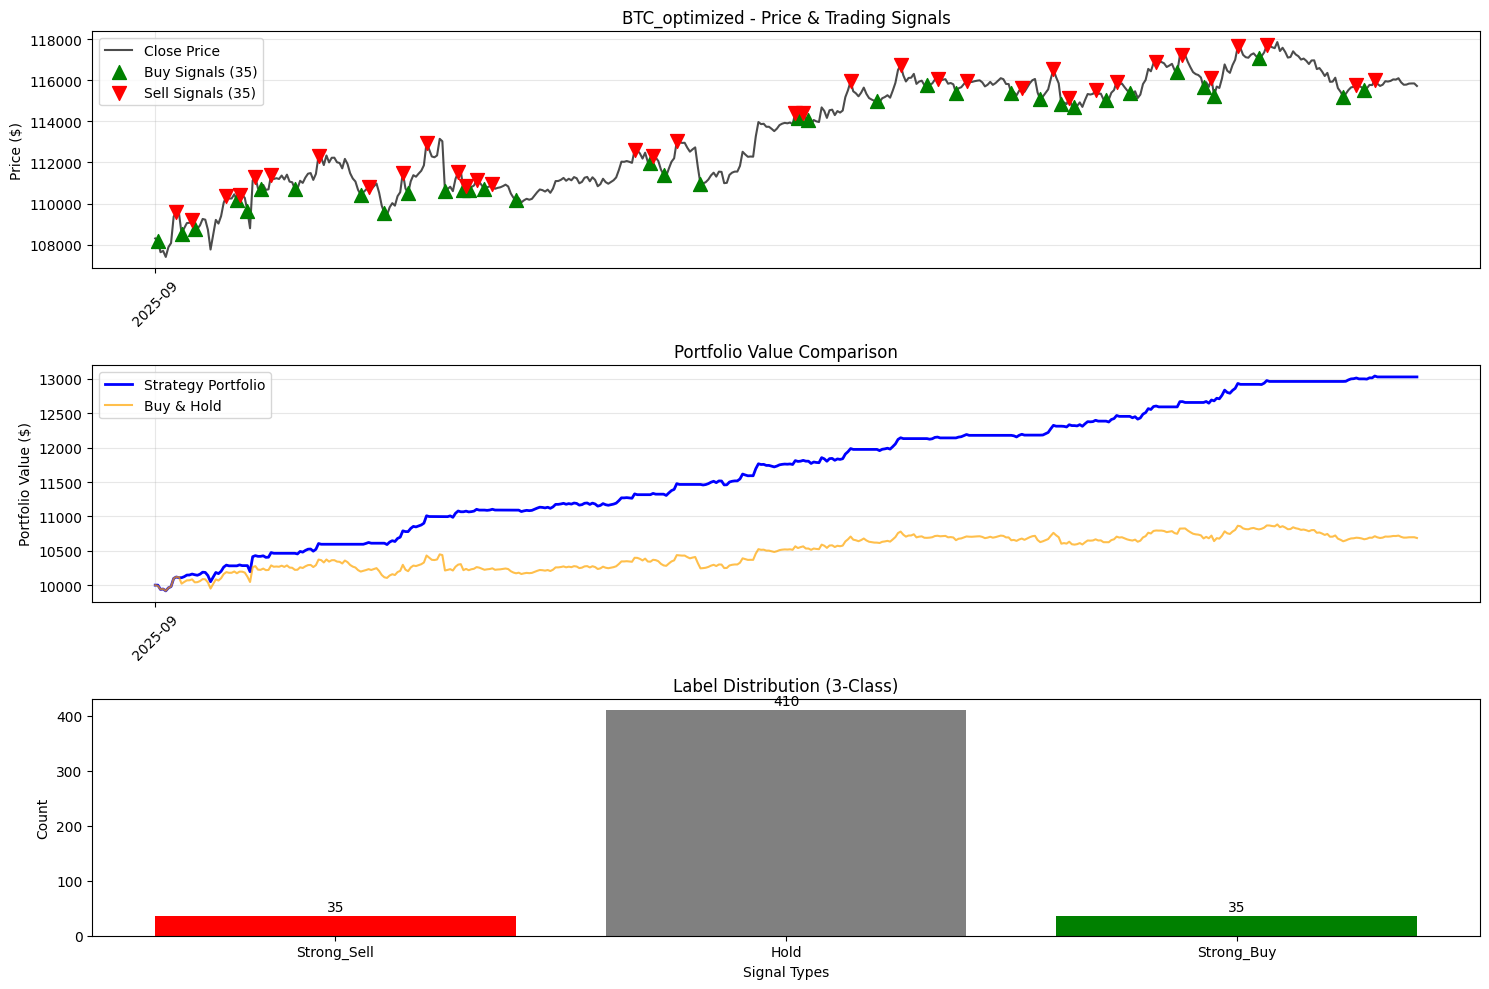


CRO_optimized 백테스팅 결과:
전략 수익률: 133.94%
Buy & Hold 수익률: -21.92%
초과 수익률: 155.86%
샤프 비율: 4.04
최대 손실폭: -1.38%
총 거래 횟수: 82회
승률: 100.00%
평균 거래수익률: 2.32%
최종 자산: $23,394


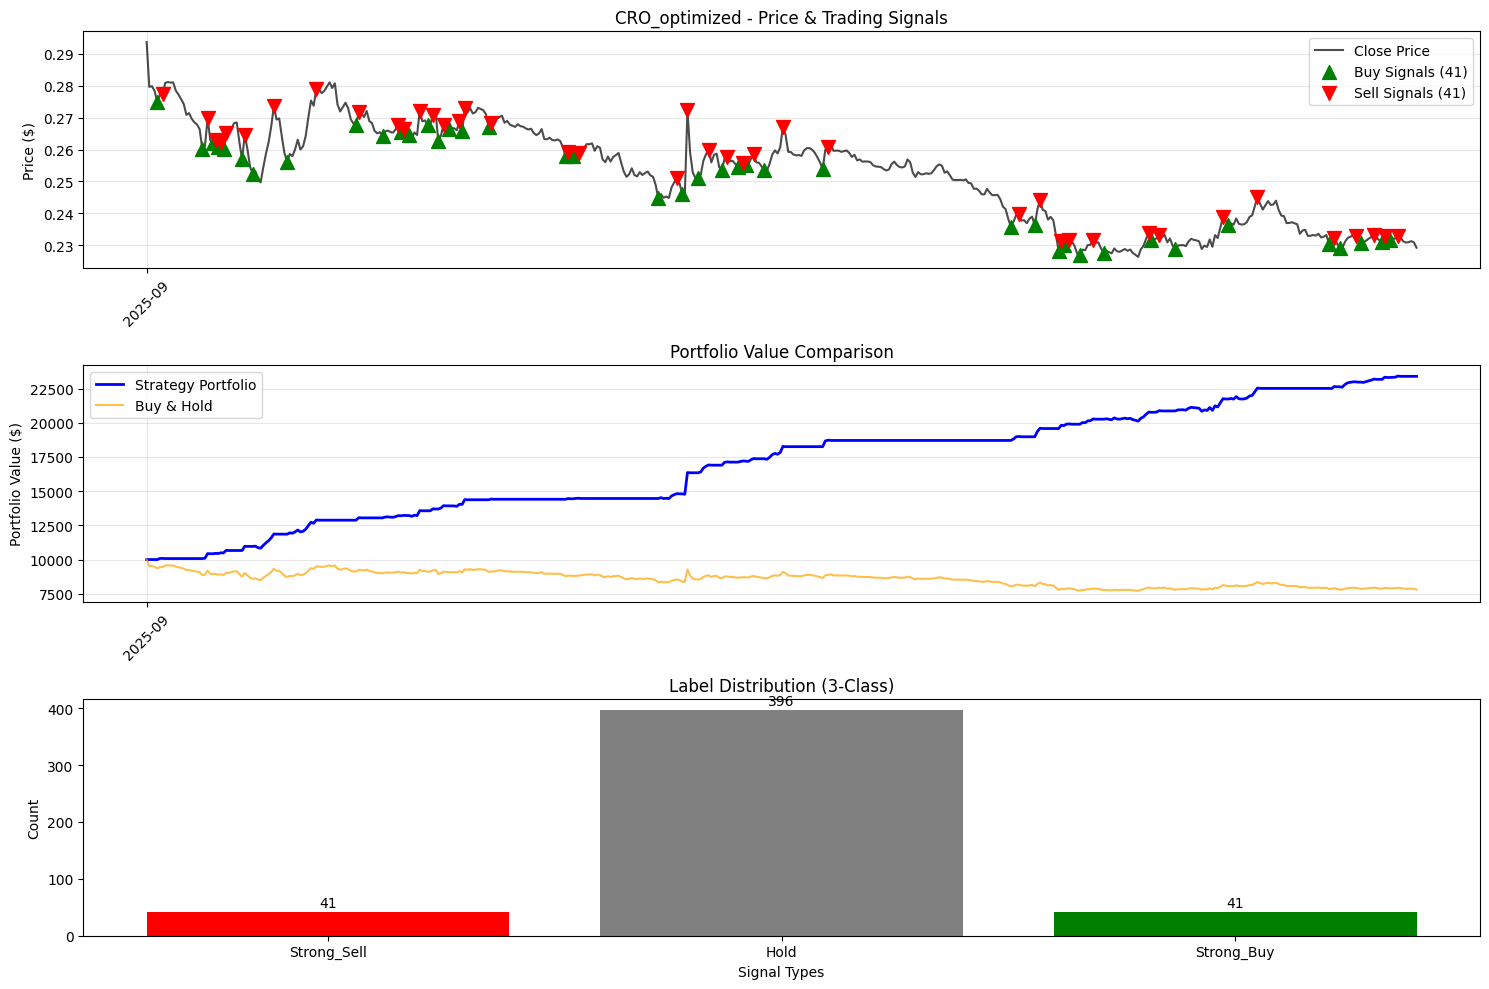


DOGE_optimized 백테스팅 결과:
전략 수익률: 130.98%
Buy & Hold 수익률: 25.55%
초과 수익률: 105.43%
샤프 비율: 4.47
최대 손실폭: -2.77%
총 거래 횟수: 56회
승률: 100.00%
평균 거래수익률: 3.34%
최종 자산: $23,098


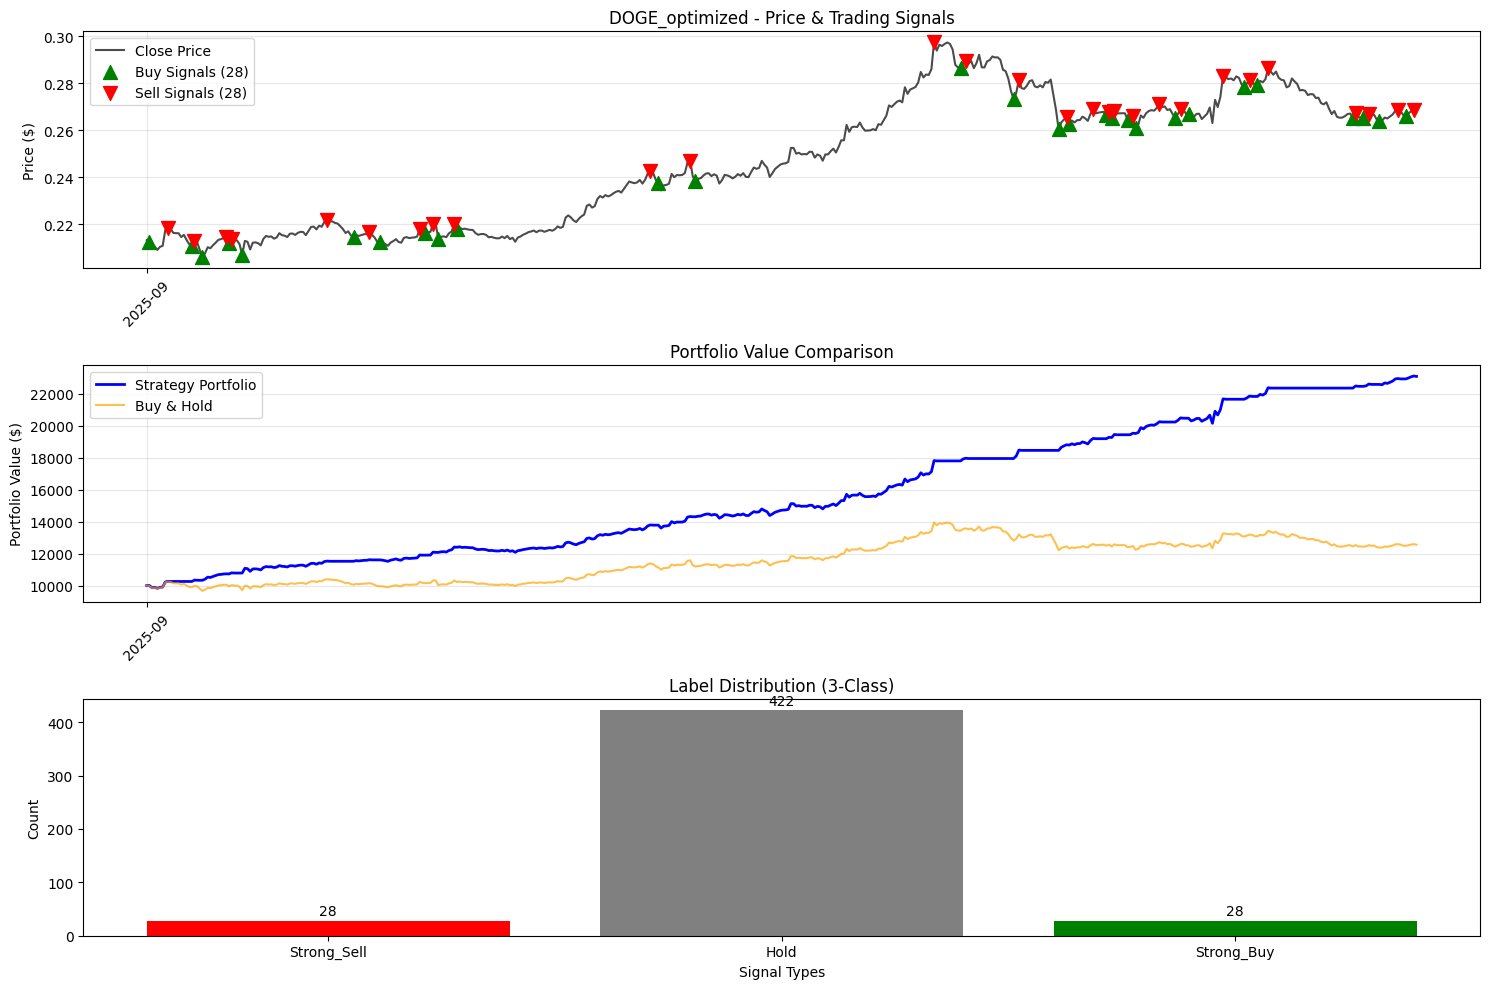


ETH_optimized 백테스팅 결과:
전략 수익률: 56.47%
Buy & Hold 수익률: 1.92%
초과 수익률: 54.56%
샤프 비율: 4.92
최대 손실폭: -0.81%
총 거래 횟수: 70회
승률: 100.00%
평균 거래수익률: 1.50%
최종 자산: $15,647


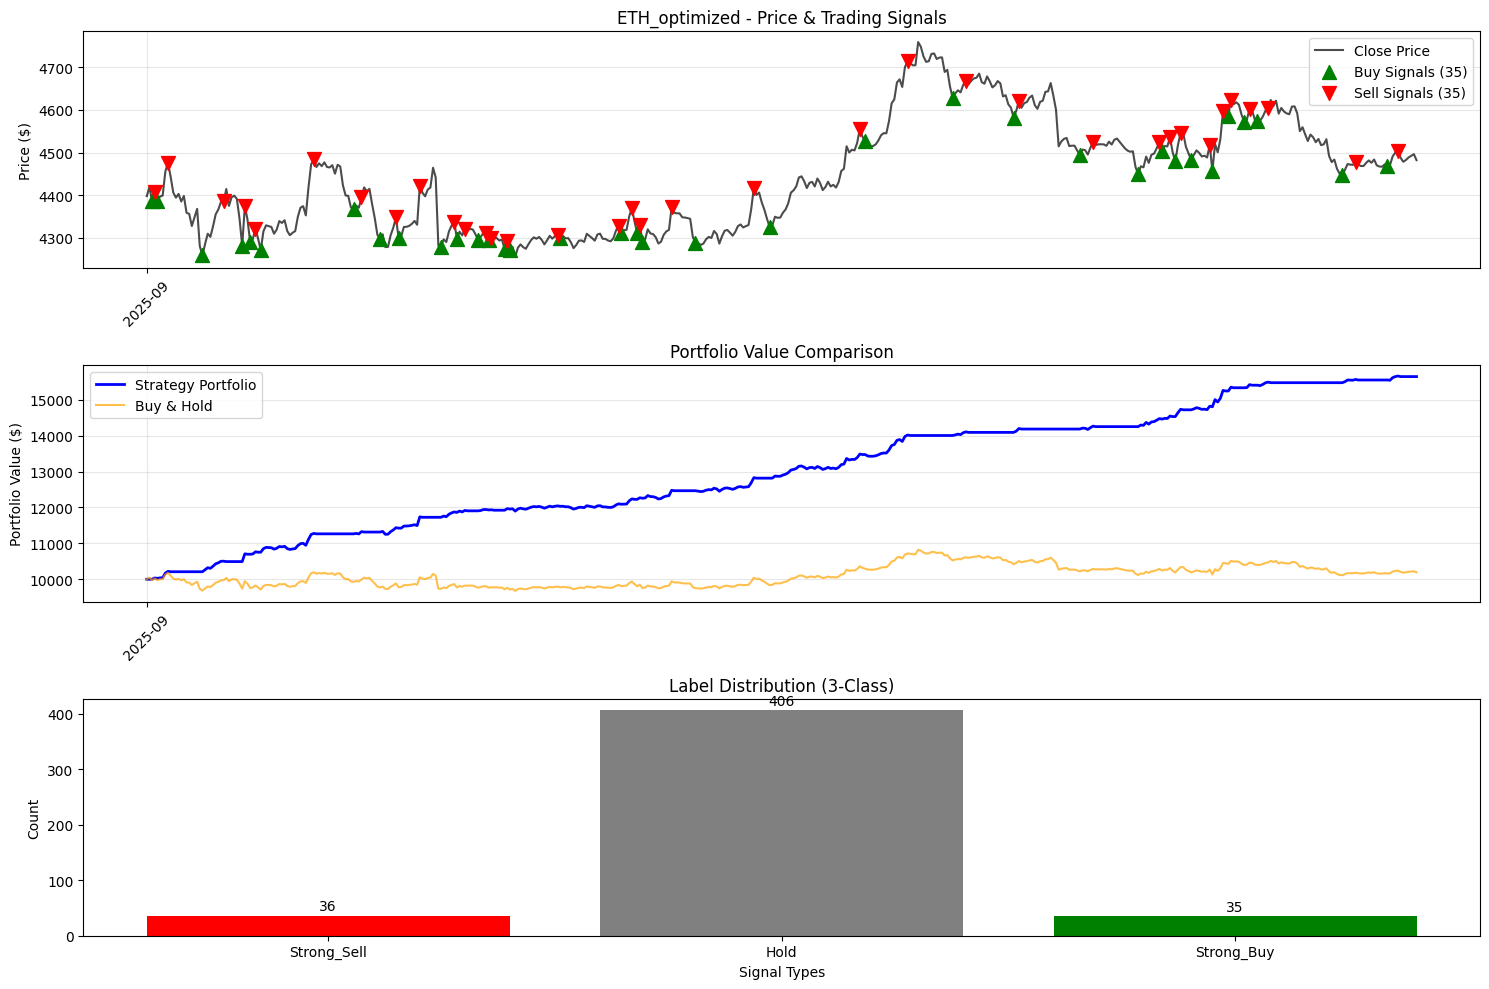


HBAR_optimized 백테스팅 결과:
전략 수익률: 91.07%
Buy & Hold 수익률: 11.59%
초과 수익률: 79.49%
샤프 비율: 4.79
최대 손실폭: -1.79%
총 거래 횟수: 66회
승률: 100.00%
평균 거래수익률: 2.20%
최종 자산: $19,107


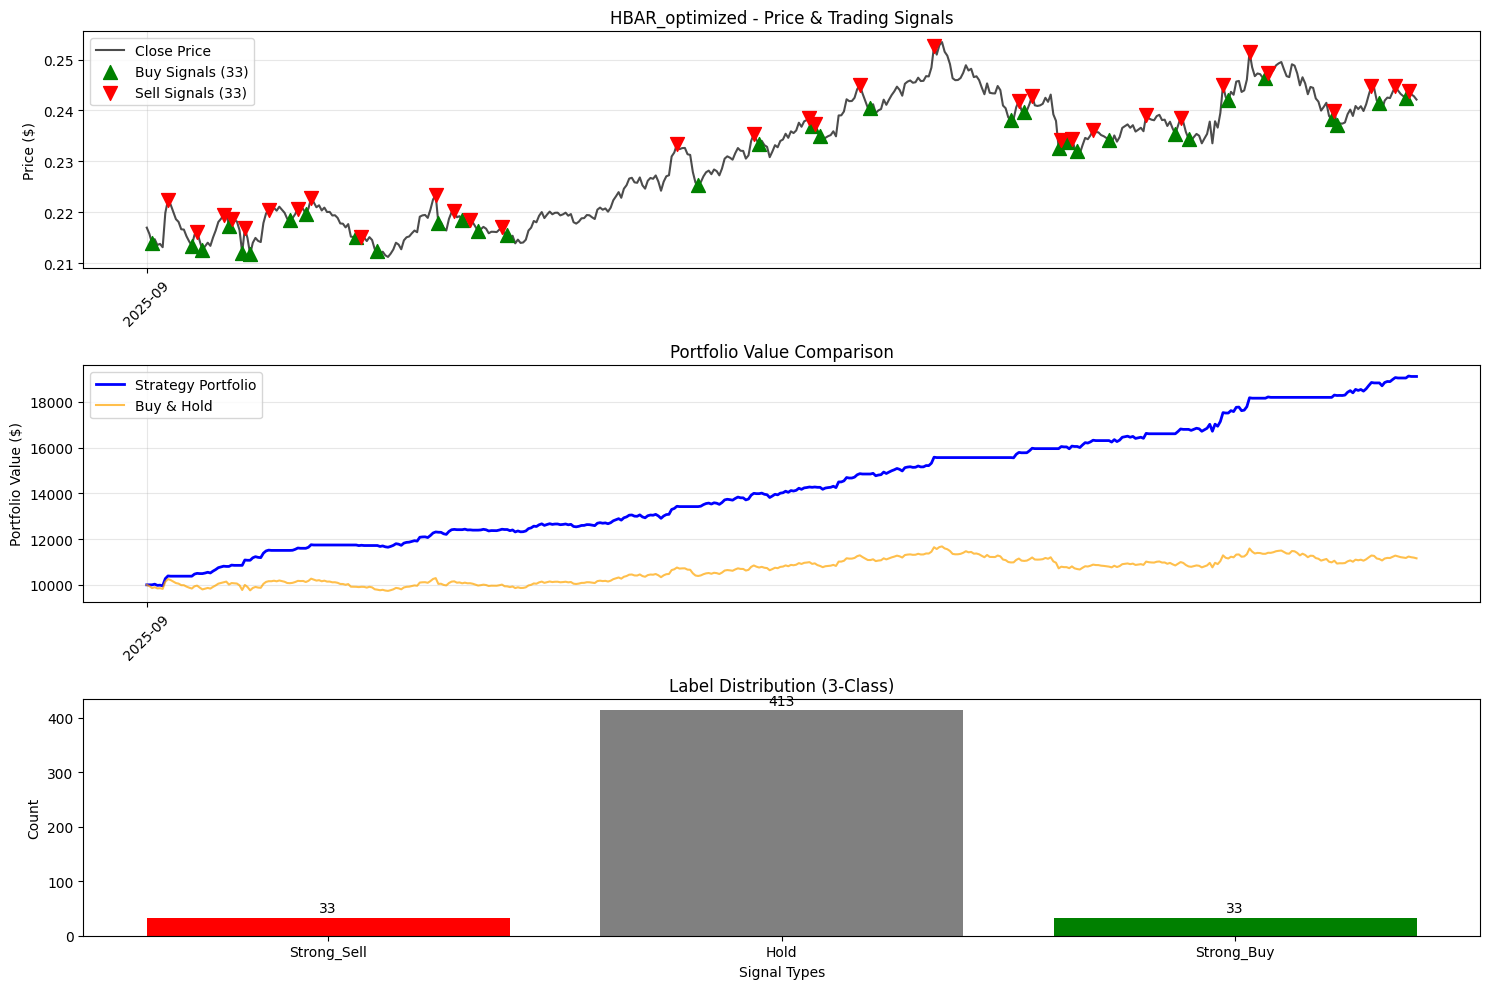


LEO_optimized 백테스팅 결과:
전략 수익률: 7.41%
Buy & Hold 수익률: -1.05%
초과 수익률: 8.46%
샤프 비율: 2.14
최대 손실폭: -0.62%
총 거래 횟수: 96회
승률: 100.00%
평균 거래수익률: 0.35%
최종 자산: $10,741


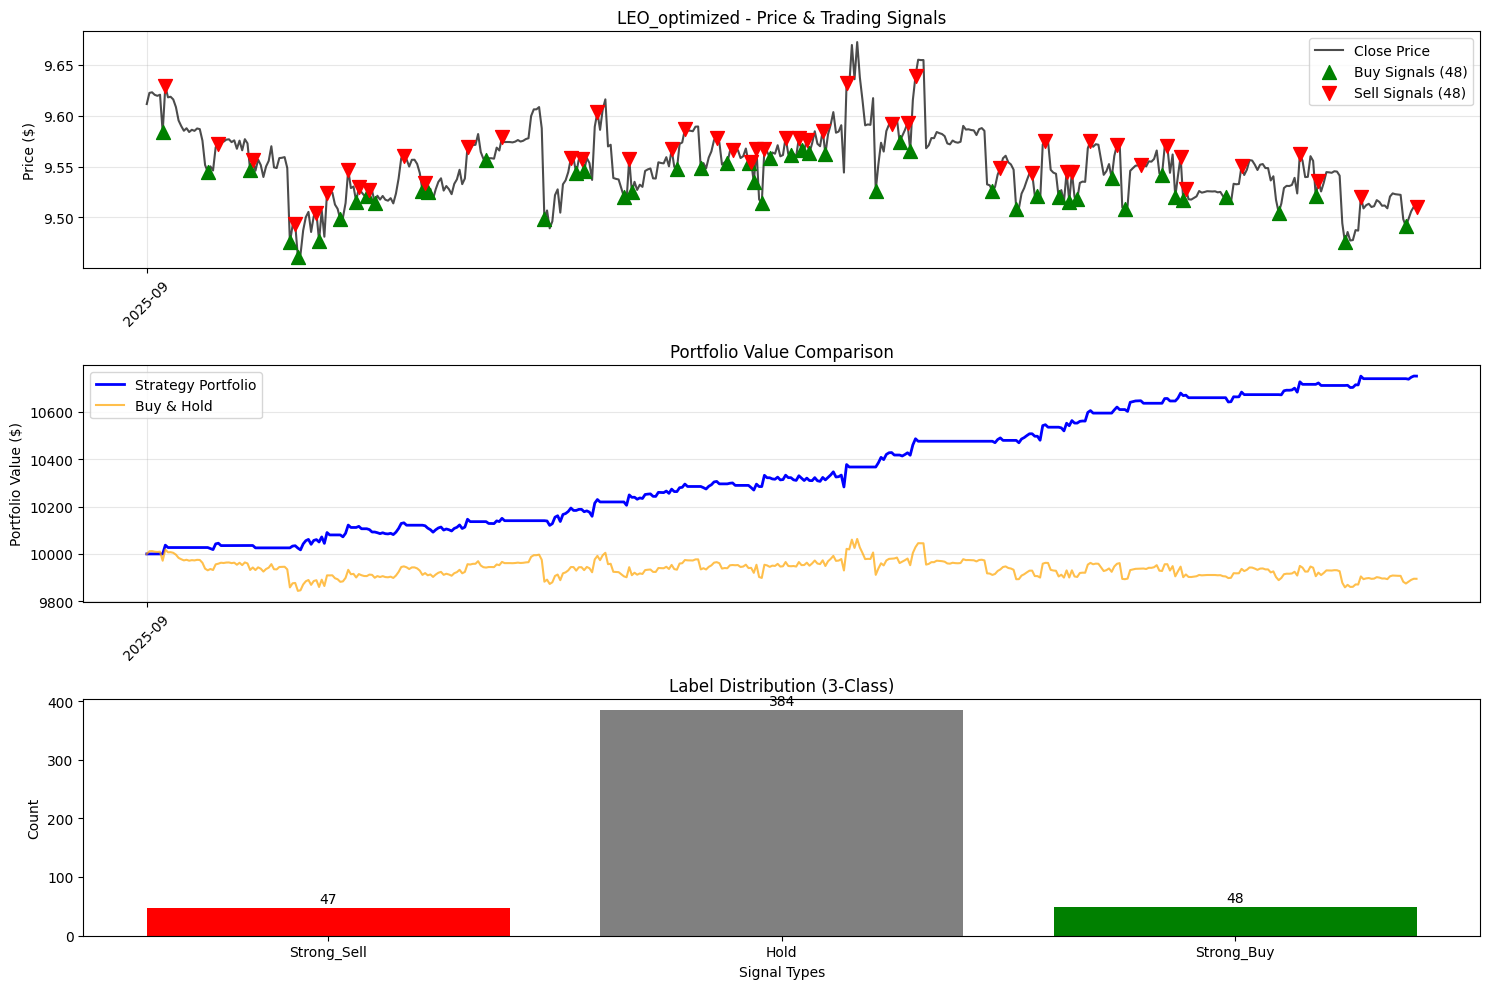


전체 백테스팅 결과 요약:
        Symbol  Total_Return  Excess_Return  Sharpe_Ratio  Win_Rate  Num_Trades
 ADA_optimized         0.767          0.660         4.225     1.000          60
AVAX_optimized         1.386          0.969         4.145     1.000          44
 BCH_optimized         0.603          0.507         3.537     1.000          58
 BNB_optimized         0.490          0.281         4.544     1.000          54
 BTC_optimized         0.303          0.234         3.948     1.000          70
 CRO_optimized         1.339          1.559         4.044     1.000          82
DOGE_optimized         1.310          1.054         4.471     1.000          56
 ETH_optimized         0.565          0.546         4.921     1.000          70
HBAR_optimized         0.911          0.795         4.786     1.000          66
 LEO_optimized         0.074          0.085         2.143     1.000          96

평균 통계:
평균 수익률: 77.48%
평균 초과수익률: 66.89%
평균 샤프비율: 4.08
평균 승률: 100.00%
2025년 9월 백테스팅 완료

전체 월별 백테스팅 완료

월별

In [7]:
# 월별 백테스팅 실행
if __name__ == "__main__":
    
    # 백테스팅할 년도와 월 범위 설정
    year = 2025
    start_month = 8
    end_month = 9
    
    # 각 월별 결과 저장
    monthly_results = {}
    
    print("월별 백테스팅 시작")
    print("=" * 50)
    
    for month in range(start_month, end_month + 1):
        print(f"\n{year}년 {month}월 백테스팅 실행 중...")
        
        try:
            # 해당 월 기간 설정 (월의 첫날부터 마지막날까지)
            from datetime import datetime, timedelta
            import calendar
            
            # 월의 첫날과 마지막날 계산
            first_day = datetime(year, month, 1)
            last_day_of_month = calendar.monthrange(year, month)[1]
            last_day = datetime(year, month, last_day_of_month)
            
            start_date = first_day.strftime('%Y-%m-%d')
            end_date = last_day.strftime('%Y-%m-%d')
            
            # 백테스팅 실행
            backtester, summary_df = run_individual_backtest(
                data_path=save_path_1,
                start_date=start_date,
                end_date=end_date,
                max_stocks=10,               # 처음 n개 종목만 테스트
                initial_capital=10000
            )
            
            # 해당 월 결과 저장
            monthly_results[f"{year}-{month:02d}"] = {
                'backtester': backtester,
                'summary_df': summary_df,
                'period': f'{start_date} ~ {end_date}'
            }
            
            print(f"{year}년 {month}월 백테스팅 완료")
            
        except Exception as e:
            print(f"{year}년 {month}월 백테스팅 실패: {e}")
            monthly_results[f"{year}-{month:02d}"] = None
    
    print("\n" + "=" * 50)
    print("전체 월별 백테스팅 완료")
    
    # 월별 결과 요약
    print("\n월별 결과 요약:")
    for month_key, result in monthly_results.items():
        if result is not None:
            print(f"{month_key}: 성공")
        else:
            print(f"{month_key}: 실패")
    
    # 월별 성과 비교 (선택사항)
    print("\n월별 평균 수익률 비교:")
    for month_key, result in monthly_results.items():
        if result is not None and result['summary_df'] is not None:
            avg_return = result['summary_df']['Total_Return'].mean()
            print(f"{month_key}: {avg_return:.2%}")